# Analyse des données d'économie, emploi et éducation avec l'API OCDE

**L'objectif de ce notebook est de réaliser une analyse intégrée des données sur l'économie, l'emploi et l'éducation de l'année 2021 dans 38 pays de l'OCDE et celle de Brésil , chargé depuis l'API de l'OCDE (Organisation de Coopération et de Développement Économiques). Nous allons procéder en plusieurs étapes pour nettoyer les données de chaque domaine et les fusionner ensuite pour obtenir un jeu de données commun et ainsi les anlayser avec différents méthodes de l'analyse de donnée.**

# 1. Chargement des données de l'api OCDE :


**Pour accéder aux données depuis l'API OCDE, nous utiliserons la bibliothèque pandas et des requêtes HTTP via requests.**

In [4]:
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_white

In [6]:
# URLs des ensembles de données
education_url = "https://sdmx.oecd.org/public/rest/data/OECD.EDU.IMEP,DSD_EAG_UOE_NON_FIN_STUD@DF_UOE_NF_DIST_FIELD,1.0/BEL+DEU+CHE+ESP+AUS+TUR+SWE+MEX+JPN+IRL+FRA+FIN+DNK+ITA+COL.ISCED11_45+ISCED11_35+ISCED11_746_756_766+ISCED11_5T8+ISCED11_5+ISCED11_6+ISCED11_7+ISCED11_8....F05T07+F00+F01+F02+F03+F04+F05+F06+F07+F08+F09+F10..A....NMOB+MOB..F+M.?startPeriod=2015&endPeriod=2022&dimensionAtObservation=AllDimensions"
data_VAB_url = 'https://sdmx.oecd.org/public/rest/data/OECD.SDD.NAD,DSD_NAMAIN10@DF_TABLE1_OUTPUT,2.0/A.HRV+SAU+CZE+TUR+CHE+SWE+MEX+JPN+ITA+IRL+FRA+FIN+ESP+DNK+COL+BEL+DEU+AUS...B1G+B1GQ..A+C+BTE+F+GTI+J+K+OTQ+M_N+L+RTU+_T..USD_EXC.V..?startPeriod=2015&endPeriod=2022&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
ocde_DATA_url='https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_PPP@DF_PPP,1.0/DEU+AUS+AUT+BEL+CAN+CHL+COL+KOR+CRI+DNK+ESP+EST+USA+FIN+FRA+GRC+HUN+IRL+ISL+ITA+JPN+LVA+LTU+LUX+MEX+NOR+NZL+NLD+POL+PRT+SVK+GBR+SVN+SWE+CHE+CZE+TUR.A.PPP.A01+A0101+A010101+A01010101+A01010102+A01010103+A01010104+A01010105+A01010106+A01010199+A010102+A0102+A010201+A010202+A0103+A0104+A0105+A0106+A010601+A0107+A010701+A0108+A0109+A0110+A0111+A0112.XDC_USD.OECD?startPeriod=2021&endPeriod=2021&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
taux_chomage_url='https://sdmx.oecd.org/public/rest/data/OECD.EDU.IMEP,DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP_FIELD,1.0/SWE+IRL+LUX+AUS+AUT+BEL+CHL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+ITA+LVA+LTU+MEX+NLD+NOR+POL+PRT+SVK+SVN+ESP+CHE+TUR+GBR+USA.F+M.Y55T64+Y45T54+Y35T44+Y25T34.ISCED11A_7_8+ISCED11A_6+ISCED11A_5+ISCED11A_5T8.F00_08_10+F05T07+F022T03+F02_03+F01+F02+F03+F04+F05+F06+F07+F08+F09+F10.........OBS...A3?startPeriod=2021&endPeriod=2021&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
taux_emploi_url='https://sdmx.oecd.org/public/rest/data/OECD.EDU.IMEP,DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_FIELD,1.0/SWE+IRL+LUX+AUS+AUT+BEL+CHL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+ITA+LVA+LTU+MEX+NLD+NOR+POL+PRT+SVK+SVN+ESP+CHE+TUR+GBR+USA.F+M.Y25T64.ISCED11A_7_8+ISCED11A_5+ISCED11A_6.F01+F02+F03+F04+F05+F06+F07+F08+F09+F10.........OBS...A3?startPeriod=2021&endPeriod=2021&lastNObservations=1&dimensionAtObservation=AllDimensions'
diffRevenue_url='https://sdmx.oecd.org/public/rest/data/OECD.EDU.IMEP,DSD_EAG_LSO_EA@DF_LSO_EARN_REL_MALE,1.0/LUX+IRL+AUS+AUT+BEL+CAN+CHL+COL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ITA+JPN+KOR+LVA+LTU+MEX+NLD+NZL+NOR+POL+PRT+SVK+SVN+ESP+CHE+TUR+GBR+USA+OECD+ARG+BRA+BGR+PER+ROU..Y25T64.ISCED11A_0T2+ISCED11A_3_4+ISCED11A_5T8.......EMP...OBS.FT..A?startPeriod=2021&endPeriod=2021&lastNObservations=1&dimensionAtObservation=AllDimensions'
# Liste des URLs avec leurs noms de fichier correspondants
urls = [
    {"url": education_url, "filename": "data_education.csv"},
    {"url": data_VAB_url, "filename": "VAB.csv"},
    {"url": ocde_DATA_url, "filename": "ocde_DATA.csv"},
    {"url": taux_chomage_url, "filename": "Taux_Chomage.csv"},
    {"url": diffRevenue_url, "filename": "diffRevenue.csv"},
    {"url": taux_emploi_url, "filename": "taux_emploi.csv"}
]

# En-têtes de la requête
headers = {
    'Accept': 'application/vnd.sdmx.data+csv; charset=utf-8'
}

# Fonction pour télécharger et sauvegarder les données
def download_data(url, filename):
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"Le fichier '{filename}' a été téléchargé avec succès.")
    else:
        print(f"Erreur {response.status_code} lors du téléchargement de {filename}")

# Boucle pour télécharger chaque jeu de données
for item in urls:
    download_data(item["url"], item["filename"])


Le fichier 'data_education.csv' a été téléchargé avec succès.
Le fichier 'VAB.csv' a été téléchargé avec succès.
Le fichier 'ocde_DATA.csv' a été téléchargé avec succès.
Le fichier 'Taux_Chomage.csv' a été téléchargé avec succès.
Le fichier 'diffRevenue.csv' a été téléchargé avec succès.
Le fichier 'taux_emploi.csv' a été téléchargé avec succès.


# **2. Nettoyage des données :**
## 2.1. les données de l'éducation

*   Cet dataset fournit des informations détaillées sur les étudiants dans l'enseignement supérieur
*   Les diplômés pour chaque domaine d'études et niveau d'étude.
*   Le pourcentage de dépense pour le meme domaine et niveau d'étude pour chaque pays .



In [ ]:
#afficher les donnée avant nettoyage
edu = pd.read_csv("/content/drive/MyDrive/educa2021.csv")
edu.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Zone de référence,EDUCATION_LEV,Niveau d'éducation,MEASURE,Mesure,...,CONF_STATUS,Statut de confidentialité,COMMENT_OBS,Commentaire d'observation,DECIMALS,Décimales,TIME_PER_COLLECT,Collection de périodes de temps,UNIT_MULT,Multiplicateur d'unité
0,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_UOE_NON_FIN_STUD@DF_UOE_...,"Répartition des élèves inscrits, des nouveaux ...",I,JPN,Japon,ISCED11_7,Niveau master ou équivalent,GRAD,Diplômés,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,0,NaN
1,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_UOE_NON_FIN_STUD@DF_UOE_...,"Répartition des élèves inscrits, des nouveaux ...",I,KOR,Corée,ISCED11_6,Niveau licence ou équivalent,GRAD,Diplômés,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,0,NaN
2,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_UOE_NON_FIN_STUD@DF_UOE_...,"Répartition des élèves inscrits, des nouveaux ...",I,JPN,Japon,ISCED11_7,Niveau master ou équivalent,GRAD,Diplômés,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,0,NaN
3,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_UOE_NON_FIN_STUD@DF_UOE_...,"Répartition des élèves inscrits, des nouveaux ...",I,JPN,Japon,ISCED11_8,Niveau doctorat ou équivalent,GRAD,Diplômés,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,0,NaN
4,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_UOE_NON_FIN_STUD@DF_UOE_...,"Répartition des élèves inscrits, des nouveaux ...",I,GRC,Grèce,ISCED11_8,Niveau doctorat ou équivalent,GRAD,Diplômés,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,0,NaN


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Suppression des colonnes non pertinentes ou redondantes :**

In [ ]:
edu = edu.drop(columns=[
    'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'REF_AREA',
     'EDUCATION_LEV', 'MEASURE',
    'Mesure', 'EDUCATION_TYPE', 'Type d\'éducation', 'INTENSITY',
  'Intensité', 'EDUCATION_FIELD',  'GRADE', 'Classe',
    'FREQ', 'Fréquence d\'observation', 'ORIGIN', 'Origine', 'DESTINATION',
    'Unnamed: 23', 'INST_TYPE_EDU', 'Type d\'établissement d\'enseignement',
    'MOBILITY', 'Mobilité', 'UNIT_MEASURE', 'Unité de mesure',
    'Sexe', 'AGE', 'Âge', 'Période de temps',
    'Valeur d\'observation', 'REF_YEAR_AGES',
    'Date de référence pour les âges', 'ORIGIN_CRITERION',
    'Critère d\'origine', 'REPYEARSTART', 'Année de référence début',
    'REPYEAREND', 'Année de référence fin',
    'Statut d\'observation', 'CONF_STATUS', 'Statut de confidentialité',
    'COMMENT_OBS', 'Commentaire d\'observation', 'DECIMALS', 'Décimales',
    'TIME_PER_COLLECT', 'Collection de périodes de temps','TIME_PERIOD', 'UNIT_MULT',
    'Multiplicateur d\'unité','OBS_STATUS'
])
edu.columns
# Afficher les premières lignes du DataFrame après suppression des colonnes
edu.head()


,Zone de référence,Niveau d'éducation,Domaines d’études,SEX,OBS_VALUE
0,Japon,Niveau master ou équivalent,"Commerce, administration et droit",F,NaN
1,Corée,Niveau licence ou équivalent,"Ingénierie, industries de transformation et co...",M,16.444929
2,Japon,Niveau master ou équivalent,Programmes et certifications génériques,M,NaN
3,Japon,Niveau doctorat ou équivalent,Santé et protection sociale,F,NaN
4,Grèce,Niveau doctorat ou équivalent,"Sciences sociales, journalisme et information",M,0.000000


**Suppression des valeurs manquantes, les doublons et renommage des colonnes : :**

In [ ]:
# Vérifier les colonnes numériques
numerical_columns = edu.select_dtypes(include=['number']).columns

# Remplacer les valeurs nulles uniquement dans les colonnes numériques par la moyenne
edu[numerical_columns] = edu[numerical_columns].fillna(edu[numerical_columns].mean())

# Supprimer les doublons
edu = edu.drop_duplicates()

# Renommer les colonnes
edu = edu.rename(columns={
    'SEX': 'Genre',
    'Zone de référence': 'Pays',
    'OBS_VALUE': 'Pourcentage depenses',
    'Domaine d\'études': 'Domain etude',
    'TIME_PERIOD': 'Annee'
})

# Afficher les premières lignes du DataFrame
edu.head()


,Pays,Niveau d'éducation,Domaines d’études,Genre,Pourcentage depenses
0,Japon,Niveau master ou équivalent,"Commerce, administration et droit",F,17.791047
1,Corée,Niveau licence ou équivalent,"Ingénierie, industries de transformation et co...",M,16.444929
2,Japon,Niveau master ou équivalent,Programmes et certifications génériques,M,17.791047
3,Japon,Niveau doctorat ou équivalent,Santé et protection sociale,F,17.791047
4,Grèce,Niveau doctorat ou équivalent,"Sciences sociales, journalisme et information",M,0.000000


In [ ]:
# Sauvegarder les données nettoyées dans un fichier CSV
edu.to_csv('education_cleaned.csv', index=False)

## 2.1. les données de l'économie :

##     2.1.1. VAB dataset (Valeur ajoutée brute) :

- Ce dataset permet d'évaluer la contribution de chaque secteur ou activité à l'économie globale, pour l'année 2021.
- La VAB correspond à la différence entre la production totale d'un secteur (ou d'une entreprise) et la valeur des consommations intermédiaires utilisées pour produire cette production.
- La valeur de VAB est en Millions USD.

In [ ]:
#afficher les donnée avant nettoyage
df = pd.read_csv('VAB.csv')
df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,FREQ,Fréquence d'observation,REF_AREA,Zone de référence,SECTOR,Secteur institutionnel,...,CONF_STATUS,Statut de confidentialité,DECIMALS,Décimales,OBS_STATUS,Statut d'observation,UNIT_MULT,Multiplicateur d'unité,CURRENCY,Monnaie
0,DATAFLOW,OECD.SDD.NAD:DSD_NAMAIN10@DF_TABLE1_OUTPUT(2.0),PIB annuel et ses composantes selon l'approche...,I,A,Annuelle,CHL,Chili,S1,Economie totale,...,F,Libre (libre pour publication),1,NaN,A,NaN,6,NaN,_Z,N'est pas applicable
1,DATAFLOW,OECD.SDD.NAD:DSD_NAMAIN10@DF_TABLE1_OUTPUT(2.0),PIB annuel et ses composantes selon l'approche...,I,A,Annuelle,TUR,Türkiye,S1,Economie totale,...,F,Libre (libre pour publication),1,NaN,A,NaN,6,NaN,_Z,N'est pas applicable
2,DATAFLOW,OECD.SDD.NAD:DSD_NAMAIN10@DF_TABLE1_OUTPUT(2.0),PIB annuel et ses composantes selon l'approche...,I,A,Annuelle,GRC,Grèce,S1,Economie totale,...,F,Libre (libre pour publication),1,NaN,A,NaN,6,NaN,_Z,N'est pas applicable
3,DATAFLOW,OECD.SDD.NAD:DSD_NAMAIN10@DF_TABLE1_OUTPUT(2.0),PIB annuel et ses composantes selon l'approche...,I,A,Annuelle,POL,Pologne,S1,Economie totale,...,F,Libre (libre pour publication),1,NaN,A,NaN,6,NaN,_Z,N'est pas applicable
4,DATAFLOW,OECD.SDD.NAD:DSD_NAMAIN10@DF_TABLE1_OUTPUT(2.0),PIB annuel et ses composantes selon l'approche...,I,A,Annuelle,GRC,Grèce,S1,Economie totale,...,F,Libre (libre pour publication),1,NaN,A,NaN,6,NaN,_Z,N'est pas applicable



**Suppression des colonnes inutiles :**



In [ ]:
colonnes_a_supprimer = [
    'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'FREQ',
    "Fréquence d'observation", 'SECTOR', 'Secteur institutionnel',
    'COUNTERPART_SECTOR', 'Secteur institutionnel de contrepartie',
    'Instruments financiers et actifs non financiers', 'INSTR_ASSET', 'Transaction',
    'Price base', 'TRANSFORMATION', 'PRICE_BASE', 'Type de prix', 'REF_AREA', 'EXPENDITURE',
    'Transformation', 'TABLE_IDENTIFIER', 'ACTIVITY', 'Identifiant de tableau', 'Time period',
    'REF_YEAR_PRICE', "Valeur d'observation", 'Price reference year', 'Statut de confidentialité',
    'CONF_STATUS', 'DECIMALS', 'Décimales', 'OBS_STATUS', 'Statut d\'observation', 'UNIT_MULT',
    'Multiplicateur d\'unité', 'Monnaie', 'CURRENCY', 'Dépense', 'UNIT_MEASURE', 'Unité de mesure'
    ,'Prix ​​année de référence','Période temporelle','TRANSACTION','TIME_PERIOD'
]

# Supprimer les colonnes inutiles
df_cleaned = df.drop(columns=colonnes_a_supprimer, errors='ignore')


# Sauvegarder le dataset nettoyé
df_cleaned.to_csv('VAB_nettoyé.csv', index=False)


In [ ]:
df_cleaned = pd.read_csv('VAB_nettoyé.csv')

df_cleaned.head()


,Zone de référence,Activité économique,OBS_VALUE
0,Chili,Information et communication,8019.773
1,Türkiye,Information et communication,22928.571
2,Grèce,Total - ensemble des activités,190439.435
3,Pologne,"Agriculture, sylviculture et pêche",15475.476
4,Grèce,Industrie (sauf construction),28667.351


**Vérification des valeurs manquantes et renommage des colonnes :**

In [ ]:
print(df_cleaned.isnull().sum())

Zone de référence      0
Activité économique    0
OBS_VALUE              0
dtype: int64


In [ ]:
# Renommer les colonnes
df_cleaned = df_cleaned.rename(columns={
    'Zone de référence': 'Pays',
    'TIME_PERIOD': 'annee',
    'Activité économique':'Activite economique',
    'OBS_VALUE': 'VAB'
})

# Afficher un aperçu des données avec les nouvelles colonnes
print(df_cleaned.head())

# Sauvegarder le dataset avec les nouvelles colonnes
df_cleaned.to_csv('VAB_nettoyé_renommé.csv', index=False)


      Pays                 Activite economique         VAB
0    Chili        Information et communication    8019.773
1  Türkiye        Information et communication   22928.571
2    Grèce      Total - ensemble des activités  190439.435
3  Pologne  Agriculture, sylviculture et pêche   15475.476
4    Grèce       Industrie (sauf construction)   28667.351


In [ ]:
df = pd.read_csv('VAB_nettoyé_renommé.csv')

df.head()


,pays,Activité économique,VAB
0,Chili,Information et communication,8019.773
1,Türkiye,Information et communication,22928.571
2,Grèce,Total - ensemble des activités,190439.435
3,Pologne,"Agriculture, sylviculture et pêche",15475.476
4,Grèce,Industrie (sauf construction),28667.351


##     2.1.2. IDE dataset (Investissements directs étrangers) :

Ce dataset porte sur les flux d'investissements directs étrangers (IDE), ventilés par activité économique, zone de référence
- Les données sont exprimées en en millions dollars américains (USD).
- Fréquence d'observation : Données observées annuellement.
- Le principe de mesure peut etre soit : **DO :** Flux d'IDE entrant et sortant
    ou bien **DI :** Flux d'IDE entrant


In [ ]:
df = pd.read_csv('IDE.csv')
df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Zone de référence,MEASURE,Mesure,UNIT_MEASURE,Unité de mesure,...,OBS_STATUS,Statut de l'observation,UNIT_MULT,Multiplicateur d'unité,CONF_STATUS,Statut de confidentialité,CURRENCY,Monnaie,DECIMALS,Décimales
0,DATAFLOW,OECD.DAF.INV:DSD_FDI@DF_FDI_FLOW_IND(1.0),"Flux d'IDE par activité économique, BMD4",I,AUT,Autriche,T_FA_F,Flux financiers d'IDI - total,USD_EXC,"Dollars des É-U, taux de change converti",...,A,NaN,6,NaN,N,NaN,USD,Dollars des États-Unis,2,NaN
1,DATAFLOW,OECD.DAF.INV:DSD_FDI@DF_FDI_FLOW_IND(1.0),"Flux d'IDE par activité économique, BMD4",I,IRL,Irlande,T_FA_F,Flux financiers d'IDI - total,USD_EXC,"Dollars des É-U, taux de change converti",...,A,NaN,6,NaN,C,NaN,USD,Dollars des États-Unis,2,NaN
2,DATAFLOW,OECD.DAF.INV:DSD_FDI@DF_FDI_FLOW_IND(1.0),"Flux d'IDE par activité économique, BMD4",I,CHE,Suisse,T_FA_F,Flux financiers d'IDI - total,USD_EXC,"Dollars des É-U, taux de change converti",...,A,NaN,6,NaN,C,NaN,USD,Dollars des États-Unis,2,NaN
3,DATAFLOW,OECD.DAF.INV:DSD_FDI@DF_FDI_FLOW_IND(1.0),"Flux d'IDE par activité économique, BMD4",I,PRT,Portugal,T_FA_F,Flux financiers d'IDI - total,USD_EXC,"Dollars des É-U, taux de change converti",...,A,NaN,6,NaN,N,NaN,USD,Dollars des États-Unis,2,NaN
4,DATAFLOW,OECD.DAF.INV:DSD_FDI@DF_FDI_FLOW_IND(1.0),"Flux d'IDE par activité économique, BMD4",I,BEL,Belgique,T_FA_F,Flux financiers d'IDI - total,USD_EXC,"Dollars des É-U, taux de change converti",...,A,NaN,6,NaN,C,NaN,USD,Dollars des États-Unis,2,NaN



**Suppression des colonnes inutiles :**



In [ ]:
colonnes_a_supprimer = [
    'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'REF_AREA', 'MEASURE',
    'Mesure', 'UNIT_MEASURE', 'Unité de mesure', 'ACCOUNTING_ENTRY', 'Ecriture comptable',
    'TYPE_ENTITY', 'Type d\'entité', 'FDI_COMP', 'Composant de l\'IDE', 'SECTOR',
    'Secteur institutionnel', 'COUNTERPART_AREA', 'Zone de contrepartie', 'LEVEL_COUNTERPART',
    'FREQ', 'ACTIVITY', 'Niveau de contrepartie', 'LEVEL_COUNTERPART', 'Fréquence d\'observation',
    'FDI_COLLECTION_ID', 'Identifiant de collecte des IDE', 'TIME_PERIOD', 'Période temporelle',
    'OBS_STATUS', 'Valeur de l\'observation', 'OBS_STATUS', 'UNIT_MULT', 'Statut de l\'observation',
    'Multiplicateur d\'unité', 'CONF_STATUS', 'Statut de confidentialité', 'CURRENCY', 'Monnaie',
    'Décimales', 'DECIMALS', 'CHAPTER', 'Chapitre', 'Valeur d\'observation', 'Ajustement',
    'COUNTERPART_SECTOR', 'Secteur institutionnel de contrepartie', 'CONSOLIDATION', 'ADJUSTMENT',
    'Secteur institutionnel de contrepartie', 'Statut de consolidation', 'TRANSACTION',
    'INSTR_ASSET', 'PRODUCT', 'Échéance initiale et résiduelle', 'MATURITY', 'Instruments et actifs',
    'Produit', 'PENSION_FUNDTYPE', 'Type de fond de pension', 'CURRENCY_DENOM',
    'Statut d\'observation', 'Période de base', 'BASE_PER', 'Prix ​​année de référence',
    'REF_YEAR_PRICE', 'Identifiant de tableau', 'Transformation', 'TRANSFORMATION', 'Type de prix',
    'PRICE_BASE', 'Evaluation', 'EVALUATION', 'Monnaie de libellé', 'TABLE_IDENTIFIER', 'VALUATION','Principe de mesure'
]
df_cleaned = df.drop(columns=colonnes_a_supprimer, errors='ignore')


# Sauvegarder le dataset nettoyé
df_cleaned.to_csv('IDE_nettoyé.csv', index=False)
df_cleaned.head()

,Zone de référence,MEASURE_PRINCIPLE,Activité économique,OBS_VALUE
0,Autriche,DO,Activités de conseils en matière de gestion,NaN
1,Irlande,DO,Activités de location,NaN
2,Suisse,DO,Commerce de gros à l’exception des véhicules a...,NaN
3,Portugal,DI,Activités des sociétés de portefeuille,NaN
4,Belgique,DI,Télécommunications,NaN


**Renommage des colonnes :**


In [ ]:
df_cleaned = df_cleaned.rename(columns={
    'Zone de référence': 'Pays',
    'Activité économique': 'Activite economique',
    'OBS_VALUE': 'IDE',
    'MEASURE_PRINCIPLE' : 'Principe de mesure'
    #DO : Principe directionnel-sortant
    #DI : Principe directionnel-entrant
})

# Afficher un aperçu des données avec les nouvelles colonnes
print(df_cleaned.head())

# Sauvegarder le dataset avec les nouvelles colonnes
df_cleaned.to_csv('IDE_nettoyé_Renommé.csv', index=False)


       Pays Principe de mesure  \
0  Autriche                 DO   
1   Irlande                 DO   
2    Suisse                 DO   
3  Portugal                 DI   
4  Belgique                 DI   

                                 Activite economique  IDE  
0        Activités de conseils en matière de gestion  NaN  
1                              Activités de location  NaN  
2  Commerce de gros à l’exception des véhicules a...  NaN  
3             Activités des sociétés de portefeuille  NaN  
4                                 Télécommunications  NaN  


**Vérifier l'existence de valeurs nulles :**


In [ ]:
print("Résumé des valeurs nulles par colonne :")
print(df_cleaned.isnull().sum())

# Vérifier si le dataset contient des valeurs nulles
print("\nLe dataset contient-il des valeurs nulles ? :", df_cleaned.isnull().values.any())


Résumé des valeurs nulles par colonne :
Pays                      0
Principe de mesure        0
Activite economique       0
IDE                    1725
dtype: int64

Le dataset contient-il des valeurs nulles ? : True


**Suppression des lignes où 'IDE' est vide (NaN) :**

In [ ]:
df_cleaned1 = df_cleaned.dropna(subset=['IDE'])

# Vérifier le résultat
print("Dataset après suppression des lignes où 'IDE' est vide :")
print(df_cleaned1.head())

# Sauvegarder le dataset nettoyé
df_cleaned1.to_csv('IDE_final.csv', index=False)


Dataset après suppression des lignes où 'IDE' est vide :
                    Pays Principe de mesure  \
463               France                 DI   
465              Espagne                 DI   
466           Costa Rica                 DI   
467             Pays-Bas                 DO   
468  République slovaque                 DO   

                                   Activite economique          IDE  
463                       Information et communication  9258.514664  
465     Fabrication de machines et de matériel, n.c.a.   197.492904  
466                 Agriculture, sylviculture et pêche   -64.366890  
467  Fabrication de métaux de base et de produits m...  -314.569536  
468  Activités des agences de voyages, voyagistes, ...     0.000000  


### 2.3.2 Taux d'emploi dataset :


Ce dataset fournit des informations sur le taux d'emploi selon :
          

*   le niveau d'étude  .
*   le domaine d'étude.
*   les groupes d'age et le genre selon différents pays

In [ ]:
import pandas as pd
# Charger le fichier CSV
tauxEmploi = pd.read_csv("/content/drive/MyDrive/tauxEmp2021.csv")
tauxEmploi.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Zone de référence,SEX,Sexe,AGE,Âge,...,OBS_VALUE,Valeur d'observation,OBS_STATUS,Statut d'observation,CONF_STATUS,Statut de confidentialité,UNIT_MULT,Multiplicateur d'unités,DECIMALS,Décimales
0,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,GBR,Royaume-Uni,M,Sexe masculin,Y25T34,De 25 à 34 ans,...,NaN,NaN,O,NaN,NaN,NaN,0,NaN,1,NaN
1,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,AUT,Autriche,F,Sexe féminin,Y55T64,De 55 à 64 ans,...,NaN,NaN,O,NaN,NaN,NaN,0,NaN,1,NaN
2,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,NLD,Pays-Bas,F,Sexe féminin,Y35T44,De 35 à 44 ans,...,NaN,NaN,O,NaN,NaN,NaN,0,NaN,1,NaN
3,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,NLD,Pays-Bas,F,Sexe féminin,Y45T54,De 45 à 54 ans,...,81.568626,NaN,A,NaN,NaN,NaN,0,NaN,1,NaN
4,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,EST,Estonie,M,Sexe masculin,Y55T64,De 55 à 64 ans,...,NaN,NaN,O,NaN,NaN,NaN,0,NaN,1,NaN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Suppression des colonnes inutiles**

In [ ]:
# Supprimer les colonnes inutiles
colonnes_a_supprimer = [
    'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'REF_AREA',
     'Sexe', 'AGE','ATTAINMENT_LEV',
     'EDUCATION_FIELD', 'MEASURE',
    'Mesure', 'INCOME', 'Revenu', 'BIRTH_PLACE', 'Lieu de naissance',
    'MIGRATION_AGE', 'Âge au moment de la migration', 'EDU_STATUS',
    'Situation de scolarisation', 'LABOUR_FORCE_STATUS',
    'Situation d\'activité', 'DURATION_UNEMP', 'Durée du chômage',
    'UNIT_MEASURE', 'Unité de mesure', 'STATISTICAL_OPERATION',
    'Opération statistique', 'WORK_TIME_ARNGMNT',
    'Aménagement du temps de travail', 'QUESTIONNAIRE',
    'Nom du questionnaire', 'FREQ', 'Fréquence d\'observation',
    'TIME_PERIOD', 'Unnamed: 39', 'Valeur d\'observation',
    'OBS_STATUS', 'Statut d\'observation', 'CONF_STATUS',
    'Statut de confidentialité', 'UNIT_MULT', 'Multiplicateur d\'unités',
    'DECIMALS', 'Décimales'
]

# Vérifier si les colonnes existent avant de les supprimer pour éviter les erreurs
colonnes_existantes = [col for col in colonnes_a_supprimer if col in tauxEmploi.columns]
tauxEmploi = tauxEmploi.drop(columns=colonnes_existantes)



# Renommer les colonnes restantes si elles existent
colonnes_a_renommer = {
    'Zone de référence': 'Pays',
    'OBS_VALUE': 'taux emploi',
    'Âge':'Age',
    'SEX':'Genre',
    'Niveau de scolarité': 'Niveau de scolarite',
    'Domaine d’études': 'Domaine etudes'
}

# Vérifier si les colonnes à renommer existent
colonnes_existantes_renommage = {k: v for k, v in colonnes_a_renommer.items() if k in tauxEmploi.columns}
tauxEmploi = tauxEmploi.rename(columns=colonnes_existantes_renommage)

# Afficher un aperçu des données
tauxEmploi.head()


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,taux emploi
0,Royaume-Uni,M,De 25 à 34 ans,Enseignement tertiaire de cycle court,Santé et protection sociale,NaN
1,Autriche,F,De 55 à 64 ans,Niveau licence ou équivalent,Services (grand domaine),NaN
2,Pays-Bas,F,De 35 à 44 ans,Enseignement tertiaire de cycle court,Technologies de l’information et de la communi...,NaN
3,Pays-Bas,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences, technologie, ingénierie et mathémati...",81.568626
4,Estonie,M,De 55 à 64 ans,Enseignement tertiaire de cycle court,"Sciences sociales, journalisme et information",NaN


**Suppression des doublons et remplacer des valeurs manquantes par les moyennes**

In [ ]:
# Vérifier les colonnes numériques
numerical_columns = tauxEmploi .select_dtypes(include=['number']).columns

# Remplacer les valeurs nulles uniquement dans les colonnes numériques par la moyenne
tauxEmploi[numerical_columns] = tauxEmploi [numerical_columns].fillna(tauxEmploi [numerical_columns].mean())

# Supprimer les doublons
tauxEmploi  = tauxEmploi .drop_duplicates()

tauxEmploi.head()


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,taux emploi
0,Royaume-Uni,M,De 25 à 34 ans,Enseignement tertiaire de cycle court,Santé et protection sociale,85.427044
1,Autriche,F,De 55 à 64 ans,Niveau licence ou équivalent,Services (grand domaine),85.427044
2,Pays-Bas,F,De 35 à 44 ans,Enseignement tertiaire de cycle court,Technologies de l’information et de la communi...,85.427044
3,Pays-Bas,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences, technologie, ingénierie et mathémati...",81.568626
4,Estonie,M,De 55 à 64 ans,Enseignement tertiaire de cycle court,"Sciences sociales, journalisme et information",85.427044


In [ ]:
# Sauvegarder les données nettoyées dans un fichier CSV
tauxEmploi.to_csv('tauxEmploiClean.csv', index=False)

### 2.3.3 Taux de chomage dataset

**Le jeu de données "Taux de chômage des adultes diplômés de l'enseignement supérieur" fournit des informations sur le taux de chômage des adultes ayant obtenu un diplôme de l'enseignement supérieur. Les données sont ventilées par domaine d'études, niveau d'études, groupe d'âge et sexe.**

**Importation des bibliothèques et chargement des données**

In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd

# Charger le fichier CSV
file_path = 'Taux_Chomage.csv'  # Remplacez par le chemin réel du fichier
data = pd.read_csv(file_path)

# Afficher les premières lignes et les informations générales
print("Aperçu des premières lignes :")
display(data.head())
print("\nInformations générales :")
data.info()


Aperçu des premières lignes :


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Zone de référence,SEX,Sexe,AGE,Âge,...,OBS_VALUE,Valeur d'observation,OBS_STATUS,Statut d'observation,CONF_STATUS,Statut de confidentialité,UNIT_MULT,Multiplicateur d'unités,DECIMALS,Décimales
0,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,CHE,Suisse,F,Sexe féminin,Y45T54,De 45 à 54 ans,...,NaN,NaN,A,Normal value,C,Information statistique confidentielle,0,Units,1,One
1,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,FRA,France,F,Sexe féminin,Y55T64,De 55 à 64 ans,...,NaN,NaN,O,Missing value,NaN,NaN,0,Units,1,One
2,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,LTU,Lituanie,F,Sexe féminin,Y45T54,De 45 à 54 ans,...,NaN,NaN,O,Missing value,NaN,NaN,0,Units,1,One
3,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,POL,Pologne,M,Sexe masculin,Y35T44,De 35 à 44 ans,...,NaN,NaN,O,Missing value,NaN,NaN,0,Units,1,One
4,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,BEL,Belgique,M,Sexe masculin,Y25T34,De 25 à 34 ans,...,NaN,NaN,O,Missing value,NaN,NaN,0,Units,1,One



Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12544 entries, 0 to 12543
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   STRUCTURE                        12544 non-null  object 
 1   STRUCTURE_ID                     12544 non-null  object 
 2   STRUCTURE_NAME                   12544 non-null  object 
 3   ACTION                           12544 non-null  object 
 4   REF_AREA                         12544 non-null  object 
 5   Zone de référence                12544 non-null  object 
 6   SEX                              12544 non-null  object 
 7   Sexe                             12544 non-null  object 
 8   AGE                              12544 non-null  object 
 9   Âge                              12544 non-null  object 
 10  ATTAINMENT_LEV                   12544 non-null  object 
 11  Niveau de scolarité              12544 non-null  objec

**Suppression des colonnes unitiles**

In [ ]:
# Liste des colonnes utiles
colonnes_utiles = [
    'Zone de référence',
    'SEX',
    'Âge',
    'Niveau de scolarité',
    'Domaine d’études',
    'OBS_VALUE',
]

# Filtrer les colonnes utiles
data_reduit = data[colonnes_utiles]
display(data_reduit.head())

,Zone de référence,SEX,Âge,Niveau de scolarité,Domaine d’études,OBS_VALUE
0,Suisse,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences humaines (sauf langues), sciences soc...",NaN
1,France,F,De 55 à 64 ans,Niveau licence ou équivalent,"Ingénierie, industries de transformation et co...",NaN
2,Lituanie,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences naturelles, mathématiques et statisti...",NaN
3,Pologne,M,De 35 à 44 ans,Niveau licence ou équivalent,Santé et protection sociale,NaN
4,Belgique,M,De 25 à 34 ans,Enseignement tertiaire de cycle court,"Commerce, administration et droit",NaN


**Harmonisation des noms de colonnes**

In [ ]:
# Renommer les colonnes pour harmonisation
data_reduit = data_reduit.rename(columns={
    'Zone de référence': 'Pays',
    'SEX': 'Genre',
    'Âge':'Age',
    'Niveau de scolarité': 'Niveau de scolarite',
    'Domaine d’études': 'Domaine etudes',
    'OBS_VALUE': 'Taux de Chomage'
})

print("Noms des colonnes harmonisés :")
display(data_reduit.head())

Noms des colonnes harmonisés :


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,Taux de Chomage
0,Suisse,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences humaines (sauf langues), sciences soc...",NaN
1,France,F,De 55 à 64 ans,Niveau licence ou équivalent,"Ingénierie, industries de transformation et co...",NaN
2,Lituanie,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences naturelles, mathématiques et statisti...",NaN
3,Pologne,M,De 35 à 44 ans,Niveau licence ou équivalent,Santé et protection sociale,NaN
4,Belgique,M,De 25 à 34 ans,Enseignement tertiaire de cycle court,"Commerce, administration et droit",NaN


Les Variables :                                                                                                          
Pays : Indique le pays auquel les données se rapportent.                                                               
Genre : Spécifie le genre des individus représentés dans les données.                                                               
Age : Groupe d'âge des individus dans l'étude.                                                               
Niveau de scolarite : Niveau d'études atteint par les individus.                                                               
Domaine etudes : Domaine d'études des individus diplômés.                                                                                   
Taux de Chomage : Pourcentage de la population active dans le même sous-groupe qui est au chômage.

**Suppression des doublons**

In [ ]:
# Supprimer les doublons
data_reduit = data_reduit.drop_duplicates()

print("Doublons supprimés.")


Doublons supprimés.


**Conversion des types de données pour optimiser l'analyse**

In [ ]:
# Vérifier les types actuels
print("Types de données avant conversion :")
print(data_reduit.dtypes)

# Conversion des types
data_reduit['Pays'] = data_reduit['Pays'].astype('category')
data_reduit['Genre'] = data_reduit['Genre'].astype('category')
data_reduit['Age'] = data_reduit['Age'].astype('category')
data_reduit['Niveau de scolarite'] = data_reduit['Niveau de scolarite'].astype('category')
data_reduit['Domaine etudes'] = data_reduit['Domaine etudes'].astype('category')
data_reduit['Taux de Chomage'] = data_reduit['Taux de Chomage'].astype(float)  # Si des décimales sont possibles

# Vérifier les types après conversion
print("\nTypes de données après conversion :")
print(data_reduit.dtypes)


Types de données avant conversion :
Pays                    object
Genre                   object
Age                     object
Niveau de scolarite     object
Domaine etudes          object
Taux de Chomage        float64
dtype: object

Types de données après conversion :
Pays                   category
Genre                  category
Age                    category
Niveau de scolarite    category
Domaine etudes         category
Taux de Chomage         float64
dtype: object


**Suppression des valeurs Nulles**

In [ ]:
# Vérifier si la colonne 'Taux de Chomage' existe et supprimer les lignes avec des valeurs NaN
if 'Taux de Chomage' in data_reduit.columns:
    # Supprimer les lignes avec des valeurs manquantes dans la colonne 'Taux de Chomage'
    data_reduit = data_reduit.dropna(subset=['Taux de Chomage'])
    print("Les lignes avec des valeurs NaN dans la colonne 'Taux de Chomage' ont été supprimées.")
else:
    print("La colonne 'Taux de Chomage' n'existe pas dans le dataset.")


Les lignes avec des valeurs NaN dans la colonne 'Taux de Chomage' ont été supprimées.


##Exportation des données nettoyées

In [ ]:
# Exporter les données nettoyées
output_path = 'Taux_Chomage_cleaned.csv'
data_reduit.to_csv(output_path, index=False)

print(f"Données nettoyées exportées vers {output_path}")


Données nettoyées exportées vers Taux_Chomage_cleaned.csv


### 2.3.4 Fusionner les datasets de Taux d'emploi avec Taux de chomage :

##Charger les deux dataset

In [ ]:
tauxEmploi.to_csv('tauxEmploiClean.csv', index=False)
tauxChomage = pd.read_csv('/content/drive/MyDrive/Taux_Chomage_cleaned.csv')  # Dataset fusionné précédent
tauxChomage.head()

,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,Taux de Chomage
0,Mexique,M,De 25 à 34 ans,Enseignement tertiaire,Santé et protection sociale,4.056299
1,Tchéquie,M,De 45 à 54 ans,Enseignement tertiaire,Programmes et certifications génériques; agric...,1.267853
2,Espagne,M,De 45 à 54 ans,Enseignement tertiaire de cycle court,"Ingénierie, industries de transformation et co...",5.097282
3,Pays-Bas,F,De 55 à 64 ans,"Niveau master, doctorat ou équivalent","Commerce, administration et droit",1.990050
4,Mexique,F,De 45 à 54 ans,Niveau licence ou équivalent,Éducation (grand domaine),1.083778


##**Faire la jointure sur les colonnes** : Pays,Age,Niveau de scolarite,Domaine etudes,Genre pour obtenir la data (tauxChomEmploi).

In [ ]:
# Fusionner les datasets sur les colonnes communes (exemple : 'Pays', 'Année')
tauxChomEmploi = pd.merge(
    tauxEmploi, tauxChomage,
    on=['Pays','Age','Niveau de scolarite','Domaine etudes','Genre'],
    how='inner'
)

# Afficher les premières lignes du dataset final
tauxChomEmploi.head()
# Supprimer les lignes où 'Niveau de scolarite' est égal à 'Enseignement tertiaire'
tauxChomEmploi = tauxChomEmploi[tauxChomEmploi['Niveau de scolarite'] != 'Enseignement tertiaire']

# Vérifier le résultat en affichant les premières lignes du DataFrame

# Sauvegarder dans un nouveau fichier CSV
tauxChomEmploi.to_csv('tauxChomEmploi.csv', index=False)
tauxChomEmploi.head()


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,taux emploi,Taux de Chomage
0,Pays-Bas,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences, technologie, ingénierie et mathémati...",81.568626,2.347418
2,Slovénie,M,De 35 à 44 ans,"Niveau master, doctorat ou équivalent",Éducation (grand domaine),91.121391,7.145464
3,Suisse,F,De 35 à 44 ans,Niveau licence ou équivalent,Lettres et arts,72.585220,15.116038
5,Allemagne,M,De 45 à 54 ans,"Niveau master, doctorat ou équivalent","Sciences humaines (sauf langues), sciences soc...",92.181023,3.538925
6,Suisse,M,De 25 à 34 ans,"Niveau master, doctorat ou équivalent","Ingénierie, industries de transformation et co...",95.193298,3.940461


## **3- World Bank API** :
## **Économie, Éducation et Emploi : Analyse des Indicateurs Mondiaux:**

**Les données relatives aux indicateurs économiques, de l'emploi et de l'éducation pour les 190 pays ont été récupérées à partir de l'API de la Banque mondiale pour l'année 2021. Ces pays sont reconnus par les Nations Unies. Les indicateurs couvrent un large éventail de domaines tels que le PIB par habitant, les investissements directs étrangers, le taux de chômage, les dépenses en éducation, et d'autres variables pertinentes.**

### Nettoyage des données :

**Récupération des données**

In [1]:
import requests
import pandas as pd

# Année cible
year = "2021"

# Indicateurs par domaine
indicators = {
    "economic": {
        "NY.GDP.PCAP.PP.CD": "PIB par habitant (PPA)",
        "NE.TRD.GNFS.ZS": "Commerce (% du PIB)",
    },
    "labor_market": {
        "SL.EMP.VULN.ZS": "Emploi vulnérable",
    },
    "education": {
        "SE.XPD.TOTL.GD.ZS": "Dépenses en éducation (% du PIB)",
        "SE.SEC.ENRR": "Scolarisation secondaire",
    },
    "health": {
        "SH.XPD.CHEX.GD.ZS": "Dépenses en santé (% du PIB)",
    }
}

# URL de base de l'API
base_url = "http://api.worldbank.org/v2/country/all/indicator/{}?date={}&format=json&per_page=10000"

# Fonction pour récupérer les données d'un domaine
def fetch_data(domain_indicators):
    data = {}
    for indicator, description in domain_indicators.items():
        print(f"Collecte des données pour : {description}")
        url = base_url.format(indicator, year)
        response = requests.get(url)
        if response.status_code == 200:
            response_data = response.json()
            if len(response_data) > 1 and response_data[1] is not None:
                for entry in response_data[1]:
                    country_name = entry.get("country", {}).get("value")
                    value = entry.get("value")
                    if country_name not in data:
                        data[country_name] = {}
                    data[country_name][description] = value
        else:
            print(f"Erreur pour l'indicateur {description}")
    return pd.DataFrame.from_dict(data, orient="index")

# Récupérer les données pour chaque domaine
economic_df = fetch_data(indicators["economic"])
labor_market_df = fetch_data(indicators["labor_market"])
education_df = fetch_data(indicators["education"])
health_df = fetch_data(indicators["health"])

# Combiner toutes les données dans un seul DataFrame
final_df = pd.concat([economic_df, labor_market_df, education_df, health_df], axis=1)

# Afficher les premières lignes du DataFrame final
print(final_df.head())

Collecte des données pour : PIB par habitant (PPA)
Collecte des données pour : Commerce (% du PIB)
Collecte des données pour : Emploi vulnérable
Collecte des données pour : Dépenses en éducation (% du PIB)
Collecte des données pour : Scolarisation secondaire
Collecte des données pour : Dépenses en santé (% du PIB)
                                PIB par habitant (PPA)  Commerce (% du PIB)  \
Africa Eastern and Southern                3907.951637            55.562396   
Africa Western and Central                 4698.926894                  NaN   
Arab World                                15534.523797            81.561982   
Caribbean small states                    20001.269738                  NaN   
Central Europe and the Baltics            40579.087951           125.533293   

                                Emploi vulnérable  \
Africa Eastern and Southern             72.727499   
Africa Western and Central              80.506941   
Arab World                              26.466419 

**Remplissage des valeurs manquantes par la mediane**

In [4]:
# Remplissage des valeurs manquantes
economic_df = economic_df.fillna(economic_df.median(numeric_only=True))
labor_market_df = labor_market_df.fillna(labor_market_df.median(numeric_only=True))
education_df = education_df.fillna(education_df.median(numeric_only=True))
health_df = health_df.fillna(health_df.median(numeric_only=True))

**Réinitialisation de l'index et Sauvegarde des datasets**

In [7]:
# Réinitialiser l'index pour inclure les noms des pays comme colonne
economic_df.reset_index(inplace=True)
labor_market_df.reset_index(inplace=True)
education_df.reset_index(inplace=True)
health_df.reset_index(inplace=True)


# Renommer l'index réinitialisé en "Pays"
economic_df.rename(columns={"index": "Pays"}, inplace=True)
labor_market_df.rename(columns={"index": "Pays"}, inplace=True)
education_df.rename(columns={"index": "Pays"}, inplace=True)
health_df.rename(columns={"index": "Pays"}, inplace=True)


# Sauvegarde des datasets individuels
economic_df.to_csv("eco.csv", index=False)
labor_market_df.to_csv("emp.csv", index=False)
education_df.to_csv("edu.csv", index=False)
health_df.to_csv("health.csv",index=False)

**Fusionnage des datasets et Exportation du dataset fusionné**

In [10]:
# Fusion des datasets sur les noms des pays
merged_df = economic_df.merge(labor_market_df, on="Pays", how="outer")
merged_df = merged_df.merge(education_df, on="Pays", how="outer")
merged_df = merged_df.merge(health_df, on="Pays", how="outer")


# Sauvegarde du dataset complet
merged_df.to_csv("complete_dataset.csv", index=False)
print("Dataset complet sauvegardé sous 'complete_dataset.csv'")


Dataset complet sauvegardé sous 'complete_dataset.csv'


**Exclure les rassemblements et garder les pays**

In [13]:
# Charger le jeu de données
df = pd.read_csv('complete_dataset.csv')

# Liste des noms de pays à exclure
excluded_countries = [
    "Sub-Saharan Africa",
    "Arab World",
    "High income",
    "Low income",
    "OECD members",
    "Fragile and conflict affected situations",
    "Other small states",
    "Europe & Central Asia",
    "Latin America & the Caribbean",
    "Africa Eastern and Southern",
    "Africa Western and Central",
    "Caribbean small states",
    "Central Europe and the Baltics",
    "Early-demographic dividend",
    "East Asia & Pacific",
    "East Asia & Pacific (IDA & IBRD countries)",
    "East Asia & Pacific (excluding high income)",
    "Europe & Central Asia (IDA & IBRD countries)",
    "Europe & Central Asia (excluding high income)",
    "European Union",
    "Fragile and conflict affected situations",
    "Heavily indebted poor countries (HIPC)",
    "High income",
    "IBRD only",
    "IDA & IBRD total",
    "IDA blend",
    "IDA only",
    "IDA total",
    "Late-demographic dividend",
    "Latin America & Caribbean",
    "Latin America & Caribbean (excluding high income)",
    "Latin America & the Caribbean (IDA & IBRD countries)",
    "Least developed countries: UN classification",
    "Low & middle income",
    "Lower middle income",
    "Middle East & North Africa",
    "Middle East & North Africa (IDA & IBRD countries)",
    "Middle East & North Africa (excluding high income)",
    "Middle income",
    "North America",
    "Pacific island small states",
    "Post-demographic dividend",
    "Pre-demographic dividend",
    "Small states",
    "South Asia",
    "South Asia (IDA & IBRD)",
    "Sub-Saharan Africa (IDA & IBRD countries)",
    "Sub-Saharan Africa (excluding high income)",
    "Upper middle income",
    "World"
]

# Filtrer le dataframe pour exclure ces groupes
filtered_df = df[~df['Pays'].isin(excluded_countries)]

# Sauvegarder le jeu de données filtré
filtered_df.to_csv("filtered_dataset.csv", index=False)
print("Jeu de données filtré enregistré sous le nom 'filtered_dataset.csv''")

Jeu de données filtré enregistré sous le nom 'filtered_dataset.csv''


**Mappage des noms de pays non conformes en noms reconnus**

In [16]:
# Charger le jeu de données
file_path = 'filtered_dataset.csv'
df = pd.read_csv(file_path)

# Mappage des noms de pays non conformes en noms reconnus
rename_mapping = {
    "Bahamas, The": "Bahamas",
    "Brunei Darussalam":"Brunei",
    "Congo, Dem. Rep.": "Congo (Democratic Republic)",
    "Congo, Rep.": "Congo (Congo-Brazzaville)",
    "Cote d'Ivoire": "Ivory Coast",
    "Egypt, Arab Rep.": "Egypt",
    "Eswatini": "Swaziland",
    "Gambia, The": "Gambia",
    "Hong Kong SAR, China": "Hong Kong",
    "Iran, Islamic Rep.": "Iran",
    "Korea, Dem. People's Rep.": "North Korea",
    "Korea, Rep.": "South Korea",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Macao SAR, China": "Macau",
    "Micronesia, Fed. Sts.": "Micronesia",
    "Myanmar": "Myanmar (Burma)",
    "Slovak Republic": "Slovakia",
    "Syrian Arab Republic": "Syria",
    "Turkiye": "Turkey",
    "Venezuela, RB": "Venezuela",
    "Viet Nam": "Vietnam",
    "Virgin Islands (U.S.)": "United States Virgin Islands",
    "West Bank and Gaza": "Palestine",
    "Yemen, Rep.": "Yemen",
    "Czechia": "Czechia (Czech Republic)",
    "Russian Federation": "Russia",
    "St. Lucia" : "Saint Lucia",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "United States": "United States of America"
}

# Appliquer le renommage
df['Pays'] = df['Pays'].replace(rename_mapping)

**Garde les pays reconnus par les nations unies**

In [19]:
# Liste des pays reconnus par les nations unies
recognized_countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia",
    "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium",
    "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria",
    "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad",
    "Chile", "China", "Colombia", "Comoros", "Congo (Democratic Republic)", "Congo (Congo-Brazzaville)",
    "Costa Rica", "Ivory Coast", "Croatia", "Cuba", "Cyprus", "Czechia (Czech Republic)", "Denmark", "Djibouti",
    "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia",
    "Swaziland", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece",
    "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India",
    "Indonesia", "Iran", "Iraq", "Ireland", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya",
    "Kiribati", "North Korea", "South Korea", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho",
    "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
    "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco",
    "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar (Burma)", "Namibia", "Nauru", "Nepal", "Netherlands",
    "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau",
    "Palestine", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
    "Qatar", "Romania", "Russia", "Rwanda", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia",
    "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands",
    "Somalia", "South Africa", "South Sudan", "Spain", "Sri Lanka", "Saint Kitts and Nevis", "Saint Lucia",
    "Saint Vincent and the Grenadines", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Tajikistan",
    "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey",
    "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States of America",
    "Uruguay", "Uzbekistan", "Vanuatu","Yemen", "Venezuela", "Vietnam", "Zambia", "Zimbabwe"
]

# Garder uniquement les pays reconnus
df = df[df['Pays'].isin(recognized_countries)]

# Sauvegarder le jeu de données nettoyé
cleaned_file_path = 'cleaned_dataset.csv'
df.to_csv(cleaned_file_path, index=False)

print(f"Jeu de données nettoyé enregistré sous {cleaned_file_path}")


Jeu de données nettoyé enregistré sous cleaned_dataset.csv


**Regroupement Géographique des Pays**

In [22]:
# Charger le jeu de données
merged_df = pd.read_csv('cleaned_dataset.csv')

# Dictionnaire des régions géographiques par pays
region_dict = {
    "Afrique": [
        "Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon",
        "Central African Republic", "Chad", "Comoros", "Congo (Democratic Republic)", "Congo (Congo-Brazzaville)",
        "Ivory Coast", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Swaziland", "Ethiopia",
        "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Libya",
        "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia",
        "Niger", "Nigeria", "Rwanda", "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone",
        "Somalia", "South Africa", "South Sudan", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda",
        "Zambia", "Zimbabwe"
    ],
    "Amériques": [
        "Argentina", "Aruba","Antigua and Barbuda","Barbados","Bahamas","Belize", "Bolivia", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica",
        "Cuba", "Curacao", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Grenada",
        "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama",
        "Paraguay", "Peru", "Puerto Rico", "Saint Lucia", "Suriname", "Trinidad and Tobago",
        "United States of America", "Uruguay", "Venezuela","Saint Kitts and Nevis","Saint Vincent and the Grenadines"
    ],
    "Europe": [
        "Albania", "Andorra", "Armenia", "Austria", "Belarus", "Belgium", "Bosnia and Herzegovina",
        "Bulgaria", "Croatia", "Cyprus", "Czechia (Czech Republic)", "Denmark", "Estonia", "Finland", "France", "Georgia",
        "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Kosovo", "Latvia",
        "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro",
        "Netherlands", "Norway","North Macedonia", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia",
        "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Ukraine", "United Kingdom"
    ],
    "Asie": [
        "Afghanistan", "Azerbaijan", "Bahrain", "Bangladesh", "Bhutan","Brunei", "Cambodia", "China",
        "India", "Indonesia", "Iran", "Iraq", "Israel", "Japan", "Jordan", "Kazakhstan", "Kuwait",
        "Kyrgyzstan", "Laos", "Lebanon", "Malaysia", "Maldives", "Mongolia", "Myanmar (Burma)", "Nepal",
        "North Korea", "Oman","Palestine", "Pakistan", "Philippines", "Qatar", "Saudi Arabia", "Singapore",
        "South Korea", "Sri Lanka", "Syria", "Tajikistan", "Thailand", "Timor-Leste", "Turkey",
        "Turkmenistan", "United Arab Emirates", "Uzbekistan", "Vietnam", "Yemen"
    ],
    "Océanie": [
        "Australia", "Fiji", "Kiribati", "Marshall Islands", "Micronesia", "Nauru", "New Zealand",
        "Palau", "Papua New Guinea", "Samoa", "Solomon Islands", "Tonga", "Tuvalu", "Vanuatu"
    ]
}


**Ajout des Régions Géographiques aux Pays**

In [25]:
# Fonction pour assigner un pays à sa région géographique
def assign_region(country_name):
    for region, countries in region_dict.items():
        if country_name in countries:
            return region
    return "Inconnu"  # Si le pays n'est pas trouvé

# Ajouter la colonne de région géographique au dataframe
merged_df["Région géographique"] = merged_df["Pays"].apply(assign_region)

# Sauvegarder le dataset avec la nouvelle colonne
merged_df.to_csv("complete_dataset_with_regions.csv", index=False)
print("Dataset avec régions géographiques sauvegardé sous 'complete_dataset_with_regions.csv'")


Dataset avec régions géographiques sauvegardé sous 'complete_dataset_with_regions.csv'


**Récupération des Données de l'Indice de Développement Humain (IDH) de UNDP**

In [28]:
#récupération des données de UNDP (Indice de développement humain IDH)
idh_url = "https://hdr.undp.org/data-center/documentation-and-downloads"
output_file = "hdr-data.csv"

# Charger le jeu de données
hdr_data = pd.read_csv('hdr-data.csv')

hdr_data.head()

,countryIsoCode,country,indexCode,index,dimension,indicatorCode,indicator,year,value,note
0,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.473,NaN
1,AGO,Angola,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.590,NaN
2,ALB,Albania,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.785,NaN
3,AND,Andorra,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.855,NaN
4,ARE,United Arab Emirates,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.931,NaN


**Suppression des colonnes inutiles**

In [31]:
# Suppression des colonnes inutiles
hdi_data_cleaned = hdr_data.drop(columns=[
    'countryIsoCode', 'indexCode', 'index', 'dimension', 'indicatorCode','indicator','year','note',
])

**Renommage des colonnes et vérification**

In [34]:
# Renommer les colonnes pour une meilleure clarté
hdi_data_cleaned.rename(columns={
    'country': 'Pays',
    'value': 'Indice de développement humain (IDH)'
}, inplace=True)

# Vérification des données après traitement
hdi_data_cleaned.head()

,Pays,Indice de développement humain (IDH)
0,Afghanistan,0.473
1,Angola,0.590
2,Albania,0.785
3,Andorra,0.855
4,United Arab Emirates,0.931


**Mappage des noms de pays non conformes en noms reconnus**

In [37]:
# Dictionnaire pour mapper les noms incorrects aux noms corrects
country_name_mapping = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Congo": "Congo (Congo-Brazzaville)",
    "Congo (Democratic Republic of the)": "Congo (Democratic Republic)",
    "Czechia": "Czechia (Czech Republic)",
    "Côte d'Ivoire": "Ivory Coast",
    "Eswatini (Kingdom of)": "Swaziland",
    "Hong Kong, China (SAR)": "Hong Kong",
    "Iran (Islamic Republic of)": "Iran",
    "Korea (Republic of)": "South Korea",
    "Lao People's Democratic Republic": "Laos",
    "Micronesia (Federated States of)": "Micronesia",
    "Moldova (Republic of)": "Moldova",
    "Myanmar": "Myanmar (Burma)",
    "Palestine, State of": "Palestine",
    "Russian Federation": "Russia",
    "Syrian Arab Republic": "Syria",
    "Tanzania (United Republic of)": "Tanzania",
    "United States": "United States of America",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Viet Nam": "Vietnam",
    "Yemen": "Yemen"
}

# Remplacer les noms de pays incorrects par les noms corrects
hdi_data_cleaned['Pays'] = hdi_data_cleaned['Pays'].replace(country_name_mapping)

# Enregistrer le DataFrame mis à jour dans un nouveau fichier CSV
hdi_data_cleaned.to_csv('hdi_data_cleaned.csv', index=False)

print("Les noms de pays ont été mis à jour et enregistrés dans 'hdi_data_cleaned.csv'.")

Les noms de pays ont été mis à jour et enregistrés dans 'hdi_data_cleaned.csv'.


**Fusionnage des datasets(ajout de IDH)**

In [40]:
idh_df = pd.read_csv("hdi_data_cleaned.csv")

merged_df = merged_df.merge(idh_df[["Pays", "Indice de développement humain (IDH)"]], on="Pays", how="outer")

**Suppression des lignes avec des valeurs nulles**

In [43]:
# Liste des lignes qui contient des valeurs nulles
countries_to_remove = ["Monaco", "North Korea", "Somalia", "Hong Kong", "Israel"]

# supprimer les lignes qui contient des valeurs nulles
merged_df = merged_df[~merged_df['Pays'].isin(countries_to_remove)].dropna()

# Sauvegarde finale
merged_df.to_csv("updated_dataset.csv", index=False)
print("Dataset mis à jour sauvegardé sous 'updated_dataset.csv'")


Dataset mis à jour sauvegardé sous 'updated_dataset.csv'


**Classification des pays selon Niveau de Développement**

In [46]:
# Vérifiez que la colonne 'Indice de développement humain (IDH)' existe
if "Indice de développement humain (IDH)" in merged_df.columns:
    # Ajout de la colonne 'Niveau de développement' basé sur les catégories
    def classify_hdi(hdi):
        if hdi >= 0.8:
            return "IDH très élevé"
        elif 0.7 <= hdi < 0.8:
            return "IDH élevé"
        elif 0.5 <= hdi < 0.7:
            return "IDH moyen"
        else:
            return "IDH faible"

    merged_df["Niveau de développement"] = merged_df["Indice de développement humain (IDH)"].apply(classify_hdi)

    # Sauvegarder le fichier mis à jour
    output_file = "last_dataset.csv"
    merged_df.to_csv(output_file, index=False)
    print(f"Le fichier mis à jour avec les niveaux de développement a été sauvegardé sous '{output_file}'.")
else:
    print("La colonne 'Indice de développement humain (IDH)' n'existe pas dans les données.")


Le fichier mis à jour avec les niveaux de développement a été sauvegardé sous 'last_dataset.csv'.


**Organisation des colonnes et Exportation du jeu de données**

In [48]:
# Définir le nouvel ordre des colonnes
nouvel_ordre = [
    'Pays', 'PIB par habitant (PPA)',
    'Commerce (% du PIB)','Emploi vulnérable','Dépenses en santé (% du PIB)',
    'Dépenses en éducation (% du PIB)', 'Scolarisation secondaire','Indice de développement humain (IDH)',
    'Niveau de développement','Région géographique',
]

# Réorganiser les colonnes
merged_df = merged_df[nouvel_ordre]

# Sauvegarder le dataset final ordonné
output_path = 'last_dataset_updated.csv'
merged_df.to_csv(output_path, index=False)

print("Le dataset a été réorganisé et sauvegardé.")

Le dataset a été réorganisé et sauvegardé.


In [52]:
import csv

# Dictionnaire complet qui fait correspondre les noms de pays en anglais aux noms en français
country_translations = {
    "Afghanistan": "Afghanistan",
    "Albania": "Albanie",
    "Algeria": "Algérie",
    "Andorra": "Andorre",
    "Angola": "Angola",
    "Antigua and Barbuda": "Antigua-et-Barbuda",
    "Argentina": "Argentine",
    "Armenia": "Arménie",
    "Australia": "Australie",
    "Austria": "Autriche",
    "Azerbaijan": "Azerbaïdjan",
    "Bahamas": "Bahamas",
    "Bahrain": "Bahreïn",
    "Bangladesh": "Bangladesh",
    "Barbados": "Barbade",
    "Belarus": "Biélorussie",
    "Belgium": "Belgique",
    "Belize": "Belize",
    "Benin": "Bénin",
    "Bhutan": "Bhoutan",
    "Bolivia": "Bolivie",
    "Bosnia and Herzegovina": "Bosnie-Herzégovine",
    "Botswana": "Botswana",
    "Brazil": "Brésil",
    "Brunei": "Brunei",
    "Bulgaria": "Bulgarie",
    "Burkina Faso": "Burkina Faso",
    "Burundi": "Burundi",
    "Cabo Verde": "Cap-Vert",
    "Cambodia": "Cambodge",
    "Cameroon": "Cameroun",
    "Canada": "Canada",
    "Central African Republic": "République Centrafricaine",
    "Chad": "Tchad",
    "Chile": "Chili",
    "China": "Chine",
    "Colombia": "Colombie",
    "Comoros": "Comores",
    "Congo (Congo-Brazzaville)": "Congo (Congo-Brazzaville)",
    "Congo (Democratic Republic)": "Congo (République Démocratique)",
    "Costa Rica": "Costa Rica",
    "Croatia": "Croatie",
    "Cuba": "Cuba",
    "Cyprus": "Chypre",
    "Czechia (Czech Republic)": "République Tchèque",
    "Denmark": "Danemark",
    "Djibouti": "Djibouti",
    "Dominica": "Dominique",
    "Dominican Republic": "République Dominicaine",
    "Ecuador": "Équateur",
    "Egypt": "Égypte",
    "El Salvador": "El Salvador",
    "Equatorial Guinea": "Guinée Équatoriale",
    "Eritrea": "Érythrée",
    "Estonia": "Estonie",
    "Ethiopia": "Éthiopie",
    "Fiji": "Fidji",
    "Finland": "Finlande",
    "France": "France",
    "Gabon": "Gabon",
    "Gambia": "Gambie",
    "Georgia": "Géorgie",
    "Germany": "Allemagne",
    "Ghana": "Ghana",
    "Greece": "Grèce",
    "Grenada": "Grenade",
    "Guatemala": "Guatemala",
    "Guinea": "Guinée",
    "Guinea-Bissau": "Guinée-Bissau",
    "Guyana": "Guyana",
    "Haiti": "Haïti",
    "Honduras": "Honduras",
    "Hungary": "Hongrie",
    "Iceland": "Islande",
    "India": "Inde",
    "Indonesia": "Indonésie",
    "Iran": "Iran",
    "Iraq": "Irak",
    "Ireland": "Irlande",
    "Israel": "Israël",
    "Italy": "Italie",
    "Ivory Coast": "Côte d'Ivoire",
    "Jamaica": "Jamaïque",
    "Japan": "Japon",
    "Jordan": "Jordanie",
    "Kazakhstan": "Kazakhstan",
    "Kenya": "Kenya",
    "Kiribati": "Kiribati",
    "Kuwait": "Koweït",
    "Kyrgyzstan": "Kirghizistan",
    "Laos": "Laos",
    "Latvia": "Lettonie",
    "Lebanon": "Liban",
    "Lesotho": "Lesotho",
    "Liberia": "Libéria",
    "Libya": "Libye",
    "Liechtenstein": "Liechtenstein",
    "Lithuania": "Lituanie",
    "Luxembourg": "Luxembourg",
    "Madagascar": "Madagascar",
    "Malawi": "Malawi",
    "Malaysia": "Malaisie",
    "Maldives": "Maldives",
    "Mali": "Mali",
    "Malta": "Malte",
    "Marshall Islands": "Îles Marshall",
    "Mauritania": "Mauritanie",
    "Mauritius": "Maurice",
    "Mexico": "Mexique",
    "Micronesia": "Micronésie",
    "Moldova": "Moldavie",
    "Monaco": "Monaco",
    "Mongolia": "Mongolie",
    "Montenegro": "Monténégro",
    "Morocco": "Maroc",
    "Mozambique": "Mozambique",
    "Myanmar (Burma)": "Myanmar (Birmanie)",
    "Namibia": "Namibie",
    "Nauru": "Nauru",
    "Nepal": "Népal",
    "Netherlands": "Pays-Bas",
    "New Zealand": "Nouvelle-Zélande",
    "Nicaragua": "Nicaragua",
    "Niger": "Niger",
    "Nigeria": "Nigéria",
    "North Macedonia": "Macédoine du Nord",
    "Norway": "Norvège",
    "Oman": "Oman",
    "Pakistan": "Pakistan",
    "Palau": "Palaos",
    "Palestine": "Palestine",
    "Panama": "Panama",
    "Papua New Guinea": "Papouasie-Nouvelle-Guinée",
    "Paraguay": "Paraguay",
    "Peru": "Pérou",
    "Philippines": "Philippines",
    "Poland": "Pologne",
    "Portugal": "Portugal",
    "Qatar": "Qatar",
    "Romania": "Roumanie",
    "Russia": "Russie",
    "Rwanda": "Rwanda",
    "Saint Kitts and Nevis": "Saint-Kitts-et-Nevis",
    "Saint Lucia": "Sainte-Lucie",
    "Saint Vincent and the Grenadines": "Saint-Vincent-et-les-Grenadines",
    "Samoa": "Samoa",
    "San Marino": "Saint-Marin",
    "Sao Tome and Principe": "Sao Tomé-et-Principe",
    "Saudi Arabia": "Arabie Saoudite",
    "Senegal": "Sénégal",
    "Serbia": "Serbie",
    "Seychelles": "Seychelles",
    "Sierra Leone": "Sierra Leone",
    "Singapore": "Singapour",
    "Slovakia": "Slovaquie",
    "Slovenia": "Slovénie",
    "Solomon Islands": "Îles Salomon",
    "South Africa": "Afrique du Sud",
    "South Korea": "Corée du Sud",
    "South Sudan": "Soudan du Sud",
    "Spain": "Espagne",
    "Sri Lanka": "Sri Lanka",
    "Sudan": "Soudan",
    "Suriname": "Suriname",
    "Swaziland": "Swaziland",
    "Sweden": "Suède",
    "Switzerland": "Suisse",
    "Syria": "Syrie",
    "Tajikistan": "Tadjikistan",
    "Tanzania": "Tanzanie",
    "Thailand": "Thaïlande",
    "Timor-Leste": "Timor-Leste",
    "Togo": "Togo",
    "Tonga": "Tonga",
    "Trinidad and Tobago": "Trinité-et-Tobago",
    "Tunisia": "Tunisie",
    "Turkey": "Turquie",
    "Turkmenistan": "Turkménistan",
    "Tuvalu": "Tuvalu",
    "Uganda": "Ouganda",
    "Ukraine": "Ukraine",
    "United Arab Emirates": "Émirats Arabes Unis",
    "United Kingdom": "Royaume-Uni",
    "United States of America": "États-Unis",
    "Uruguay": "Uruguay",
    "Uzbekistan": "Ouzbékistan",
    "Vanuatu": "Vanuatu",
    "Venezuela": "Venezuela",
    "Vietnam": "Vietnam",
    "Yemen": "Yémen",
    "Zambia": "Zambie",
    "Zimbabwe": "Zimbabwe"
}

# Ouvrir le fichier CSV et lire le contenu
with open('last_dataset_updated.csv', mode='r', encoding='utf-8') as file:
    csv_reader = csv.DictReader(file)

    # Traduire les noms de pays en français
    translated_rows = []

    for row in csv_reader:
        country_name = row['Pays']
        if country_name in country_translations:
            row['Pays'] = country_translations[country_name]
        translated_rows.append(row)

# Sauvegarder les lignes traduites dans un nouveau fichier CSV
with open('final_data.csv', mode='w', encoding='utf-8', newline='') as file:
    fieldnames = csv_reader.fieldnames
    csv_writer = csv.DictWriter(file, fieldnames=fieldnames)

    csv_writer.writeheader()

    for row in translated_rows:
        csv_writer.writerow(row)

print("Les noms de pays ont été traduits et enregistrés dans final_data.csv.")

Les noms de pays ont été traduits et enregistrés dans final_data.csv.


### Analyse Exploratoire

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
file_path = "final_data.csv"
data = pd.read_csv(file_path)

print("\nStatistiques descriptives :")
print(data.describe())

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(data.isnull().sum())


Statistiques descriptives :
       PIB par habitant (PPA)  Commerce (% du PIB)  Emploi vulnérable  \
count              190.000000           190.000000         190.000000   
mean             23846.386122            87.398769          37.860436   
std              25051.658898            53.372160          25.668225   
min                836.665571             4.127549           0.140637   
25%               5972.196864            57.834894          16.080796   
50%              15672.622362            73.450156          33.591820   
75%              32618.771029            99.729634          59.048344   
max             137947.343852           393.141198          93.473777   

       Dépenses en santé (% du PIB)  Dépenses en éducation (% du PIB)  \
count                    190.000000                        190.000000   
mean                       7.313061                          4.458589   
std                        3.293697                          1.737922   
min                  

Le dataset contient 190 observations et 18 variables avec aucun valeur null.                                                           
Il inclut des variables numériques (13) et catégoriques (5), couvrant des domaines économiques, éducatifs, et sociaux.

In [58]:
data.head()

,Pays,PIB par habitant (PPA),Commerce (% du PIB),Emploi vulnérable,Dépenses en santé (% du PIB),Dépenses en éducation (% du PIB),Scolarisation secondaire,Indice de développement humain (IDH),Niveau de développement,Région géographique
0,Afghanistan,2144.166570,51.411716,80.684371,21.827950,4.131550,91.496109,0.473,IDH faible,Asie
1,Albanie,16353.808682,75.590316,50.369878,7.267318,3.022560,97.665031,0.785,IDH élevé,Europe
2,Algérie,14496.865470,46.837059,27.211073,5.528343,5.514033,91.496109,0.740,IDH élevé,Afrique
3,Andorre,59332.202910,73.450156,33.591820,8.334494,2.583972,97.325233,0.855,IDH très élevé,Europe
4,Angola,7408.126591,74.464499,60.518479,2.960106,2.297109,52.543770,0.590,IDH moyen,Afrique


**Signification des variables:**                                                   
Pays : Nom du pays.                                                    
PIB par habitant (PPA) : Produit intérieur brut par habitant en parité de pouvoir d'achat.                                                   
Commerce (% du PIB) : Part du commerce international dans le PIB du pays.                                                                   
Emploi vulnérable : Part des emplois vulnérables (non formels) dans l'emploi total.   
Dépenses en santé (% du PIB) : Part des dépenses totales d'un pays consacrée à la santé en pourcentage de son PIB.
Dépenses en éducation (% du PIB) : Proportion du PIB consacrée à l'éducation.                                                   
Scolarisation secondaire : Taux de scolarisation dans l'enseignement secondaire.                                                   
Indice de développement humain (IDH) : Mesure composite du développement humain (santé, éducation, niveau de vie).                             
Niveau de développement : Catégorisation des pays (IDH faible, moyen, élevé, très élevé).                                                   
Région géographique : Région géographique du pays (Afrique, Asie, Europe, etc.).

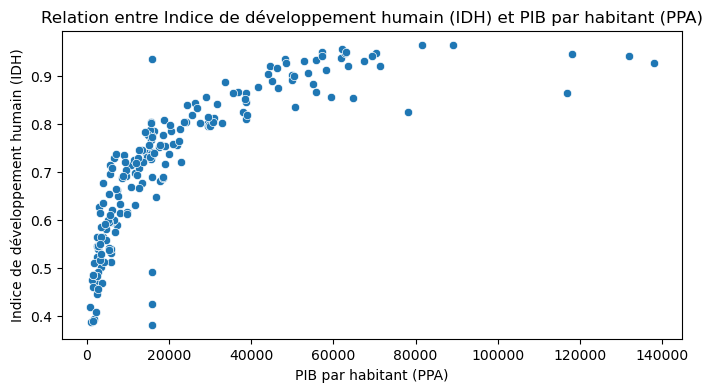

In [74]:
# Relation entre IDH et PIB par habitant (PPA)
idh_col = "Indice de développement humain (IDH)"
plt.figure(figsize=(8, 4))
sns.scatterplot(x=data["PIB par habitant (PPA)"], y=data[idh_col])
plt.title(f"Relation entre {idh_col} et PIB par habitant (PPA)")
plt.xlabel("PIB par habitant (PPA)")
plt.ylabel(idh_col)
plt.show()

**Interprétations :**                                                                                                                             
Le graphique montre une relation positive et non linéaire entre l'Indice de Développement Humain (IDH) et le PIB par habitant (PPA). À mesure que le PIB par habitant augmente, l'IDH tend également à augmenter.                                                                     
Le PIB par habitant est un facteur clé du développement humain, mais son influence décroît à des niveaux très élevés, probablement parce que d'autres facteurs (éducation, santé, etc.) deviennent déterminants.                                       

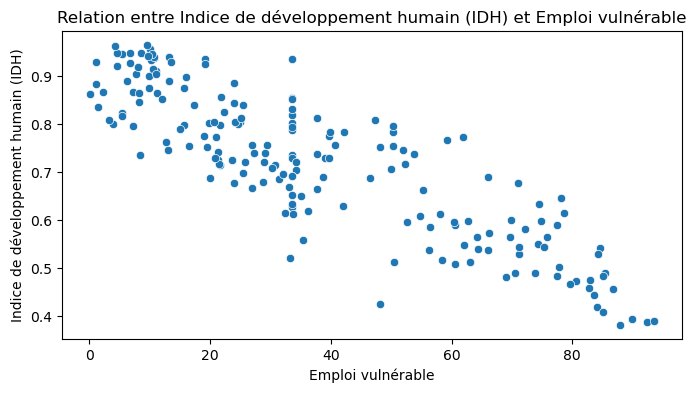

In [77]:
# Relation entre IDH et Emploi vulnérable
plt.figure(figsize=(8, 4))
sns.scatterplot(x=data["Emploi vulnérable"], y=data[idh_col])
plt.title(f"Relation entre {idh_col} et Emploi vulnérable")
plt.xlabel("Emploi vulnérable")
plt.ylabel(idh_col)
plt.show()

**Interprétations :**                                                                                                                                  
Ce graphique montre une relation négative entre l'IDH et le pourcentage d'emplois vulnérables. Lorsque la proportion d'emplois vulnérables diminue, l'IDH augmente.                                                                                                                  
Les pays avec un faible taux d'emplois vulnérables (secteurs informels ou précaires) tendent à avoir un meilleur développement humain, probablement grâce à des emplois plus stables et formels qui favorisent la sécurité économique et sociale.

C:\Users\dell\AppData\Local\Temp\ipykernel_2812\2149144628.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["Niveau de développement"], palette="viridis")


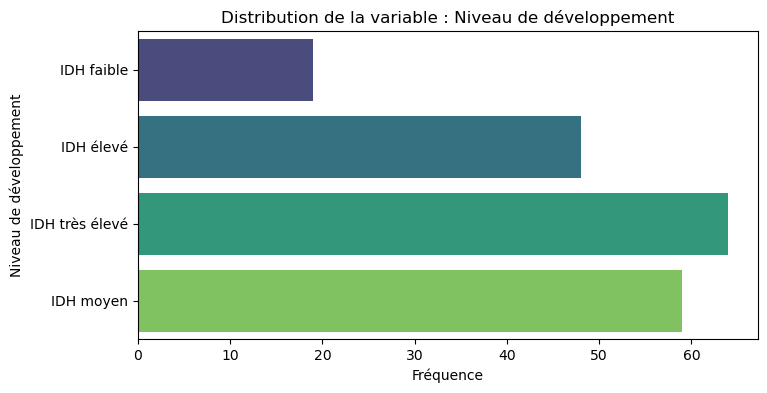

In [80]:
# Distribution de la variable : Niveau de développement
plt.figure(figsize=(8, 4))
sns.countplot(y=data["Niveau de développement"], palette="viridis")
plt.title("Distribution de la variable : Niveau de développement")
plt.xlabel("Fréquence")
plt.ylabel("Niveau de développement")
plt.show()

**Interprétations :**                                                                                                                             
La catégorie IDH très élevé regroupe le plus grand nombre de pays, suivie par IDH moyen et IDH élevé.                                                 
La catégorie IDH faible contient le moins de pays.                                                                                    
Cela suggère que la majorité des pays se situent dans les niveaux moyens à très élevés de développement humain, avec relativement peu de pays dans la catégorie la plus faible.

C:\Users\dell\AppData\Local\Temp\ipykernel_2812\3676045824.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["Région géographique"], palette="viridis")


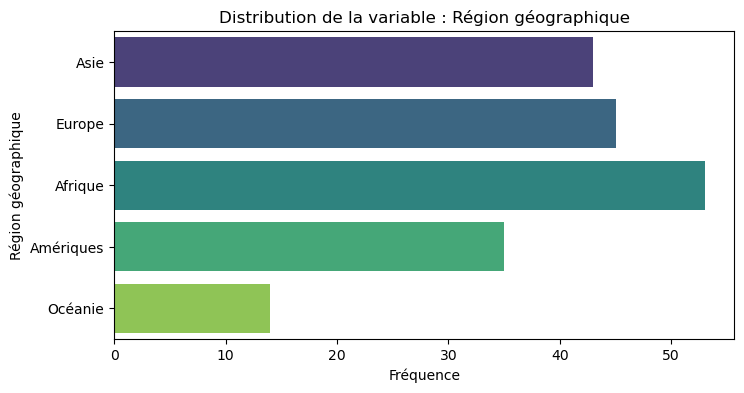

In [83]:
# Distribution de la variable : Région géographique
plt.figure(figsize=(8, 4))
sns.countplot(y=data["Région géographique"], palette="viridis")
plt.title("Distribution de la variable : Région géographique")
plt.xlabel("Fréquence")
plt.ylabel("Région géographique")
plt.show()

**Interprétations :**                                                                                                                              
L'Afrique et l'Europe comptent le plus grand nombre de pays représentés dans l'échantillon.                                                           
L'Asie et les Amériques ont une représentation intermédiaire.                                                                               
L'Océanie est la région avec le plus faible nombre de pays dans l'échantillon.                                                                 
La répartition des données par région géographique semble cohérente avec le nombre total de pays par continent.

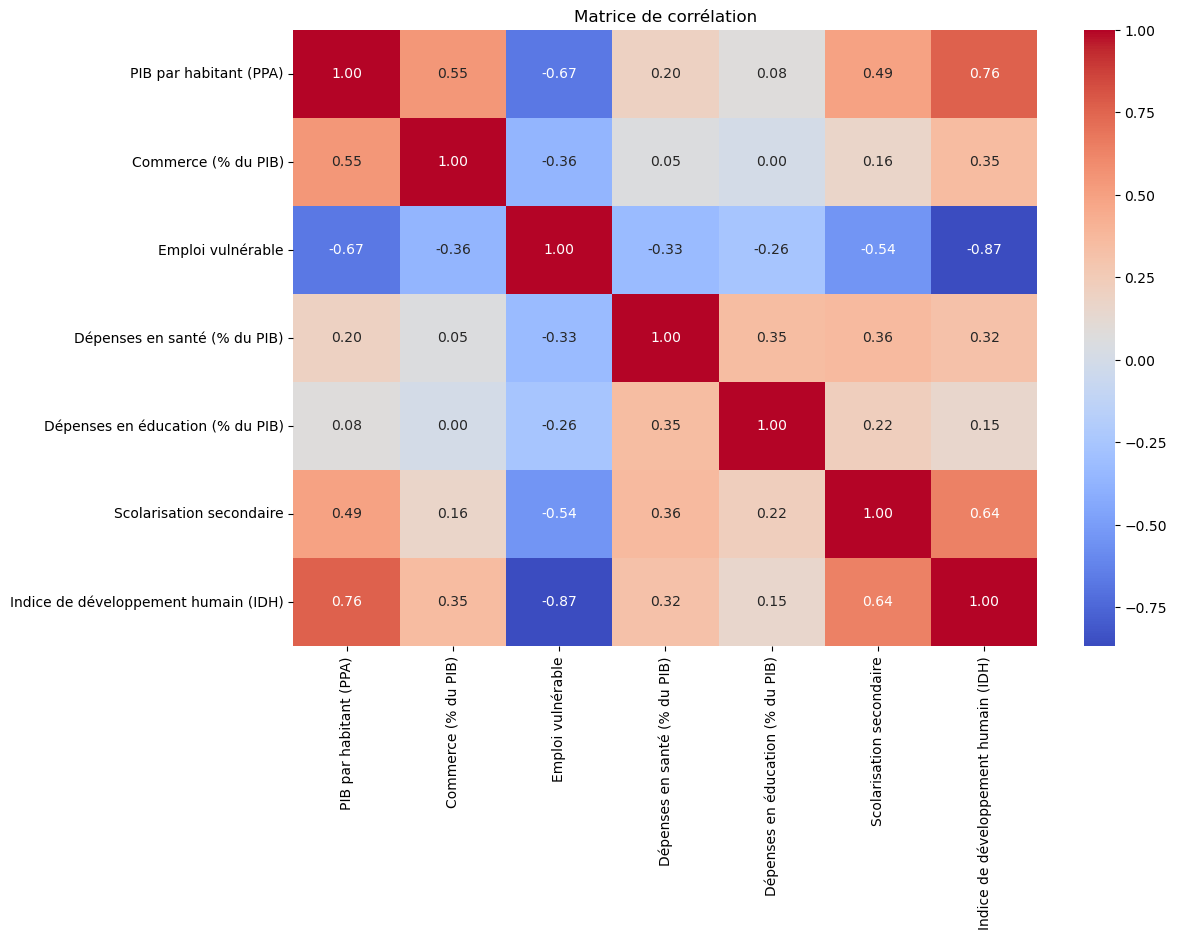

In [62]:
# Matrice de corrélation
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
corr_matrix = data[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corrélation")
plt.show()

**intérprétations :**                                                                                                                                  
L'IDH est fortement influencé par le PIB par habitant et négativement par l'emploi vulnérable. Les dépenses en santé et la scolarisation secondaire ont également une contribution notable, bien que leurs corrélations soient plus faibles. Cela souligne l'importance des facteurs économiques et sociaux dans le développement humain.

### Analyse de données

#### Analyse de la Relation entre le Taux de Scolarisation et l'Indice de Développement Humain (IDH) à l'aide de
#### la Régression Linéaire

In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_white
from scipy.stats import shapiro


# Charger le dataset
file_path = 'final_data.csv'
data = pd.read_csv(file_path)

# Renommer les colonnes pour simplifier l'accès
data.rename(columns={
    'PIB par habitant (PPA)': 'PIB',
    'Commerce (% du PIB)': 'Commerce_PIB',
    'Emploi vulnérable': 'Emploi_Vulnerable',
    'Dépenses en santé (% du PIB)':'Depenses_Sante',
    'Dépenses en éducation (% du PIB)': 'Depenses_Education',
    'Scolarisation secondaire': 'Scolarisation',
    'Indice de développement humain (IDH)': 'IDH',
    'Niveau de développement': 'Niveau_Developpement',
    'Région géographique': 'Region'
}, inplace=True)

# Vérifier les nouvelles colonnes
print(data.columns)

Index(['Pays', 'PIB', 'Commerce_PIB', 'Emploi_Vulnerable', 'Depenses_Sante',
       'Depenses_Education', 'Scolarisation', 'IDH', 'Niveau_Developpement',
       'Region'],
      dtype='object')


Étude 1 : IDH vs Scolarisation


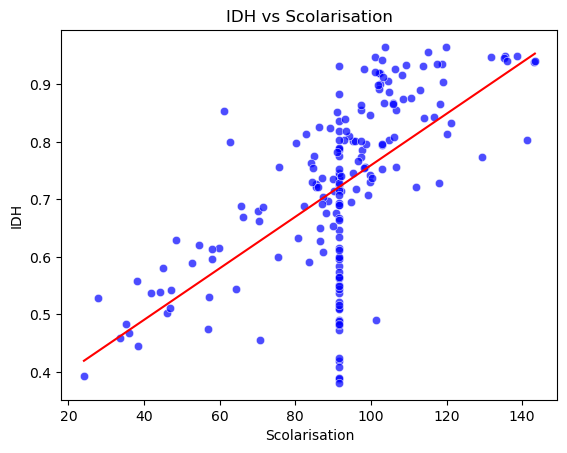

R-squared : 0.4069
Test de Durbin-Watson : 1.92
Test de White (Statistique): 8.62, p-value: 0.0134
Test de Shapiro-Wilk (Statistique): 0.95, p-value: 0.0000


In [67]:
X = data[['Scolarisation']]
y = data['IDH']

# Ajouter une constante
X = sm.add_constant(X)

# Ajuster le modèle
model_scolarisation = sm.OLS(y, X).fit()

# Résultats
print("Étude 1 : IDH vs Scolarisation")
# Visualisation avec une droite rouge simple
sns.scatterplot(x='Scolarisation', y='IDH', data=data, color='blue', alpha=0.7)
sns.lineplot(x=data['Scolarisation'], y=model_scolarisation.predict(X), color='red')
plt.title("IDH vs Scolarisation")
plt.show()

# Tests de régression
# Afficher R-squared
print(f"R-squared : {model_scolarisation.rsquared:.4f}")

# Test de Durbin-Watson
dw_test = sm.stats.stattools.durbin_watson(model_scolarisation.resid)
print(f"Test de Durbin-Watson : {dw_test:.2f}")

# Test de White pour l'hétéroscédasticité
white_test = het_white(model_scolarisation.resid, X)
print(f"Test de White (Statistique): {white_test[0]:.2f}, p-value: {white_test[1]:.4f}")

# Test de normalité de Shapiro-Wilk
shapiro_test = shapiro(model_scolarisation.resid)
print(f"Test de Shapiro-Wilk (Statistique): {shapiro_test.statistic:.2f}, p-value: {shapiro_test.pvalue:.4f}")

**interprétations :**
- La droite de régression montre une relation positive entre la scolarisation et l'IDH. Cela signifie que, généralement, lorsque le niveau de -scolarisation augmente, l'Indice de Développement Humain (IDH) tend également à augmenter.                                                          
  Bien que la tendance générale soit claire, il y a une certaine dispersion autour de la droite de régression, ce qui indique qu'il existe d'autres facteurs influençant l'IDH.                                                                                                                            
- **R² = 0.4069** => Environ 40,69 % de la variance de l'IDH est expliquée par la variable "Scolarisation", Ce R² est modéré. La scolarisation est un facteur important pour expliquer l'IDH, mais il y a d'autres variables non incluses dans ce modèle qui influencent l'IDH.
- **Test de Durbin-Watson = 1.92** => Une valeur proche de 2 indique une absence d'autocorrélation significative. Ici, il n'y a pas de problème d'autocorrélation dans les résidus
- **Test de White (Statistique = 8.62, p-value = 0.0134)** => Avec une p-value de 0.0134 (< 0.05), on rejette l'hypothèse nulle d'homoscédasticité. Cela indique qu'il y a un problème d'hétéroscédasticité dans le modèle, ce qui peut affecter la validité des estimations.
- **Test de Shapiro-Wilk (Statistique = 0.95, p-value = 0.0000)** => Avec une p-value de 0.0000 (< 0.05), on rejette l'hypothèse nulle de normalité. Les résidus ne suivent pas une distribution normale, ce qui peut affecter les tests statistiques du modèle.

#### Analyse de l'Impact de l'Emploi Vulnérable sur l'Indice de Développement Humain (IDH)

Étude 2 : IDH vs Emploi vulnérable


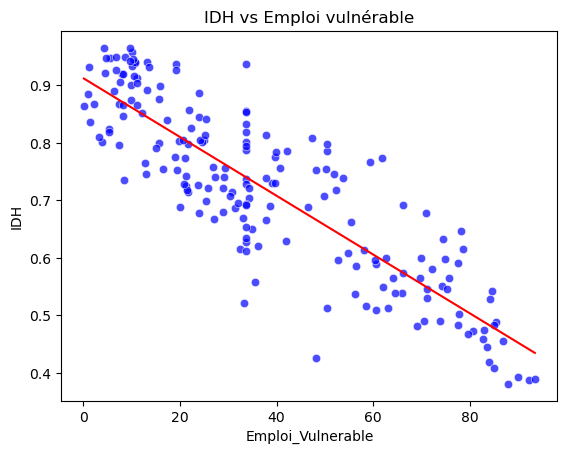

R-squared : 0.7505
Test de Durbin-Watson : 2.01
Test de White (Statistique): 11.04, p-value: 0.0040
Test de Shapiro-Wilk (Statistique): 0.99, p-value: 0.2503


In [69]:
X = data[['Emploi_Vulnerable']]
y = data['IDH']

# Ajouter une constante
X = sm.add_constant(X)

# Ajuster le modèle
model_emploi = sm.OLS(y, X).fit()

# Résultats
print("Étude 2 : IDH vs Emploi vulnérable")

# Visualisation avec une droite rouge simple
sns.scatterplot(x='Emploi_Vulnerable', y='IDH', data=data, color='blue', alpha=0.7)
sns.lineplot(x=data['Emploi_Vulnerable'], y=model_emploi.predict(X), color='red')
plt.title("IDH vs Emploi vulnérable")
plt.show()

# Tests de régression
# Afficher R-squared
print(f"R-squared : {model_emploi.rsquared:.4f}")

# Test de Durbin-Watson
dw_test = sm.stats.stattools.durbin_watson(model_emploi.resid)
print(f"Test de Durbin-Watson : {dw_test:.2f}")

# Test de White pour l'hétéroscédasticité
white_test = het_white(model_emploi.resid, X)
print(f"Test de White (Statistique): {white_test[0]:.2f}, p-value: {white_test[1]:.4f}")

# Test de normalité de Shapiro-Wilk
shapiro_test = shapiro(model_emploi.resid)
print(f"Test de Shapiro-Wilk (Statistique): {shapiro_test.statistic:.2f}, p-value: {shapiro_test.pvalue:.4f}")


**interprétations :**
- La droite de régression montre une relation négative entre l'emploi vulnérable et l'IDH. Cela signifie que, généralement, lorsque le pourcentage d'emploi vulnérable augmente, l'Indice de Développement Humain (IDH) diminue.                                                                   
  La dispersion des points autour de la droite est relativement faible, indiquant une forte corrélation entre les deux variables.                   
- **R² = 0.7505** => Environ 75,05 % de la variance de l'IDH est expliquée par la variable "Emploi vulnérable", Ce R² est élevé, ce qui indique que l'emploi vulnérable est un facteur déterminant pour expliquer l'IDH.
- **Test de Durbin-Watson = 2.01** => Une valeur proche de 2 indique une absence d'autocorrélation significative. Ici, il n'y a pas de problème d'autocorrélation dans les résidus.
- **Test de White (Statistique = 11.04, p-value = 0.0040)** => Avec une p-value de 0.0040 (< 0.05), on rejette l'hypothèse nulle d'homoscédasticité. Cela indique qu'il y a un problème d'hétéroscédasticité dans le modèle, ce qui peut affecter la validité des estimations.
- **Test de Shapiro-Wilk (Statistique = 0.99, p-value = 0.2503)** => Avec une p-value de 0.2503 (> 0.05), on ne rejette pas l'hypothèse nulle de normalité. Les résidus suivent une distribution normale, ce qui valide l'utilisation des tests statistiques.                                       

#### Analyse de la Relation Non Linéaire entre le PIB et l'Indice de Développement Humain (IDH) à l'aide d'une Régression Polynomiale

Coefficients du modèle : [ 0.00000000e+00  1.11855432e-05 -6.86970098e-11]
Ordonnée à l'origine (intercept) : 0.5283082693614046
R² (coefficient de détermination) : 0.67858560143119
Erreur quadratique moyenne (RMSE) : 0.07826748768070933


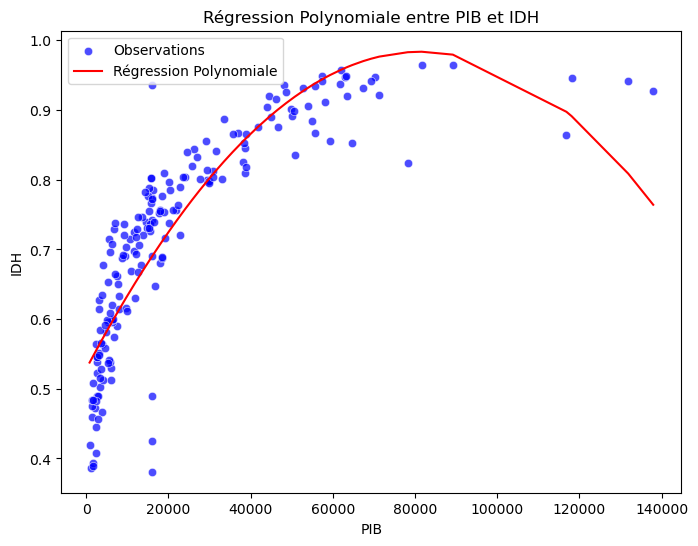

In [97]:
# Importer les bibliothèques nécessaires
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner les variables PIB et IDH
X_poly = data[['PIB']]  # Variable explicative (PIB)
y_poly = data['IDH']    # Variable cible (IDH)

# Créer des termes polynomiaux (ici, degré 2 par exemple)
poly = PolynomialFeatures(degree=2)
X_poly_transformed = poly.fit_transform(X_poly)

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_poly_transformed, y_poly, test_size=0.2, random_state=42)

# Ajuster le modèle de régression polynomiale
model_poly = LinearRegression()
model_poly.fit(X_train, y_train)

# Afficher les résultats du modèle
print(f"Coefficients du modèle : {model_poly.coef_}")
print(f"Ordonnée à l'origine (intercept) : {model_poly.intercept_}")

# Prédictions
y_pred = model_poly.predict(X_test)

# Calcul du R² (coefficient de détermination)
r2_score = model_poly.score(X_test, y_test)
print(f"R² (coefficient de détermination) : {r2_score}")

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Erreur quadratique moyenne (RMSE) : {rmse}")

# Visualisation des résultats
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_poly['PIB'], y=y_poly, color='blue', alpha=0.7, label="Observations")
sns.lineplot(x=X_poly['PIB'], y=model_poly.predict(poly.transform(X_poly)), color='red', label="Régression Polynomiale")
plt.title("Régression Polynomiale entre PIB et IDH")
plt.xlabel("PIB")
plt.ylabel("IDH")
plt.legend()
plt.show()

**interprétations :**                                                                                                                                 
Le modèle polynomial de degré 2 capture une relation non linéaire entre le PIB et l'IDH, avec une forme de U inversé. Cependant, le R² de 0.68 indique que le modèle n'explique qu'une partie de la variance de l'IDH, et le RMSE de 0.0783 montre une certaine erreur de prédiction. Cela suggère que le modèle pourrait être amélioré en considérant d'autres facteurs ou en utilisant des techniques plus avancées comme la régression Ridge.

#### Optimisation de la Relation Non Linéaire entre le PIB et l'Indice de Développement Humain (IDH) à l'aide de
#### la Régression Polynomiale Ridge

R² du modèle Ridge (standardisé): 0.813
Erreur quadratique moyenne (MSE) du modèle Ridge (standardisé): 0.004


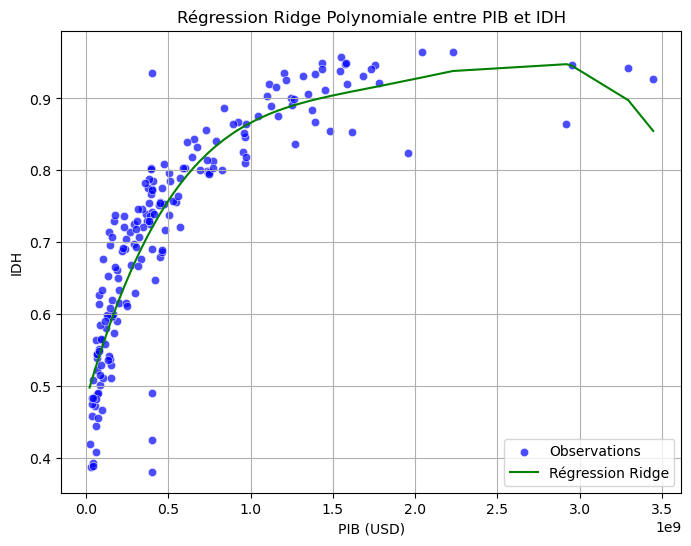

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Standardisation de la variable PIB
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['PIB']])

# Transformation polynomiale avec un degré plus élevé
poly = PolynomialFeatures(degree=4)
X_poly_scaled = poly.fit_transform(X_scaled)


# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y_poly, test_size=0.2, random_state=42)

# Réentraîner le modèle Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Prédictions
y_ridge_pred = ridge_model.predict(X_test)

# Évaluation des performances
ridge_r2 = r2_score(y_test, y_ridge_pred)
ridge_mse = mean_squared_error(y_test, y_ridge_pred)
print(f"R² du modèle Ridge (standardisé): {ridge_r2:.3f}")
print(f"Erreur quadratique moyenne (MSE) du modèle Ridge (standardisé): {ridge_mse:.3f}")

# Visualisation des résultats
# Générer une échelle inverse pour revenir aux valeurs originales du PIB
X_original = scaler.inverse_transform(data[['PIB']])

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_original.ravel(), y=y_poly, color='blue', alpha=0.7, label="Observations")
sns.lineplot(x=X_original.ravel(), y=ridge_model.predict(X_poly_scaled), color='green', label="Régression Ridge")
plt.title("Régression Ridge Polynomiale entre PIB et IDH")
plt.xlabel("PIB (USD)")
plt.ylabel("IDH")
plt.legend()
plt.grid(True)
plt.show()

**interprétations :**                                                                                                                                 
- **Effet de la régularisation Ridge :**                                                                                                         
Ridge pénalise les coefficients des termes polynomiaux (en particulier ceux de degré élevé), réduisant leur contribution excessive au modèle. Cela permet de limiter le surajustement, surtout dans les zones où les données sont moins nombreuses.
Le modèle reste globalement lisse et stable, en évitant des oscillations extrêmes.                                                                
Par exemple, dans les régions avec très peu de PIB ou des PIB très élevés, Ridge limite l'influence des outliers.
- **R² (coefficient de détermination) : 0.813** => Cela signifie que 81.3% de la variance de l'IDH (Indice de Développement Humain) est expliquée par le modèle en fonction du PIB. C'est une bonne performance, indiquant que le modèle capture efficacement la relation entre les variables.             
- **Erreur quadratique moyenne (MSE) : 0.004** => Cette valeur indique que les prédictions du modèle diffèrent en moyenne des valeurs réelles d'IDH par 0.004 (en termes de carré des erreurs). Cela confirme la précision du modèle dans cette application.

#### L'Indice de Développement Humain (IDH) varie-t-il significativement selon les régions géographiques étudiées, indiquant des disparités de développement entre elles ?

Valeur de la statistique F : 65.0528627264025
Valeur p : 2.896418000899607e-34
Il existe une différence significative entre les moyennes de l'IDH des régions géographiques.


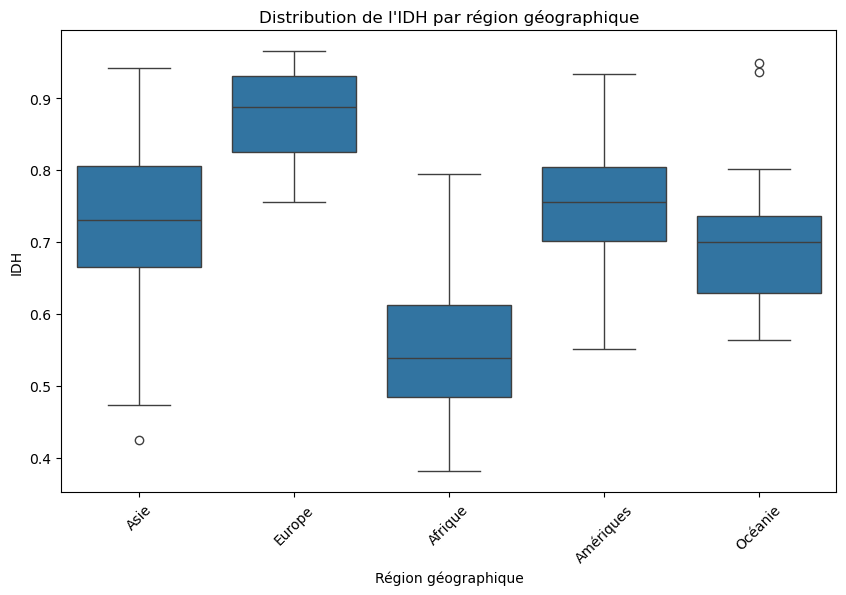

In [101]:
import scipy.stats as stats

# Effectuer le test ANOVA pour comparer l'IDH moyen entre les différentes régions
anova_result = stats.f_oneway(
    *(data[data['Region'] == region]['IDH'] for region in data['Region'].unique())
)

# Afficher le résultat du test ANOVA
print(f"Valeur de la statistique F : {anova_result.statistic}")
print(f"Valeur p : {anova_result.pvalue}")

# Conclusion du test
if anova_result.pvalue < 0.05:
    print("Il existe une différence significative entre les moyennes de l'IDH des régions géographiques.")
else:
    print("Il n'y a pas de différence significative entre les moyennes de l'IDH des régions géographiques.")

# Visualisation 1: Boxplot pour comparer la distribution de l'IDH entre les régions
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='IDH', data=data)
plt.title('Distribution de l\'IDH par région géographique')
plt.xlabel('Région géographique')
plt.ylabel('IDH')
plt.xticks(rotation=45)
plt.show()

**interprétations :**                                                                                                                                 
- L'Europe et les Amériques ont tendance à avoir des IDH plus élevés et moins variables.
- L'Afrique a les IDH les plus bas et une plus grande dispersion.
- L'Asie et l'Océanie présentent des situations intermédiaires.
- **Statistique F = 65.05** => Une valeur F élevée indique qu'il existe une grande différence entre les moyennes des groupes par rapport à la variabilité au sein de chaque groupe.
- **Valeur p = 2.9e-34** => Une valeur p très faible (bien inférieure à 0.05) montre que les différences observées entre les régions géographiques sont hautement significatives.
- Cela suggère que l'IDH varie de manière notable d'une région à l'autre, ce qui mérite d'être exploré davantage pour comprendre les facteurs sous-jacents à ces différences.     

#### Quels facteurs économiques, sociaux et éducatifs peuvent être synthétisés pour mieux comprendre leur impact sur l’IDH ? ?

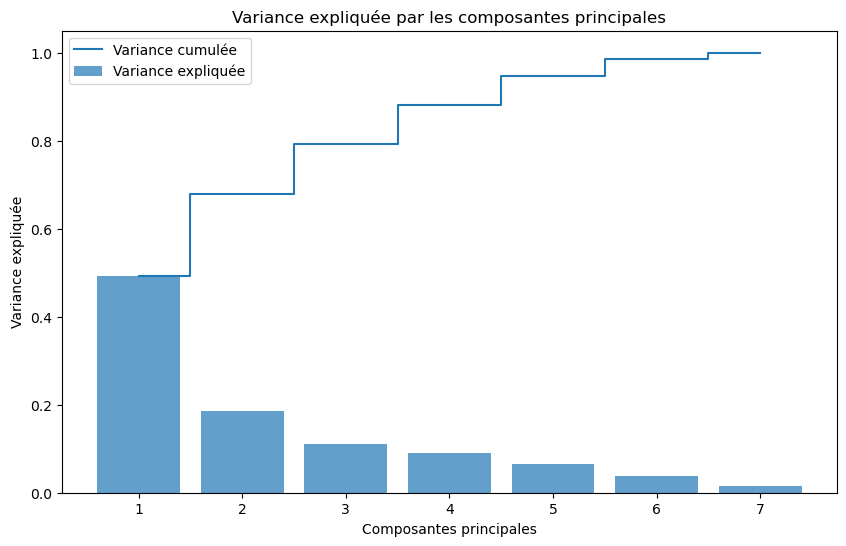

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Sélection des colonnes numériques pour l'ACP
numerical_columns = [
    'PIB',
    'Commerce_PIB',
    'Emploi_Vulnerable',
    'Depenses_Sante',
    'Depenses_Education',
    'Scolarisation',
    'IDH'
]

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[numerical_columns])

# Application de l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_

# Visualisation de la variance expliquée
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Variance expliquée')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Variance cumulée')
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par les composantes principales')
plt.legend()
plt.show()

**intérprétations :**                                                                                                                                 
Le graphique montre que les 2 premières composantes principales expliquent environ 70% de la variance totale. Cela indique que ces composantes capturent une grande partie de l'information contenue dans les données initiales.

In [7]:
# Affichage des composantes principales
pca_components = pd.DataFrame(pca.components_, columns=numerical_columns)
pca_components.head()

,PIB,Commerce_PIB,Emploi_Vulnerable,Depenses_Sante,Depenses_Education,Scolarisation,IDH
0,0.451145,0.273873,-0.477997,0.253452,0.167025,0.395511,0.494385
1,-0.290182,-0.458060,0.021405,0.537621,0.615854,0.173862,-0.083523
2,0.053303,0.680547,0.084815,0.082279,0.540938,-0.413323,-0.237911
3,-0.023746,0.238727,0.194045,0.782170,-0.527628,-0.039186,-0.114347
4,-0.065523,0.306333,0.436458,-0.158738,0.063972,0.785122,-0.256251


- **Composante principale 1 (CP1) :**                                                                                                             
Variables principales : PIB (+), Scolarisation (+), IDH (+), et Emploi vulnérable (-).                                                               
**Interprétation :** Cette composante semble capturer le niveau de développement socio-économique, où un PIB élevé, une meilleure scolarisation, et un IDH élevé sont associés à un emploi vulnérable plus faible.
- **Composante principale 2 (CP2) :**                                                                                                                  
Variables principales : Commerce (+), Dépenses en santé (+), et Dépenses en éducation (+).                                                         
**Interprétation :** Cette composante est liée aux investissements dans le commerce, la santé et l'éducation, sans lien direct avec le niveau d'IDH.  

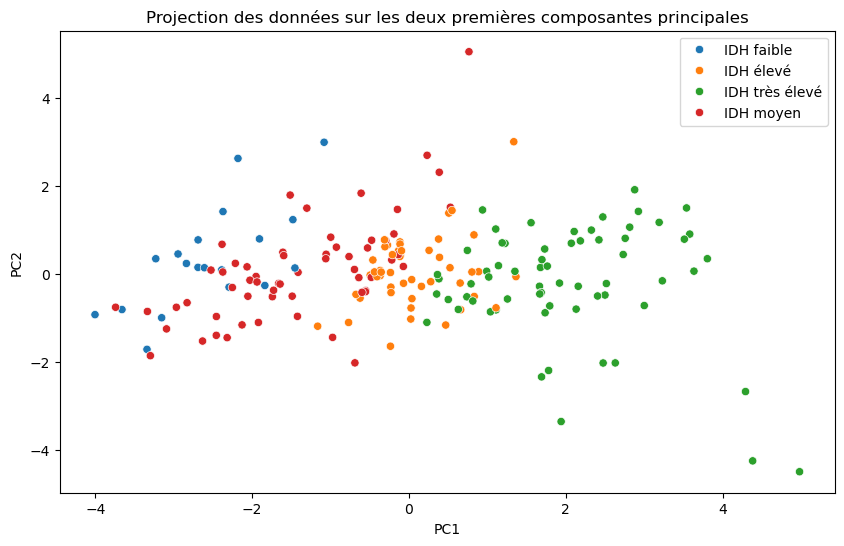

In [10]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Sélectionner les colonnes numériques
numerical_data = data.select_dtypes(include='float64')

# 2. Normaliser les données
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numerical_data)

# 3. Appliquer l'ACP
pca = PCA()
pca_data = pca.fit_transform(normalized_data)

# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_

# Création d'un DataFrame des deux premières composantes
pca_df = pd.DataFrame(data=pca_data[:, :2], columns=['PC1', 'PC2'])
pca_df['Pays'] = data['Pays']
pca_df['Niveau_Developpement'] = data['Niveau_Developpement']


# Visualisation des données projetées sur les deux premières composantes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=data['Niveau_Developpement'])
plt.title('Projection des données sur les deux premières composantes principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

**intérprétations :**                                                                                                                                 
La projection des données sur les deux premières composantes principales montre que les pays sont répartis en fonction de leur niveau de développement humain, avec une séparation claire entre les pays à IDH très élevé/élevé et ceux à IDH faible/moyen. Cela suggère que les facteurs économiques, sociaux et éducatifs analysés sont des déterminants importants de l'IDH et peuvent guider des décisions stratégiques pour améliorer le développement humain.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


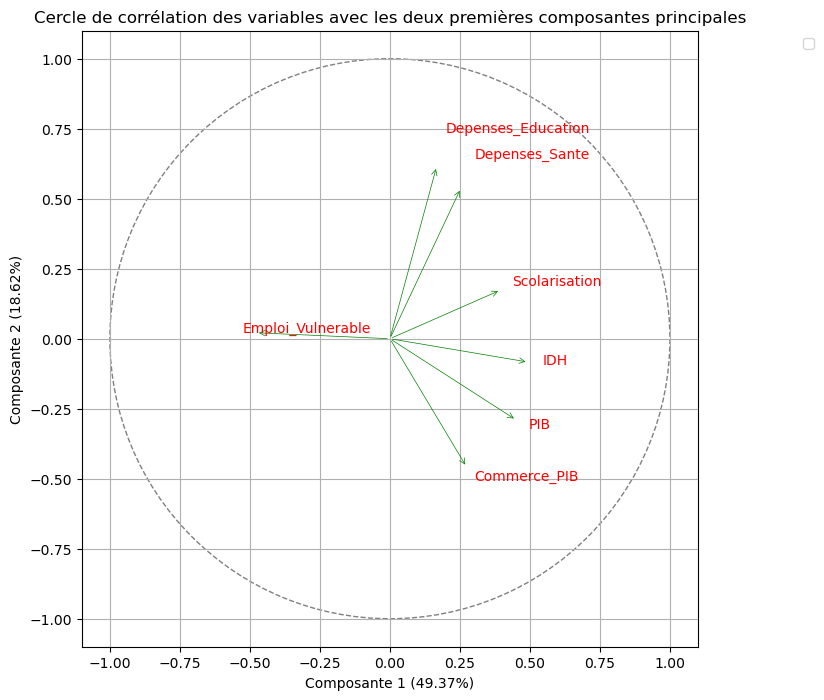

In [13]:
# Calculer les corrélations entre les variables restantes et les composantes principales
correlation_matrix = pd.DataFrame(pca.components_[:2], columns=numerical_data.columns, index=['PC1', 'PC2'])

# Visualisation du cercle de corrélation
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Tracer les vecteurs avec des flèches vertes fines
for i, var in enumerate(numerical_data.columns):
    ax.annotate('', xy=(correlation_matrix.loc['PC1', var], correlation_matrix.loc['PC2', var]), 
                xytext=(0, 0), 
                arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->', linewidth=0.5))

# Ajouter des labels pour chaque vecteur en rouge, avec un décalage pour éviter les chevauchements près du cercle
for i, var in enumerate(numerical_data.columns):
    # Décalage des labels en fonction de la position des vecteurs
    if abs(correlation_matrix.loc['PC1', var]) > 0.5 or abs(correlation_matrix.loc['PC2', var]) > 0.5:
        ax.text(correlation_matrix.loc['PC1', var] * 1.2, correlation_matrix.loc['PC2', var] * 1.2, var, color='red')
    else:
        ax.text(correlation_matrix.loc['PC1', var] * 1.1, correlation_matrix.loc['PC2', var] * 1.1, var, color='red')

# Ajouter un cercle unitaire pour mieux visualiser les corrélations
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

# Configurations de la visualisation
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
plt.xlabel(f'Composante 1 ({explained_variance[0] * 100:.2f}%)')
plt.ylabel(f'Composante 2 ({explained_variance[1] * 100:.2f}%)')
ax.set_title('Cercle de corrélation des variables avec les deux premières composantes principales')
ax.set_aspect('equal')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

**interprétations :**                                                                                                                                 
- **Facteurs économiques :**                                                                                                                           
Le PIB par habitant est fortement lié à l’IDH, confirmant que la richesse économique est essentielle au développement humain. Le commerce joue un rôle secondaire.                                                                                                                                       
- **Facteurs sociaux :**
Un emploi vulnérable élevé est opposé à l’IDH, indiquant que réduire la précarité économique est crucial pour améliorer le développement humain.       
- **Facteurs éducatifs :**
La scolarisation secondaire est un levier majeur pour l’IDH. Les dépenses en éducation contribuent modérément, leur impact dépendant de leur        efficacité.                                                                                                                                            
- **Facteurs liés à la santé :**                                                                                                                       
Les dépenses en santé soutiennent l’IDH mais nécessitent des efforts complémentaires pour maximiser leur impact.                                       

- L’IDH est principalement influencé par le PIB, la réduction de l’emploi vulnérable, et la scolarisation, tandis que les investissements dans la santé et l’éducation jouent un rôle de soutien.

## 4. les données du dataset OCDE :

- Ce dataset contient des données socio-économiques et démographiques pour différents pays membres l'OCDE.
- Il fournit des indicateurs variés pour comparer les performances économiques, sociales et fiscales de ces pays.
- Chaque ligne représente un pays, et les colonnes contiennent des données sur des aspects comme les dépenses publiques, la fiscalité...

**Explication des colonnes :**
- **Pays :** Le nom du pays observé.
- **Dépenses des administrations publiques :** Les dépenses totales des gouvernements en pourcentage du PIB.
- **Espérance de vie à la naissance :** L'espérance de vie moyenne, en années, d'une personne à sa naissance.
- **Heures travaillées :** Le nombre moyen d'heures travaillées par an par un travailleur(Heures/travailleur).
- **Impôt sur le revenu des personnes physiques :** Le pourcentage moyen d'impôts sur le revenu des individus, exprimé en % du PIB.
- **Impôt sur les biens et services :** Le pourcentage moyen d'impôts prélevés sur la consommation (TVA, taxes sur les biens et services), éxprimé en % du PIB.
- **Impôt sur les bénéfices des sociétés :** Le pourcentage d'imposition sur les bénéfices des entreprises, en % du PIB.
- **Impôt sur les salaires :** Les prélèvements obligatoires sur les salaires des travailleurs, exprimés en pourcentage.
- **Indices des niveaux de prix :** Un indice comparatif des niveaux de prix (valeur de 100 pour la moyenne des pays de référence).
- **Informatique à domicile :** Indicateur de l'accès aux ordinateurs/informatique à domicile, en % de tous les ménages.
- **Population active :** Nombre total de personnes dans la population active , en milliers de personnes.
- **Population d'âge actif :** Population en âge de travailler, en % de la population.
- **Produit intérieur brut (PIB) :** Valeur totale des biens et services produits par un pays, en Millions de dollars US.
- **Recettes des administrations publiques :** Les revenus totaux des gouvernements (en pourcentage du PIB).
- **Recettes fiscales :** Les revenus fiscaux (impôts, taxes) collectés par l'État (souvent en pourcentage du PIB).
- **Revenu national net :** La somme des revenus perçus par les résidents d'un pays en Millions de dollars US.
- **Rémunération horaire :** Salaire moyen par heure travaillée, en % du taux de croissance annuel.
- **Taux d'accès Internet :** Pourcentage de la population ayant accès à Internet, en % de tous les ménages.
- **Taux d'emploi :** le taux de la population active qui est employée, en Milliers de personnes
- **Taux de mortalité infantile :** Nombre de décès d'enfants pour 1 000 naissances vivantes.
- **Taux de pauvreté :** taux de la population vivant sous le seuil de pauvreté, e Ratio
- **Taux de suicide :** Nombre de suicides pour 100 000 habitants.


In [ ]:
df = pd.read_csv('ocde_DATA.csv')
df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,LOCATION,Pays,INDICATOR,Indicateur,SUBJECT,Sujet,...,OBS_VALUE,Observation Value,OBS_STATUS,Observation Status,UNIT_MEASURE,Unit of Measures,UNIT_MULT,Multiplier,BASE_PER,Base reference period
0,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,AUS,Australie,NNI,Revenu national net,TOT,Total,...,1.303851e+06,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,HUN,Hongrie,GGEXP,Dépenses des administrations publiques,TOT,Total,...,4.835402e+01,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,LUX,Luxembourg,TAXPAYROLL,Impôt sur les salaires,TOT,Total,...,0.000000e+00,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,GRC,Grèce,TAXPAYROLL,Impôt sur les salaires,TOT,Total,...,0.000000e+00,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,GRC,Grèce,TAXPAYROLL,Impôt sur les salaires,TOT,Total,...,0.000000e+00,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
colonnes_a_supprimer = [
    'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'LOCATION',
    'SUBJECT', 'Sujet', 'FREQUENCY','UNIT_MEASURE','INDICATOR','MEASURE',
    'Fréquence', 'TIME_PERIOD','Temps','Observation Value','OBS_STATUS',
    'Observation Status', 'Unit of Measures', 'UNIT_MULT',
    'Multiplier', 'BASE_PER', 'Base reference period','Unit multiplier'
]

# Supprimer les colonnes inutiles
df_cleaned = df.drop(columns=colonnes_a_supprimer, errors='ignore')


# Sauvegarder le dataset nettoyé
df_cleaned.to_csv('ocd_DATA_nettoyé.csv', index=False)
df_cleaned.head()


,Pays,Indicateur,Mesure,OBS_VALUE
0,Australie,Revenu national net,Millions de dollars US,1.303851e+06
1,Hongrie,Dépenses des administrations publiques,% du PIB,4.835402e+01
2,Luxembourg,Impôt sur les salaires,% du PIB,0.000000e+00
3,Grèce,Impôt sur les salaires,% des recettes fiscales,0.000000e+00
4,Grèce,Impôt sur les salaires,% du PIB,0.000000e+00


In [ ]:
# Renommer les colonnes
df_cleaned = df_cleaned.rename(columns={
    'OBS_VALUE': 'Valeur'
})

# Afficher un aperçu des données avec les nouvelles colonnes
print(df_cleaned.head())

# Sauvegarder le dataset avec les nouvelles colonnes
df_cleaned.to_csv('ocd_DATA_nettoyé_Renommé.csv', index=False)


         Pays                              Indicateur  \
0   Australie                     Revenu national net   
1     Hongrie  Dépenses des administrations publiques   
2  Luxembourg                  Impôt sur les salaires   
3       Grèce                  Impôt sur les salaires   
4       Grèce                  Impôt sur les salaires   

                    Mesure        Valeur  
0   Millions de dollars US  1.303851e+06  
1                 % du PIB  4.835402e+01  
2                 % du PIB  0.000000e+00  
3  % des recettes fiscales  0.000000e+00  
4                 % du PIB  0.000000e+00  


In [ ]:
# Chargement du dataset
df = pd.read_csv('ocd_DATA_nettoyé_Renommé.csv')

# Pivotement tout en gardant les premières valeurs
df_pivot = df.pivot_table(index='Pays', columns='Indicateur', values='Valeur', aggfunc='first')

# Réinitialiser l'index pour avoir une structure de DataFrame propre
df_pivot.reset_index(inplace=True)

# Sauvegarder le résultat
df_pivot.to_csv('DATA_OCDE_transformed.csv', index=False)
df_pivot.head()

Indicateur,Pays,Dépenses des administrations publiques,Espérance de vie à la naissance,Heures travaillées,Impôt sur le revenu des personnes physiques,Impôt sur les biens et services,Impôt sur les bénéfices des sociétés,Impôt sur les salaires,Indices des niveaux de prix,Informatique à domicile,...,Recettes fiscales,Revenu national net,Rémunération horaire,Stocks d'IDE entrant par secteur d’activité,Stocks d'IDE sortant par secteur d’activité,Taux d'accès Internet,Taux d'emploi,Taux de mortalité infantile,Taux de pauvreté,Taux de suicide
0,Allemagne,51.030394,80.8,1340.165629,26.642,10.465,5.997,0.000,100.0,NaN,...,1682.006,5.227903e+04,0.591476,100.0,100.0,91.8750,75.600,3.0,NaN,NaN
1,Australie,41.055219,83.3,1694.799343,39.003,6.863,6.636,1.274,125.0,NaN,...,29.482,1.303851e+06,NaN,100.0,100.0,NaN,13045.730,3.3,NaN,12.4
2,Autriche,33627.870000,81.3,1439.093920,9.700,26.743,2.750,2.794,103.0,NaN,...,43.284,1.055664e+02,119.639418,100.0,100.0,95.0006,72.400,2.7,0.098,11.0
3,Belgique,32607.620000,81.9,1525.815277,26.686,25.236,8.983,0.002,100.0,NaN,...,252.689,5.886212e+05,0.415288,100.0,100.0,92.2999,65.300,2.9,0.078,NaN
4,Canada,24748.550000,81.6,1685.000000,36.319,7.273,13.482,2.211,114.0,NaN,...,679.059,1.150369e+02,117.694806,100.0,100.0,92.8000,73.475,NaN,0.105,NaN


In [ ]:
colonnes_a_supprimer = [
    'Stocks d\'IDE entrant par secteur d\’activité',
    'Stocks d\'IDE sortant par secteur d\’activité'
]

# Supprimer les colonnes inutiles
df_cleaned = df_pivot.drop(columns=colonnes_a_supprimer, errors='ignore')


# Sauvegarder le dataset nettoyé
df_cleaned.to_csv('DATA_OCDE_transformed2.csv', index=False)

In [ ]:
df = pd.read_csv('DATA_OCDE_transformed2.csv')
df.head()


,Pays,Dépenses des administrations publiques,Espérance de vie à la naissance,Heures travaillées,Impôt sur le revenu des personnes physiques,Impôt sur les biens et services,Impôt sur les bénéfices des sociétés,Impôt sur les salaires,Indices des niveaux de prix,Informatique à domicile,...,Produit intérieur brut (PIB),Recettes des administrations publiques,Recettes fiscales,Revenu national net,Rémunération horaire,Taux d'accès Internet,Taux d'emploi,Taux de mortalité infantile,Taux de pauvreté,Taux de suicide
0,Allemagne,51.030394,80.8,1340.165629,26.642,10.465,5.997,0.000,100.0,NaN,...,6.193981e+04,27944.470000,1682.006,5.227903e+04,0.591476,91.8750,75.60000,3.0,NaN,NaN
1,Australie,41.055219,83.3,1694.799343,39.003,6.863,6.636,1.274,125.0,NaN,...,1.649096e+06,22017.520000,29.482,1.303851e+06,NaN,NaN,74.92894,3.3,NaN,12.4
2,Autriche,33627.870000,81.3,1439.093920,9.700,26.743,2.750,2.794,103.0,NaN,...,5.679881e+05,50.391071,43.284,1.055664e+02,119.639418,95.0006,72.40000,2.7,0.098,11.0
3,Belgique,32607.620000,81.9,1525.815277,26.686,25.236,8.983,0.002,100.0,NaN,...,6.207716e+04,29381.090000,252.689,5.886212e+05,0.415288,92.2999,65.30000,2.9,0.078,NaN
4,Canada,24748.550000,81.6,1685.000000,36.319,7.273,13.482,2.211,114.0,NaN,...,2.126696e+06,42.293369,679.059,1.150369e+02,117.694806,92.8000,73.47500,NaN,0.105,NaN


In [ ]:
print(df.columns)

Index(['Pays', 'Dépenses des administrations publiques',
       'Espérance de vie à la naissance', 'Heures travaillées',
       'Impôt sur le revenu des personnes physiques',
       'Impôt sur les biens et services',
       'Impôt sur les bénéfices des sociétés', 'Impôt sur les salaires',
       'Indices des niveaux de prix', 'Informatique à domicile',
       'Population active', 'Population d'âge actif',
       'Produit intérieur brut (PIB)',
       'Recettes des administrations publiques', 'Recettes fiscales',
       'Revenu national net', 'Rémunération horaire', 'Taux d'accès Internet',
       'Taux d'emploi', 'Taux de mortalité infantile', 'Taux de pauvreté',
       'Taux de suicide'],
      dtype='object')


**Analyse exploratoire :**

In [ ]:
# Liste des indicateurs
indicateurs = [
    'Dépenses des administrations publiques',
    'Espérance de vie à la naissance',
    'Heures travaillées',
    'Impôt sur le revenu des personnes physiques',
    'Impôt sur les biens et services',
    'Impôt sur les bénéfices des sociétés',
    'Impôt sur les salaires',
    'Indices des niveaux de prix',
    'Informatique à domicile',
    'Population active',
    'Population d\'âge actif',
    'Produit intérieur brut (PIB)',
    'Recettes des administrations publiques',
    'Recettes fiscales',
    'Revenu national net',
    'Rémunération horaire',
    'Taux d\'accès Internet',
    'Taux d\'emploi',
    'Taux de mortalité infantile',
    'Taux de pauvreté',
    'Taux de suicide'
]

# Calcul des statistiques pour chaque indicateur
for indicateur in indicateurs:
    if indicateur in df.columns:
        print(f"\nStatistiques pour '{indicateur}':")
        print(f" - Moyenne : {df[indicateur].mean()}")
        print(f" - Médiane : {df[indicateur].median()}")
        print(f" - Écart type : {df[indicateur].std()}")
        print(f" - Valeur minimale : {df[indicateur].min()}")
        print(f" - Valeur maximale : {df[indicateur].max()}")
    else:
        print(f"\nL'indicateur '{indicateur}' est absent du dataset.")



Statistiques pour 'Dépenses des administrations publiques':
 - Moyenne : 10281.267854975069
 - Médiane : 52.5728418681797
 - Écart type : 15192.603357090045
 - Valeur minimale : 24.377246383575
 - Valeur maximale : 56356.78

Statistiques pour 'Espérance de vie à la naissance':
 - Moyenne : 80.28285714285714
 - Médiane : 81.5
 - Écart type : 3.3113428690847853
 - Valeur minimale : 73.1
 - Valeur maximale : 84.5

Statistiques pour 'Heures travaillées':
 - Moyenne : 1663.0449907568682
 - Médiane : 1623.47783177196
 - Écart type : 228.94026068710744
 - Valeur minimale : 1340.16562916852
 - Valeur maximale : 2405.38547417871

Statistiques pour 'Impôt sur le revenu des personnes physiques':
 - Moyenne : 17.02472972972973
 - Médiane : 14.535
 - Écart type : 11.654721391037313
 - Valeur minimale : 1.321
 - Valeur maximale : 52.81

Statistiques pour 'Impôt sur les biens et services':
 - Moyenne : 21.561864864864866
 - Médiane : 20.761
 - Écart type : 12.414287721014047
 - Valeur minimale : 4.3

**Interprétation :**
  - Les indicateurs tels que le PIB, les recettes publiques, et la population active montrent des distributions asymétriques, influencées par des pays aux valeurs extrêmes.
  - D’autres indicateurs, comme l’espérance de vie, le taux d’emploi, et l’accès à Internet, sont plus homogènes entre les pays.

**Recettes fiscales par pays :**

C:\Users\dell\AppData\Local\Temp\ipykernel_9500\304133065.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Pays', y='Recettes fiscales', palette='viridis')


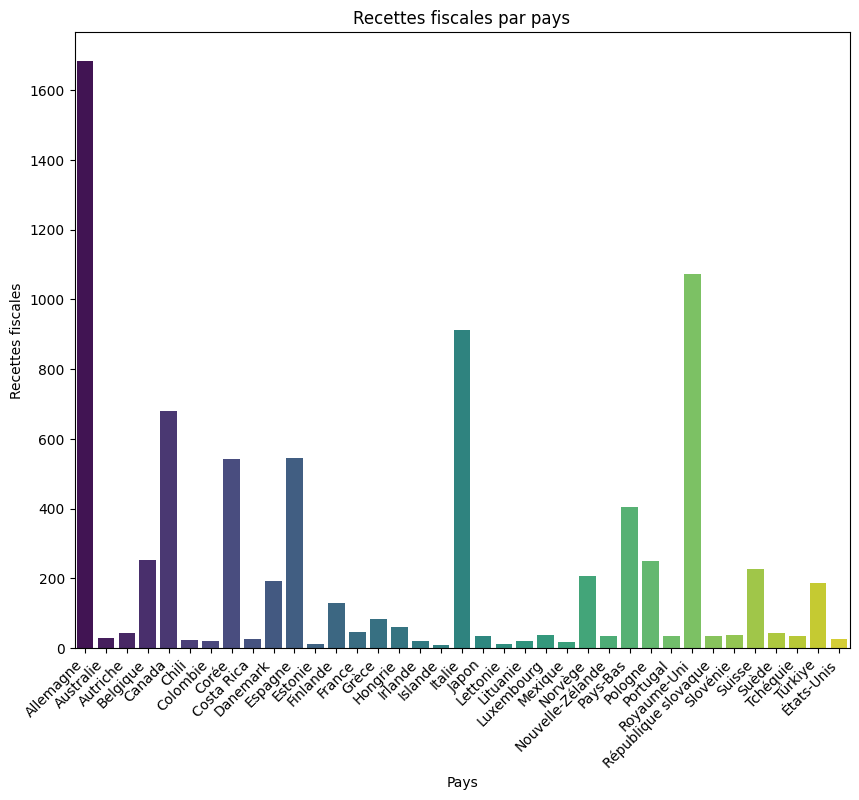

In [ ]:

plt.figure(figsize=(10, 8))
sns.barplot(data=df, x='Pays', y='Recettes fiscales', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Recettes fiscales par pays")
plt.ylabel("Recettes fiscales")
plt.xlabel("Pays")
plt.show()


**Interprétation :**
- Allemagne a les recettes fiscales les plus élevées, dépassant les 1 600 milliards.
- Italie et le Royaume-Uni enregistrent également des niveaux très élevés, mais bien inférieurs à ceux de l'Allemagne.
- Des pays comme Lettonie, Costa Rica, et Estonie ont des recettes fiscales très faibles, indiquant peut-être des économies plus petites ou des systèmes fiscaux moins développés.
- La taille des recettes fiscales est souvent corrélée à la taille de l'économie et à la population d'un pays, ainsi qu'à ses politiques fiscales.
- Les pays à haut niveau de recettes fiscales peuvent financer un large éventail de services publics, tandis que les pays à faible niveau peuvent avoir moins de ressources pour les dépenses publiques.

**Analyse des données :**

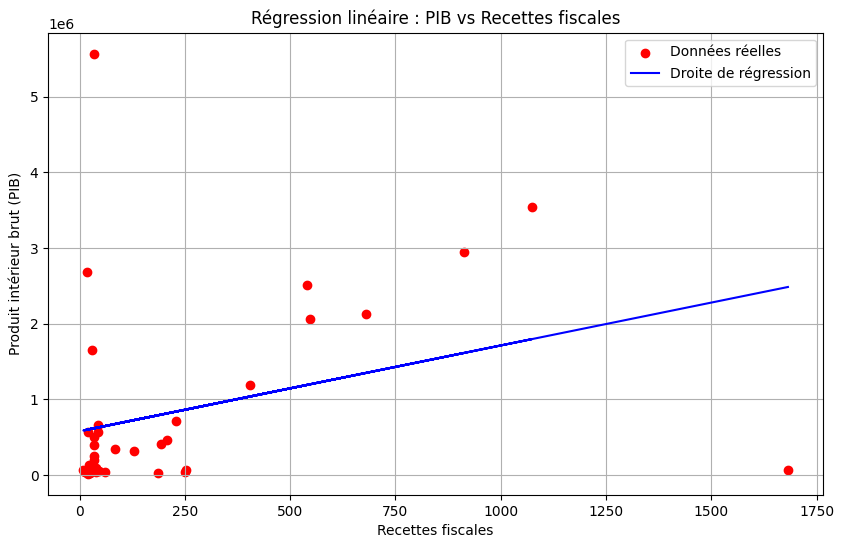

In [ ]:
from sklearn.linear_model import LinearRegression

y = df['Produit intérieur brut (PIB)']
X = df[['Recettes fiscales']]

# Régression linéaire
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Tracé des données et de la droite de régression
plt.figure(figsize=(10, 6))

# Nuage de points
plt.scatter(X, y, color='red', label='Données réelles')

# Droite de régression
plt.plot(X, y_pred, color='blue', label='Droite de régression')

# Étiquettes et titre
plt.xlabel('Recettes fiscales')
plt.ylabel('Produit intérieur brut (PIB)')
plt.title('Régression linéaire : PIB vs Recettes fiscales')
plt.legend()
plt.grid()

# Affichage
plt.show()


- **Quelles sont les relations entre les différentes variables démographiques ?**
- réponse par la matrice de corrélation permet de visualiser les relations linéaires entre les différentes variables.
- **Y a-t-il des groupes de pays ayant des profils démographiques similaires ?**
- **Comment les pays se positionnent-ils les uns par rapport aux autres en termes de données démographiques ?**
- On va répondre a ces quesions grace a l'analyse visuelle du nuage de points .**

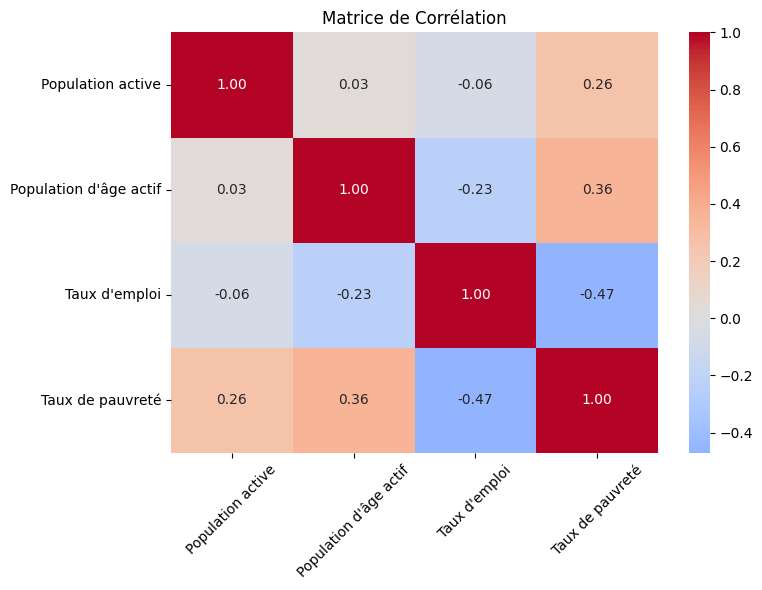

In [ ]:
# Sélection des variables démographiques
demo_vars = ['Population active', 'Population d\'âge actif', 'Taux d\'emploi', 'Taux de pauvreté']

# Normalisation des données
df_cleaned = df[demo_vars].dropna()  # Exclure les lignes avec des valeurs manquantes
scaler = StandardScaler()
demo_data_scaled = scaler.fit_transform(df_cleaned)

# Étape 1 : Matrice de Corrélation
corr_matrix = np.corrcoef(demo_data_scaled.T)

# Visualisation de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix,
            annot=True,
            cmap="coolwarm",
            center=0,
            fmt=".2f",
            xticklabels=demo_vars,  # Ajout des noms des variables sur l'axe x
            yticklabels=demo_vars)  # Ajout des noms des variables sur l'axe y
plt.title("Matrice de Corrélation")
plt.xticks(rotation=45)  # Rotation des labels pour une meilleure lisibilité
plt.yticks(rotation=0)
plt.tight_layout()  # Ajustement automatique de la mise en page
plt.show()


**Interprétation :**
- Population active & Taux de pauvreté : Corrélation faible et positive (0.26). Une augmentation de la population active est légèrement associée à une augmentation du taux de pauvreté.
- Population d'âge actif & Taux d'emploi : Corrélation négative modérée (-0.23). Cela peut indiquer qu'une augmentation de la population d'âge actif est associée à une légère baisse du taux d'emploi.
- Population d'âge actif & Taux de pauvreté : Corrélation positive modérée (0.36). Une augmentation de la population d'âge actif est associée à une hausse du taux de pauvreté.
- Les autres variables montrent des corrélations faibles .

In [ ]:
from sklearn.decomposition import PCA

# Étape 2 : Initialisation de l'ACP avec toutes les dimensions
pca = PCA(n_components=len(demo_vars))
demo_data_pca = pca.fit_transform(demo_data_scaled)


In [ ]:

# Étape 3 : Proportions de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_

# Affichage des proportions
print("Proportion de variance expliquée par chaque composante principale :")
for i, ratio in enumerate(explained_variance_ratio, 1):
    print(f"Composante {i}: {ratio:.2%}")


Proportion de variance expliquée par chaque composante principale :
Composante 1: 44.56%
Composante 2: 24.82%
Composante 3: 19.24%
Composante 4: 11.38%


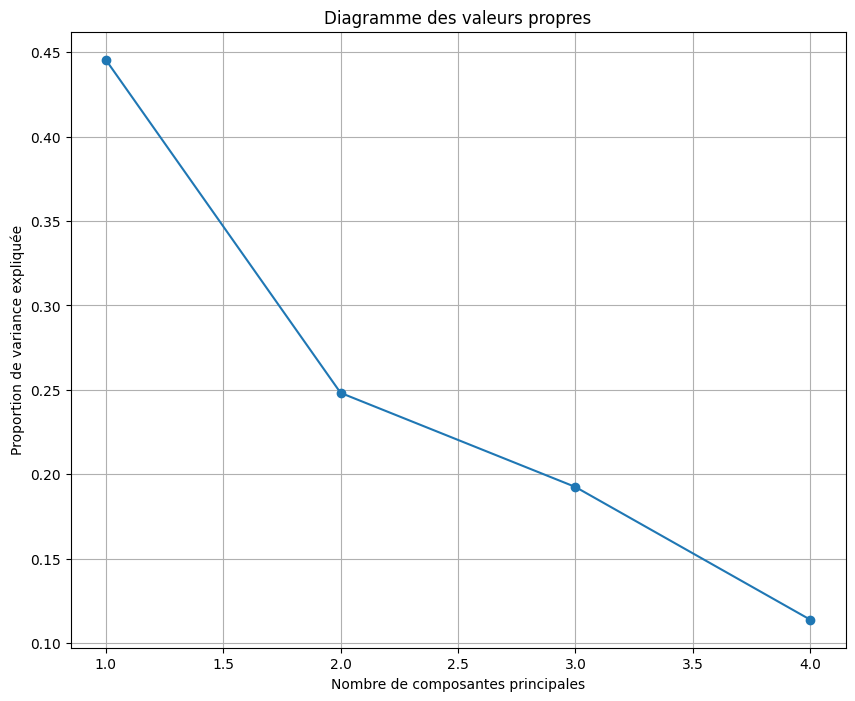

In [ ]:
# Étape 4 : Tracé du diagramme des valeurs propres
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de variance expliquée')
plt.title('Diagramme des valeurs propres')
plt.grid()
plt.show()

**Interprétation :**
- Le graphique montre un "coude" après la deuxième composante. Cela indique que les deux premières composantes principales sont les plus importantes pour expliquer la majorité de la variance dans les données (ils expliquent 69.38% de la variance totale).

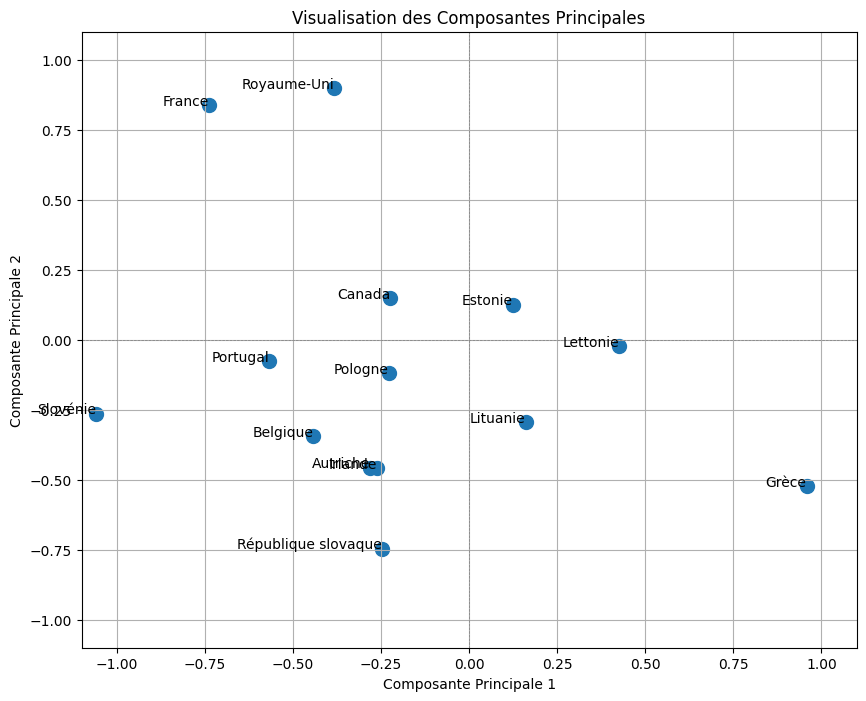

In [ ]:
import matplotlib.pyplot as plt

# Étape 5 : Visualisation des composantes principales avec les noms des pays
plt.figure(figsize=(10, 8))
plt.scatter(demo_data_pca[:, 0], demo_data_pca[:, 1], s=100)

# Utilisation des indices valides dans df_cleaned pour ajouter des annotations
for i in range(len(df_cleaned)):
    plt.annotate(df['Pays'].iloc[df_cleaned.index[i]],
                 (demo_data_pca[i, 0], demo_data_pca[i, 1]),
                 fontsize=10, ha='right')

# Ajuster les limites et ajouter des labels
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Visualisation des Composantes Principales')
plt.grid()
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()  # Afficher le graphe


**Interprétation :**
- Les pays proches les uns des autres dans le graphique ont des profils similaires en termes des variables utilisées dans l’ACP.
- La majorité des pays européens forment un groupe plus homogène, avec des similitudes en termes des variables étudiées.
- Les États-Unis, le Costa Rica et la Corée se démarquent des autres pays, suggérant un profil socio-économique différent.


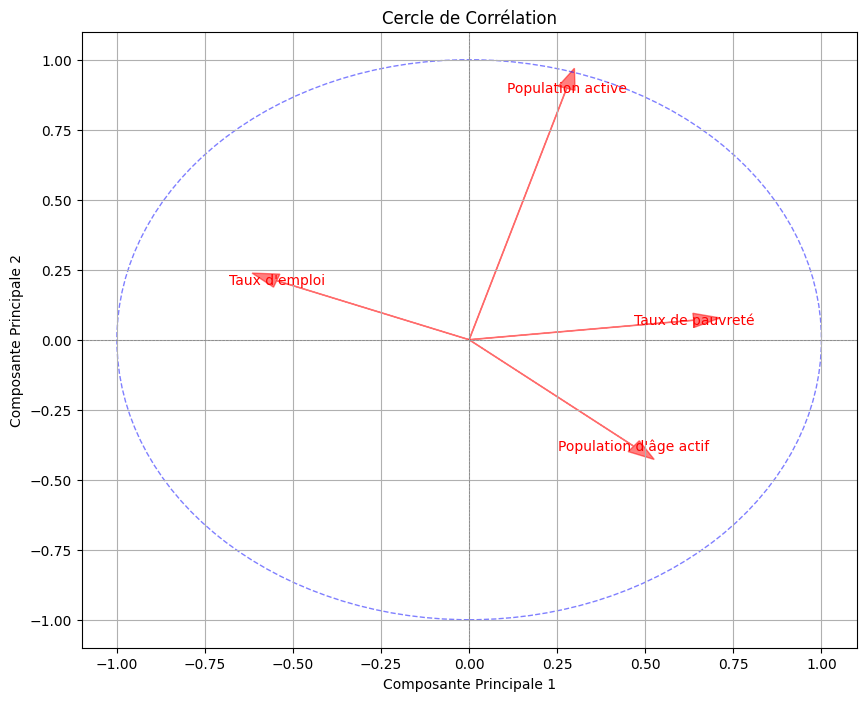

In [ ]:
# Ajout du cercle de corrélation
components = pca.components_
components_to_plot = components.T[:, :2]

plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(components_to_plot):
    plt.arrow(0, 0, x, y, color='r', alpha=0.5, head_width=0.05)
    plt.text(x, y, demo_vars[i], color='r', ha='center', va='center')

# Tracer un cercle
circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--', alpha=0.5)
plt.gca().add_artist(circle)

# Ajuster les limites et ajouter des labels
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Cercle de Corrélation')
plt.grid()
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()  # Afficher le cercle

**Interprétation :**
- La population active influencent fortement la 2ème composante (CP2).
- Le taux de pauvreté influencent fortement la première composante (CP1).
- Le taux de pauvreté et la population d’âge actif sont corrélés.
- Population d’âge actif et taux d’emploi  forment une corrélation négative faible à modérée

**Santé et bien-être :**
- **Existe-t-il une relation entre l'espérance de vie, la mortalité infantile et le taux de suicide dans les pays étudiés ?**

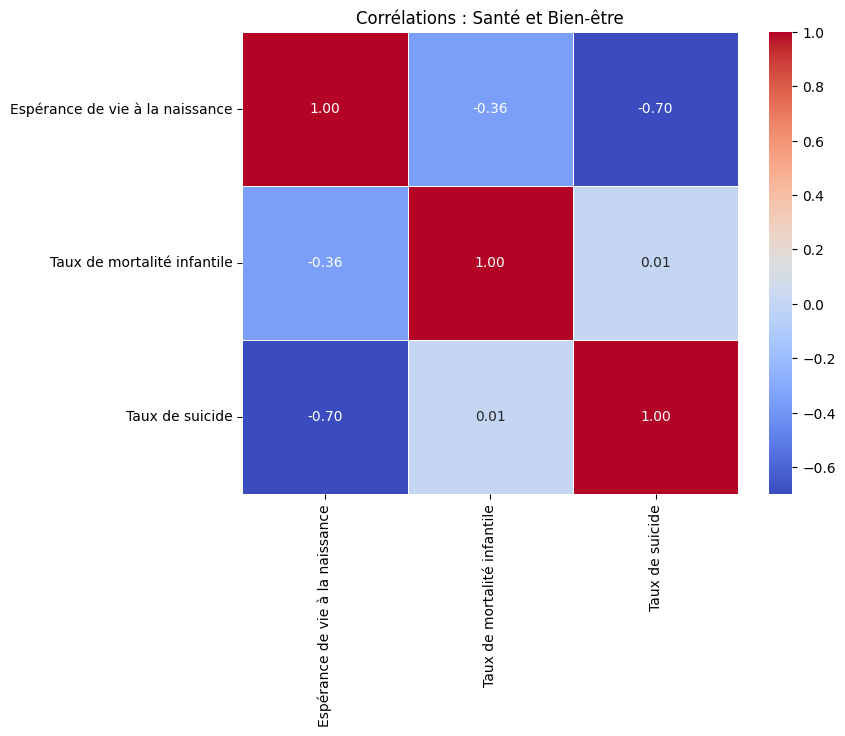

In [ ]:
health_vars = ['Espérance de vie à la naissance', 'Taux de mortalité infantile', 'Taux de suicide']

# Calcul de la matrice de corrélation
correlation_matrix = df[health_vars].corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Corrélations : Santé et Bien-être')
plt.show()


**Interprétation :**

- Espérance de vie à la naissance & Taux de suicide : La corrélation est négative (-0.70). Cela indique qu'une augmentation de l'espérance de vie est associée à une diminution du taux de suicide.
- Espérance de vie à la naissance & Taux de mortalité infantile : La corrélation est négative (-0.36), et plus faible. Une meilleure espérance de vie est légèrement liée à une baisse de la mortalité infantile.
- Taux de mortalité infantile & Taux de suicide : La corrélation est proche de zéro (0.01), ce qui signifie qu'il n'y a pas de lien significatif entre ces deux variables.
    - => L'espérance de vie est influencée par des facteurs comme le taux de suicide et, le taux de mortalité infantile.



**Est ce qu'il existe une corrélation entre le niveau de richesse économique d'un pays et la durée de vie moyenne de ses habitants ?**

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


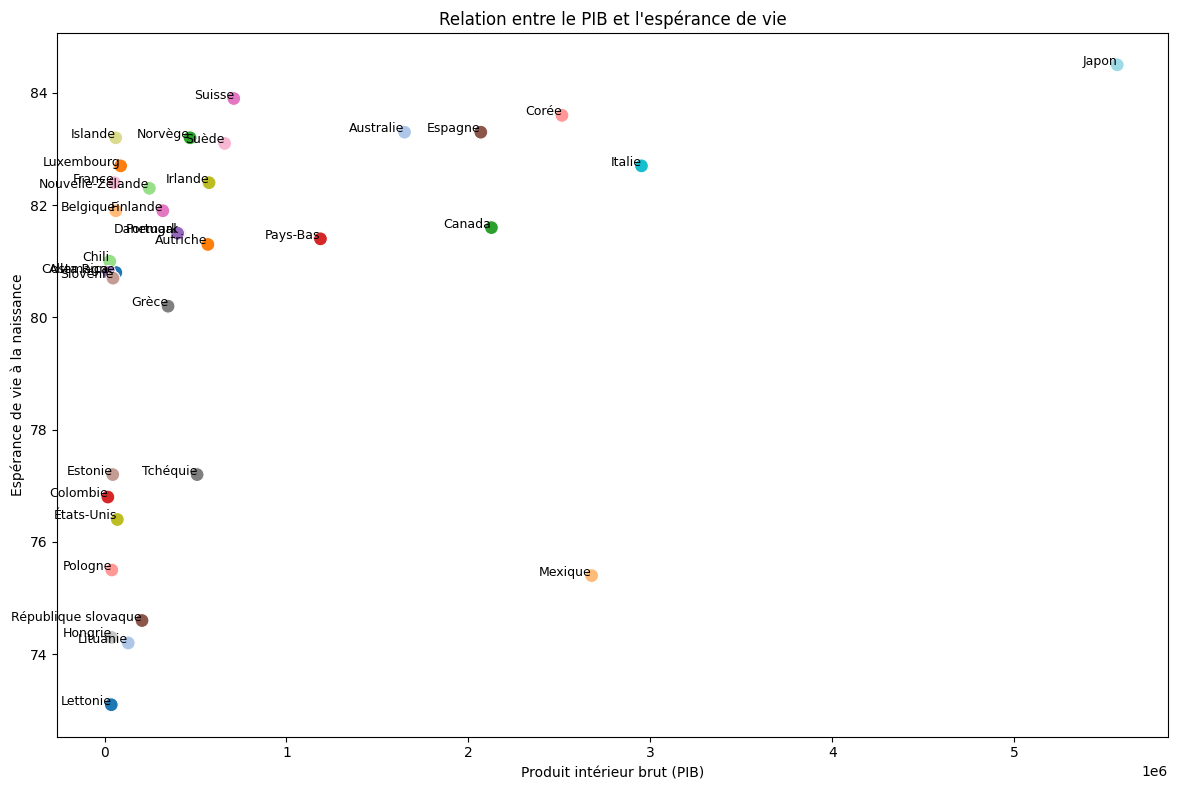

In [ ]:
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df,
    x='Produit intérieur brut (PIB)',
    y='Espérance de vie à la naissance',
    hue='Pays',
    palette='tab20',
    s=100,
    legend=False  # Disable the legend
)

# Annotate each point with the country name
for i in range(len(df)):
    plt.text(
        x=df['Produit intérieur brut (PIB)'].iloc[i],
        y=df['Espérance de vie à la naissance'].iloc[i],
        s=df['Pays'].iloc[i],
        fontsize=9,
        ha='right'
    )

plt.title("Relation entre le PIB et l'espérance de vie")
plt.xlabel("Produit intérieur brut (PIB)")
plt.ylabel("Espérance de vie à la naissance")
plt.tight_layout()
plt.show()


**Interprétation :**

  - De manière générale, on remarque que les pays avec un PIB plus élevé ont tendance à avoir une espérance de vie plus longue.Ca veut dire que les pays riches investissent davantage dans les soins de santé, l'éducation, et l'infrastructure, améliorant ainsi la qualité de vie et augmentant l'espérance de vie.
- Les points sur le graphe montrent que les pays ayant un PIB faible sont souvent associés à une espérance de vie plus courte.Les pays avec un PIB faible ont souvent un accès limité aux soins médicaux, à la nutrition et à d'autres facteurs critiques qui influencent la santé.
- Les exceptions :
    - Le Mexique a une espérance de vie relativement faible par rapport à son PIB.
    - Le Japon qui se distingue avec une espérance de vie très et un PIB élevées, confirmant leur statut de pays développés avec une qualité de vie élevée.

**Quels sont les groupes de pays ayant des profils démographiques similaires ?**

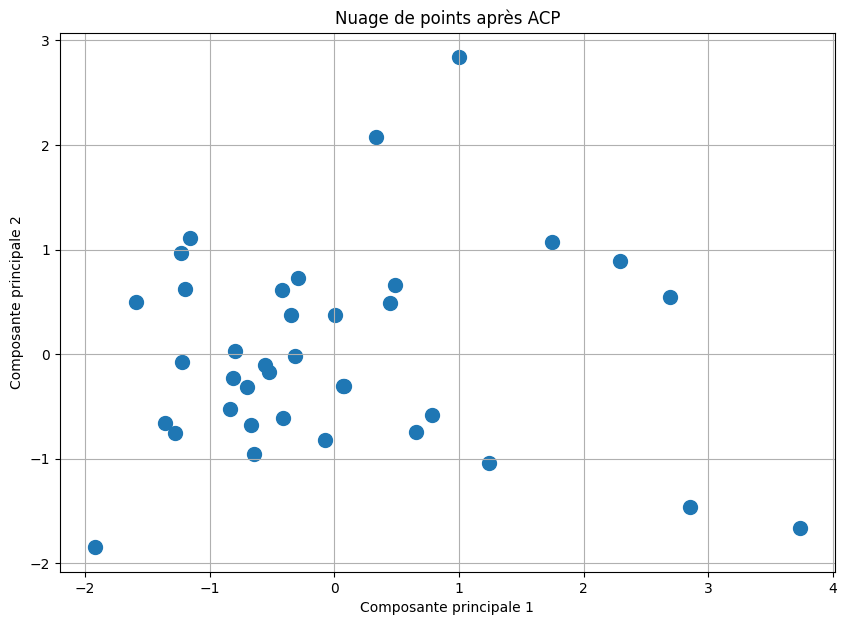

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Sélectionner les colonnes pertinentes
selected_columns = ['Taux d\'emploi',
                    'Taux d\'accès Internet',
                    'Population d\'âge actif']

# Vérifier si ces colonnes existent dans le dataset
selected_data = df[selected_columns]

# Imputation des valeurs manquantes
selected_data = selected_data.fillna(selected_data.mean())

# Normalisation des colonnes sélectionnées
scaler = StandardScaler()
selected_data_scaled = scaler.fit_transform(selected_data)

# Application de l'ACP
pca = PCA(n_components=2)  # Réduction à 2 dimensions pour la visualisation
selected_data_pca = pca.fit_transform(selected_data_scaled)

# Affichage du nuage de points après l'ACP
plt.figure(figsize=(10, 7))
plt.scatter(selected_data_pca[:, 0], selected_data_pca[:, 1], s=100)
plt.title("Nuage de points après ACP")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid()
plt.show()


- Ce graphique permet de visualiser les similarités et les différences entre les pays en termes de variables démographiques sélectionnées.
- Les pays regroupés ensemble peuvent partager des caractéristiques démographiques similaires

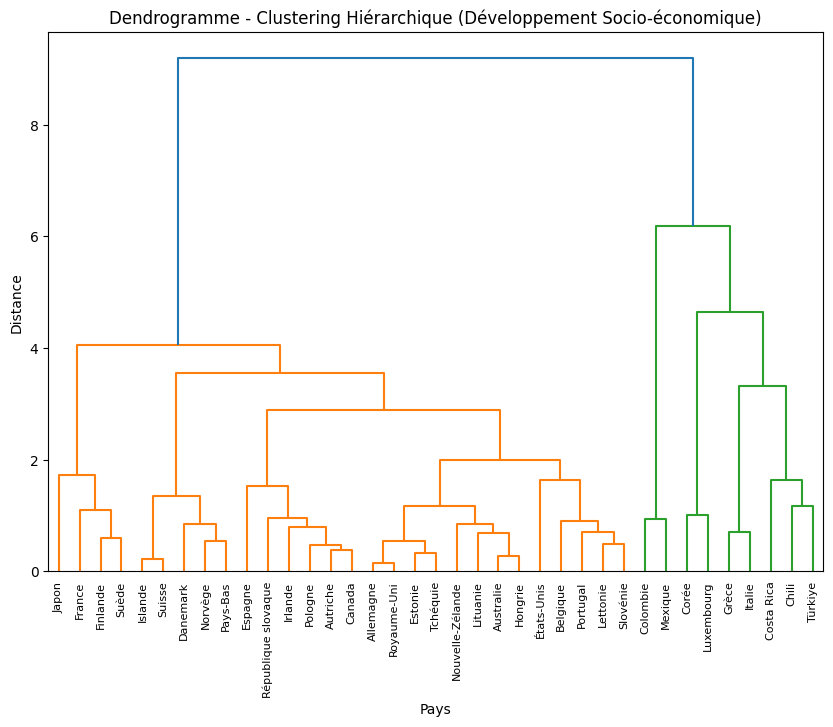

In [ ]:
# Clustering hiérarchique sur les données normalisées (originales)
linked = linkage(selected_data_scaled, method='ward')

# Visualisation du dendrogramme
plt.figure(figsize=(10, 7))
plt.title("Dendrogramme - Clustering Hiérarchique (Développement Socio-économique)")
dendrogram(linked, labels=df['Pays'].tolist(), leaf_rotation=90)
plt.xlabel("Pays")
plt.ylabel("Distance")
plt.show()

- Les pays les plus similaires apparaissent connectés par des branches proches.
- L'axe vertical représente la distance ou la dissimilarité entre les clusters. Plus la connexion entre deux groupes est haute, plus ils sont différents.
- Les pays qui se ressemblent davantage sont connectés à des distances plus faibles.

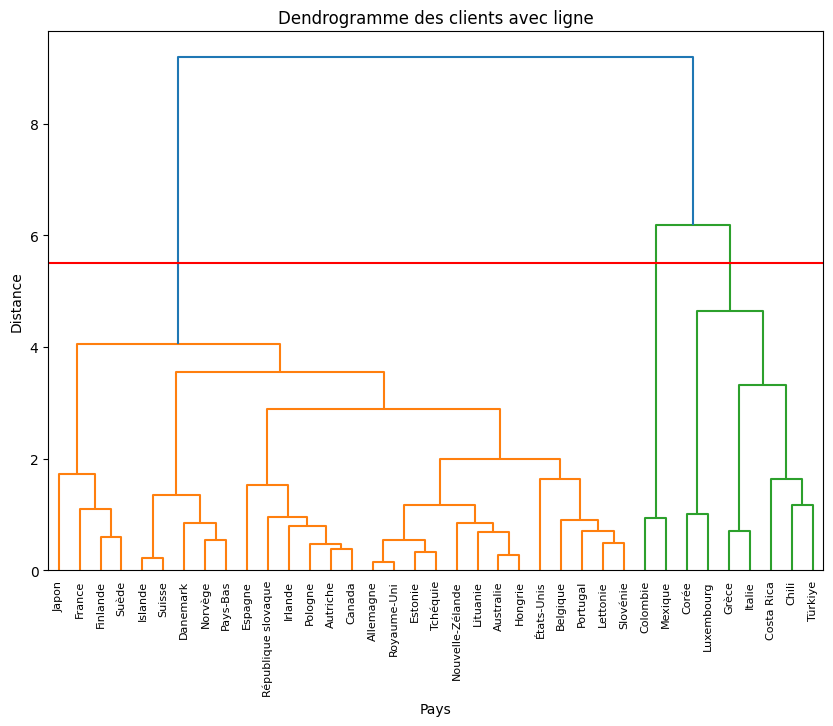

In [ ]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Création du dendrogramme avec une ligne horizontale
plt.figure(figsize=(10, 7))
plt.title("Dendrogramme des clients avec ligne")
clusters = shc.linkage(selected_data_scaled, method='ward', metric="euclidean")
shc.dendrogram(clusters, labels=df['Pays'].tolist(), leaf_rotation=90)
plt.axhline(y=5.5, color='r', linestyle='-')
plt.xlabel("Pays")
plt.ylabel("Distance")
plt.show()


- Définition les clusters :
    - Tous les pays connectés en dessous de cette ligne sont regroupés dans un même cluster.
    -  Les groupes séparés au-dessus de cette ligne sont considérés comme des clusters distincts.

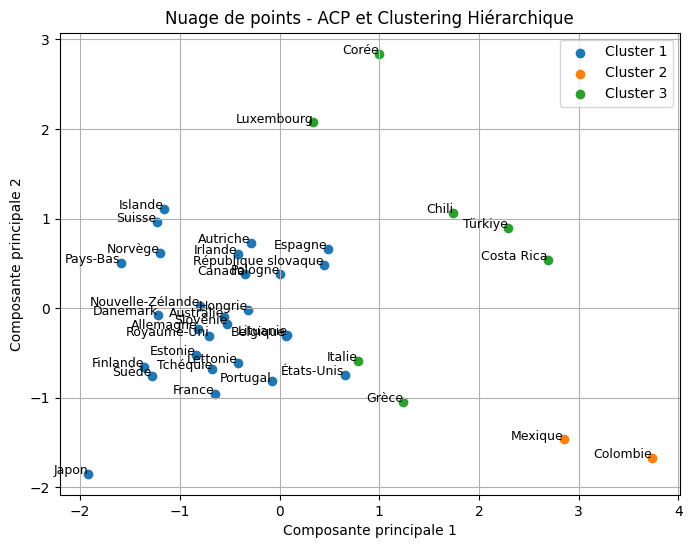

In [ ]:
# Découpage en clusters
num_clusters = 3  # Nombre de clusters
clusters_hierarchical = fcluster(linked, num_clusters, criterion='maxclust')

# Ajouter les clusters au dataset
df['Cluster_Hierarchical'] = clusters_hierarchical

# Visualisation des clusters dans l'espace ACP
plt.figure(figsize=(8, 6))
for cluster in range(1, num_clusters + 1):
    cluster_data = selected_data_pca[clusters_hierarchical == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

    # Ajouter les annotations pour les pays
    for i in range(len(cluster_data)):
        plt.annotate(df['Pays'][clusters_hierarchical == cluster].iloc[i],
                     (cluster_data[i, 0], cluster_data[i, 1]),
                     fontsize=9, ha='right')

plt.title("Nuage de points - ACP et Clustering Hiérarchique")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid()
plt.show()


- Cluster 1 (bleu) :
Il regroupe majoritairement des pays européens (France, Allemagne, Norvège, Suisse, etc.).
Ces pays semblent partager des caractéristiques socio-économiques similaires,
- Cluster 2 (orange) :
Ce cluster comprend des pays situés plus loin des autres dans l'espace (Mexique, Colombie).
Ces pays pourraient avoir des indicateurs très différents
- Cluster 3 (vert) :
Ce cluster regroupe des pays comme la Turquie, le Chili, le Costa Rica ...

##Comment regrouper les pays selon leurs caractéristiques économiques et sociales pour analyser leurs similarités et différences et mieux comprendre leurs dynamiques de développement ?








<ipython-input-3-9d270ef77b93>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[columns] = df_filtered[columns].apply(pd.to_numeric, errors='coerce')


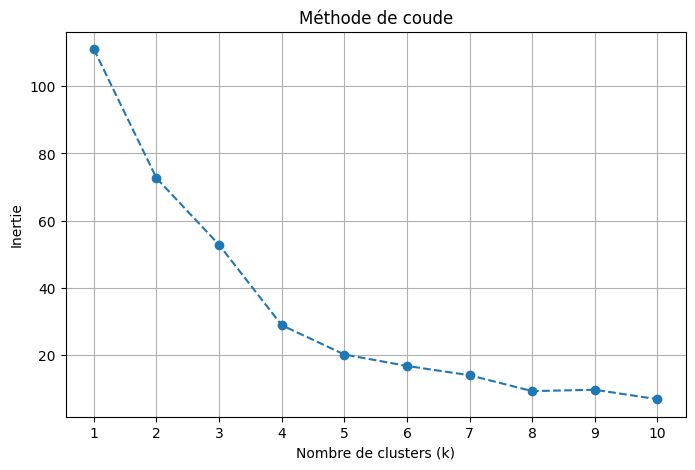

In [ ]:
# Sélectionner les colonnes pertinentes
columns = ['Produit intérieur brut (PIB)', 'Population active', 'Taux d\'emploi']

# Filtrer les données pour ne conserver que les pays et les colonnes pertinentes
df_filtered = df[['Pays'] + columns]

# S'assurer que les valeurs sont numériques
df_filtered[columns] = df_filtered[columns].apply(pd.to_numeric, errors='coerce')

# Supprimer les lignes contenant des valeurs manquantes
df_filtered = df_filtered.dropna()

# Configurer les noms des pays comme index
df_filtered.set_index('Pays', inplace=True)

# Standardiser les données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_filtered)

# Calculer l'inertie pour différents nombres de clusters
inertia = []
k_range = range(1, 11)  # Tester entre 1 et 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Tracer la méthode de coude
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title("Méthode de coude")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.xticks(k_range)
plt.grid(True)
plt.show()


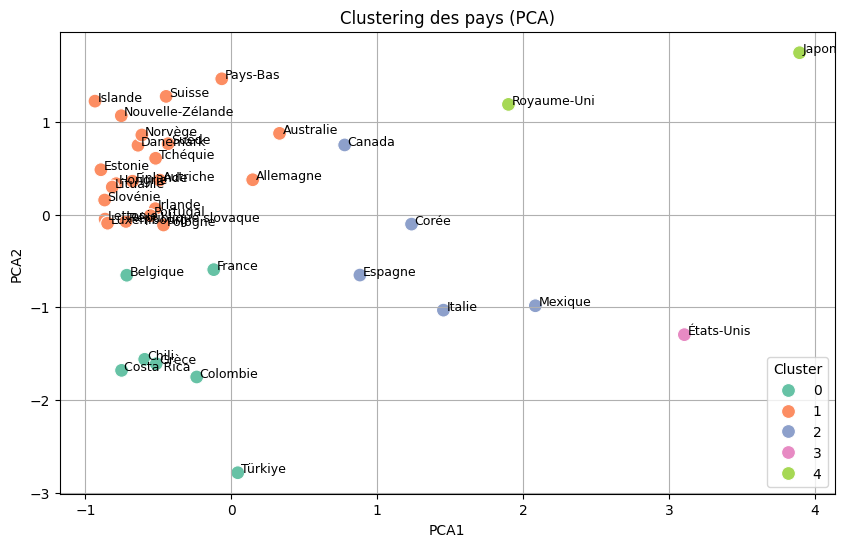

In [ ]:
from sklearn.cluster import KMeans

# Appliquer K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Ajouter les clusters au DataFrame
df_filtered['Cluster'] = clusters

# Réduction de dimension pour la visualisation (PCA)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Ajouter les coordonnées PCA au DataFrame
df_filtered['PCA1'] = data_pca[:, 0]
df_filtered['PCA2'] = data_pca[:, 1]

# Visualiser les clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_filtered['PCA1'],
    y=df_filtered['PCA2'],
    hue=df_filtered['Cluster'],
    palette='Set2',
    s=100
)

# Ajouter les noms des pays comme labels
for i in range(len(df_filtered)):
    plt.text(
        df_filtered['PCA1'].iloc[i] + 0.02,
        df_filtered['PCA2'].iloc[i],
        df_filtered.index[i],
        fontsize=9
    )

plt.title('Clustering des pays (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


##**Interpretation :**

**Cluster 0 (Vert clair) :**

* Les pays de ce cluster sont regroupés dans une zone indiquant des valeurs modérées sur les axes PCA1 et PCA2.

* L’éloignement par rapport aux autres clusters suggère des différences notables avec les pays développés ou les économies dominantes.e croissante et un PIB en développement.


**Cluster 1 (Orange) :**
* Ce cluster est situé dans une zone où les valeurs sur PCA1 et PCA2 sont élevées.

* Cela indique des caractéristiques économiques relativement fortes sur les variables analysées, comme un taux d’emploi élevé ou une forte population active.
* Les pays de ce groupe montrent une homogénéité importante, ce qui se reflète par leur regroupement compact.

**Cluster 2 (Bleu) :**

* Les pays de ce cluster se situent dans une position intermédiaire sur les axes, avec des valeurs ni trop élevées ni trop faibles.

* La dispersion de ce cluster sur PCA1 et PCA2 reflète une certaine hétérogénéité dans les caractéristiques des pays, indiquant qu’ils partagent des points communs mais avec des variations significatives sur certaines dimensions.


**Cluster 3 (Violet) :**

* Ce cluster est relativement éloigné des clusters principaux, indiquant des caractéristiques distinctives pour ces pays.

* Les valeurs sur PCA1 ou PCA2, bien que élevées, montrent des variations spécifiques qui différencient ces pays des groupes plus homogènes.

**Cluster 4 (Rose) :**
* Ce cluster contient un pays isolé (Etas-Unis) avec des valeurs extrêmes sur PCA1 et PCA2.

* L’isolement reflète des caractéristiques uniques dans les données, telles qu’une concentration exceptionnelle sur certaines variables, comme une économie fortement dominante ou un PIB nettement plus élevé
.

## 5- Analyse exploratoire :

**5-1-la dataset de tauxChomageEmploi :**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_white

In [ ]:
tauxChomEmploi = pd.read_csv('/content/drive/MyDrive/tauxChomEmploi2.csv')
# description de data
tauxChomEmploi.head()


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,taux emploi,Taux de Chomage
0,Pays-Bas,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences, technologie, ingénierie et mathémati...",81.568626,2.347418
1,Slovénie,M,De 35 à 44 ans,"Niveau master, doctorat ou équivalent",Éducation (grand domaine),91.121391,7.145464
2,Suisse,F,De 35 à 44 ans,Niveau licence ou équivalent,Lettres et arts,72.585220,15.116038
3,Allemagne,M,De 45 à 54 ans,"Niveau master, doctorat ou équivalent","Sciences humaines (sauf langues), sciences soc...",92.181023,3.538925
4,Suisse,M,De 25 à 34 ans,"Niveau master, doctorat ou équivalent","Ingénierie, industries de transformation et co...",95.193298,3.940461


##**Examiner la structure du dataset**

In [ ]:
# Obtenir des informations sur la structure du dataset
tauxChomEmploi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pays                 1161 non-null   object 
 1   Genre                1161 non-null   object 
 2   Age                  1161 non-null   object 
 3   Niveau de scolarite  1161 non-null   object 
 4   Domaine etudes       1161 non-null   object 
 5   taux emploi          1161 non-null   float64
 6   Taux de Chomage      1161 non-null   float64
dtypes: float64(2), object(5)
memory usage: 63.6+ KB


##**Statistiques descriptives pour les variables numériques**

In [ ]:
tauxChomEmploi.describe()

,taux emploi,Taux de Chomage
count,1161.000000,1161.000000
mean,84.369049,5.550891
std,9.610622,4.787327
min,44.379131,0.049623
25%,79.022331,2.526417
50%,86.225700,4.144152
75%,91.518105,6.963883
max,99.486580,59.111275


##**Visualisation de distribution de taux d'emploi selon le genre**

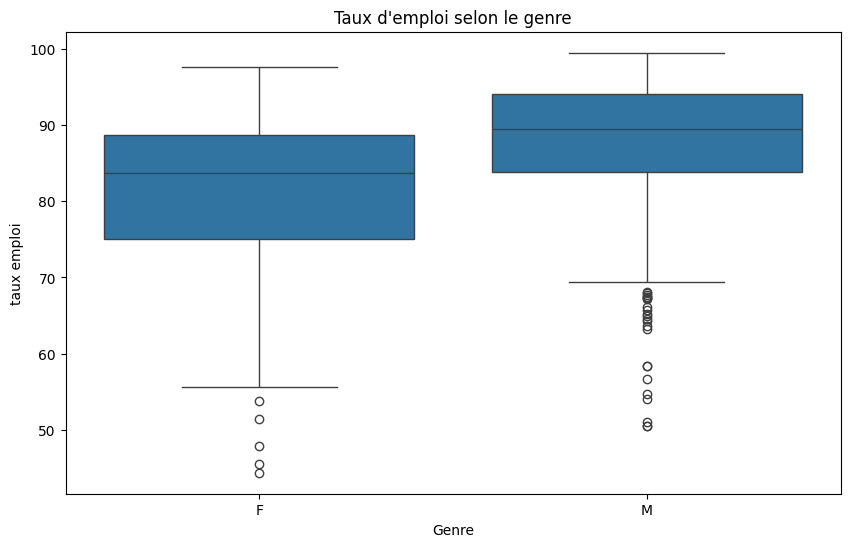

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='taux emploi', data=tauxChomEmploi)
plt.title('Taux d\'emploi selon le genre')
plt.show()

**Interpretation :**

Le taux d'emploi médian semble légèrement plus élevé chez les hommes (M) par rapport aux femmes (F).



*   Les hommes ont aussi une plus grande concentration de valeurs aberrantes en dessous de la moustache inférieure, indiquant qu'il existe des individus masculins avec un taux d'emploi significativement plus bas.
*  La distribution des données pour les femmes est légèrement plus étendue, indiquant une plus grande variabilité dans le taux d'emploi.


En conclusion, bien que le taux d'emploi médian soit similaire ou légèrement plus élevé pour les hommes, les femmes semblent présenter moins de valeurs aberrantes, et leur distribution est un peu plus homogène.

##**Visualisation de distribution de taux de chomage selon le genre**

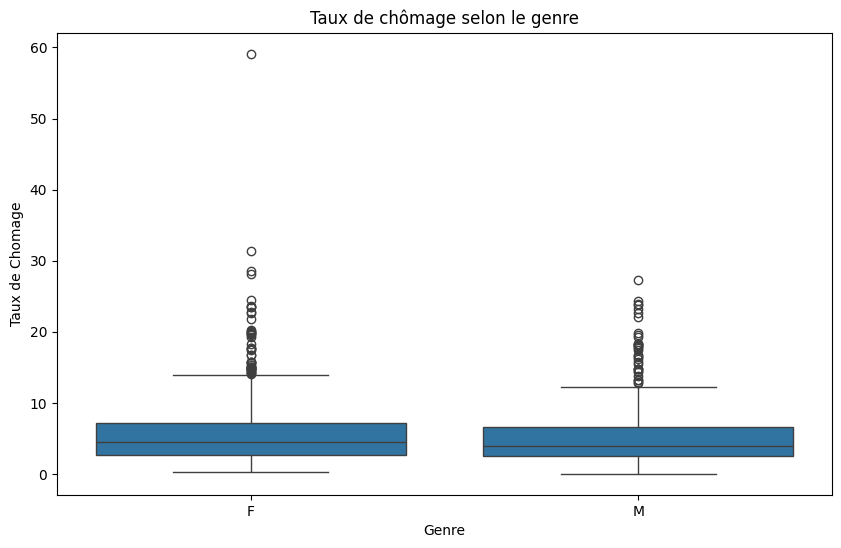

In [ ]:
# Boxplot pour le taux de chômage en fonction du genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Taux de Chomage', data=tauxChomEmploi)
plt.title('Taux de chômage selon le genre')
plt.show()


**Interpretation :**

*   La médiane du taux de chômage est similaire pour les deux genres (F et M), suggérant qu’il n’y a pas de grande différence dans le chômage médian entre hommes et femmes.
*   Les boîtes sont de tailles similaires, indiquant que la variabilité du taux de chômage est comparable entre les genres.


*   Il y a plusieurs valeurs aberrantes pour les deux genres, mais les femmes (F) semblent avoir un point exceptionnellement élevé (environ 60 % de chômage), qui est bien au-dessus des autres valeurs aberrantes.
*   Les moustaches s'étendent légèrement plus haut pour les hommes (M), ce qui indique que le taux de chômage le plus élevé, hors aberrations, est légèrement supérieur chez eux.






##**Visualisation de distribution de taux d'emploi selon le niveau d'étude**

<ipython-input-11-5c1b0fc3b240>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emploi_par_niveau,


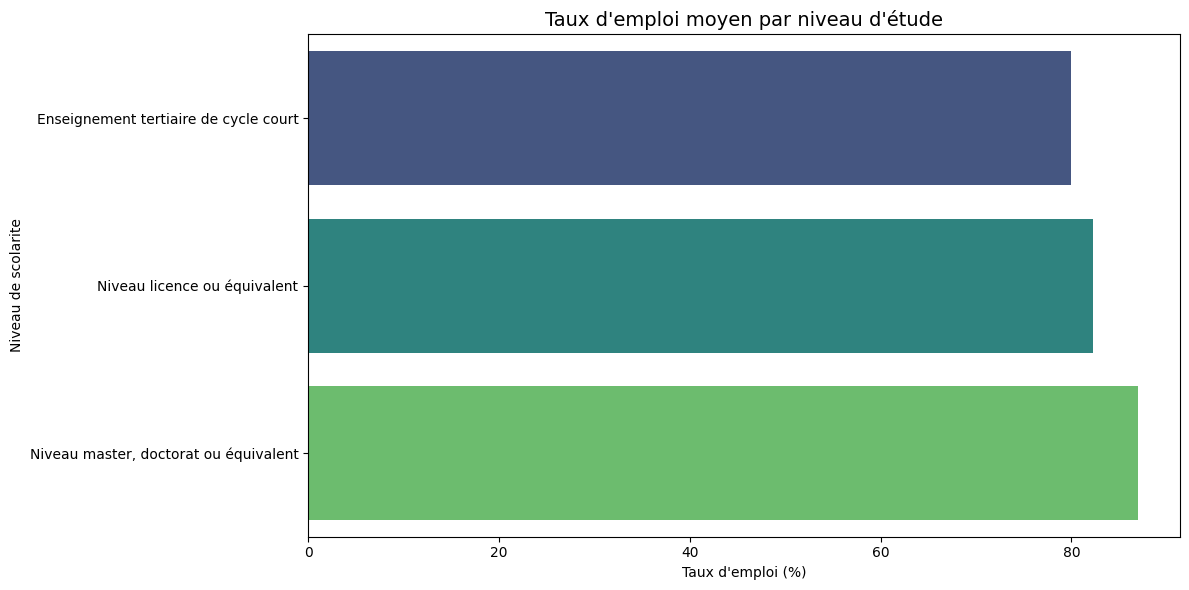

In [ ]:

emploi_par_niveau = (
    tauxChomEmploi.groupby('Niveau de scolarite')['taux emploi']
    .mean()
    .sort_index()
    .reset_index()
)

# Visualiser les données avec un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(data=emploi_par_niveau,
            x='taux emploi',
            y='Niveau de scolarite',
            palette='viridis')

plt.title("Taux d'emploi moyen par niveau d'étude", fontsize=14)
plt.xlabel("Taux d'emploi (%)")
plt.ylabel("Niveau de scolarite")
plt.tight_layout()
plt.show()




*   Le taux d'emploi moyen augmente avec le niveau d'études.
*   Les personnes ayant un niveau d'études plus élevé (Master, Doctorat ou équivalent) ont le taux d'emploi le plus élevé.


*  
Les personnes avec un niveau licence ont un taux d'emploi légèrement inférieur à celui des niveaux Master/Doctorat, mais supérieur à celui des études tertiaires de cycle court.
*   Élément de liste

Ce graphique montre une corrélation positive entre le niveau d'études et le taux d'emploi moyen. Les individus ayant des qualifications plus élevées (Master, Doctorat) semblent avoir de meilleures opportunités d'emploi,




##**Visualisation de distribution de taux de chomage selon le niveau d'étude**

<ipython-input-14-5e9220a2f7b8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=chomage_par_niveau,


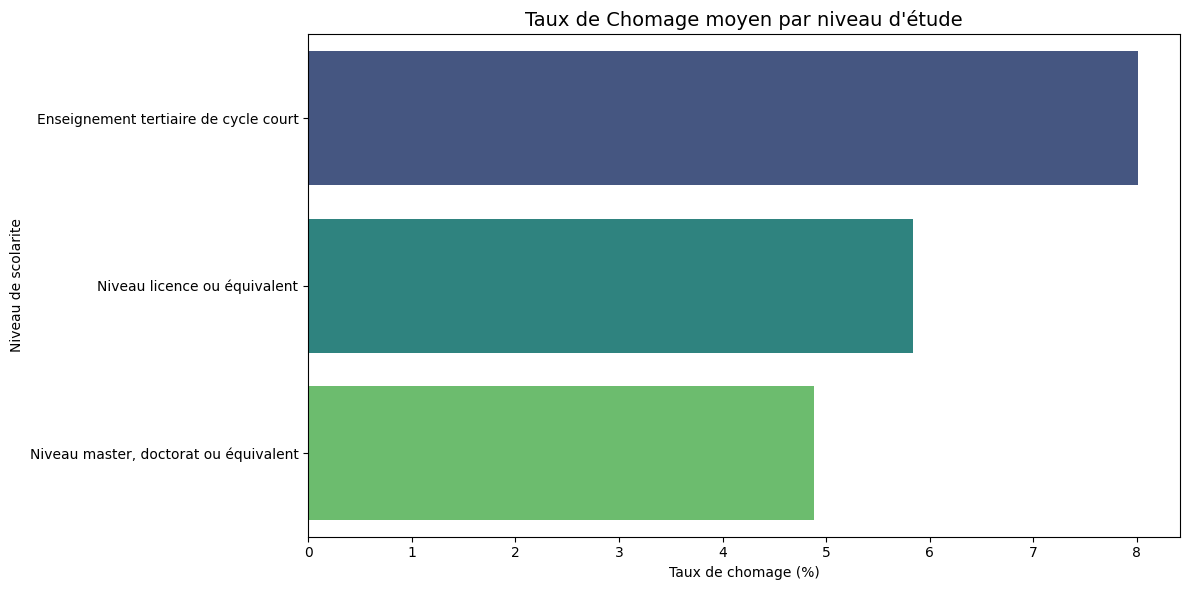

In [ ]:

chomage_par_niveau = (
    tauxChomEmploi.groupby('Niveau de scolarite')['Taux de Chomage']
    .mean()
    .sort_index()
    .reset_index()
)

# Visualiser les données avec un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(data=chomage_par_niveau,
            x='Taux de Chomage',
            y='Niveau de scolarite',
            palette='viridis')

plt.title("Taux de Chomage moyen par niveau d'étude", fontsize=14)
plt.xlabel("Taux de chomage (%)")
plt.ylabel("Niveau de scolarite")
plt.tight_layout()
plt.show()




*   Les taux de chômage les plus élevés sont observés pour les niveaux d’études
les moins avancés :


  L’enseignement tertiaire de cycle court affiche le taux de chômage le plus élevé.
*   Le chômage diminue à mesure que le niveau d’éducation augmente :

Les individus ayant un niveau licence ou équivalent connaissent un taux de chômage modéré.
Ceux ayant un niveau master, doctorat ou équivalent présentent le taux de chômage le plus faible.

##**Visualisation de distribution de taux d'emploi selon le domaine d'étude**

<ipython-input-13-5e3d5759cb3b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emploi_par_domaine,


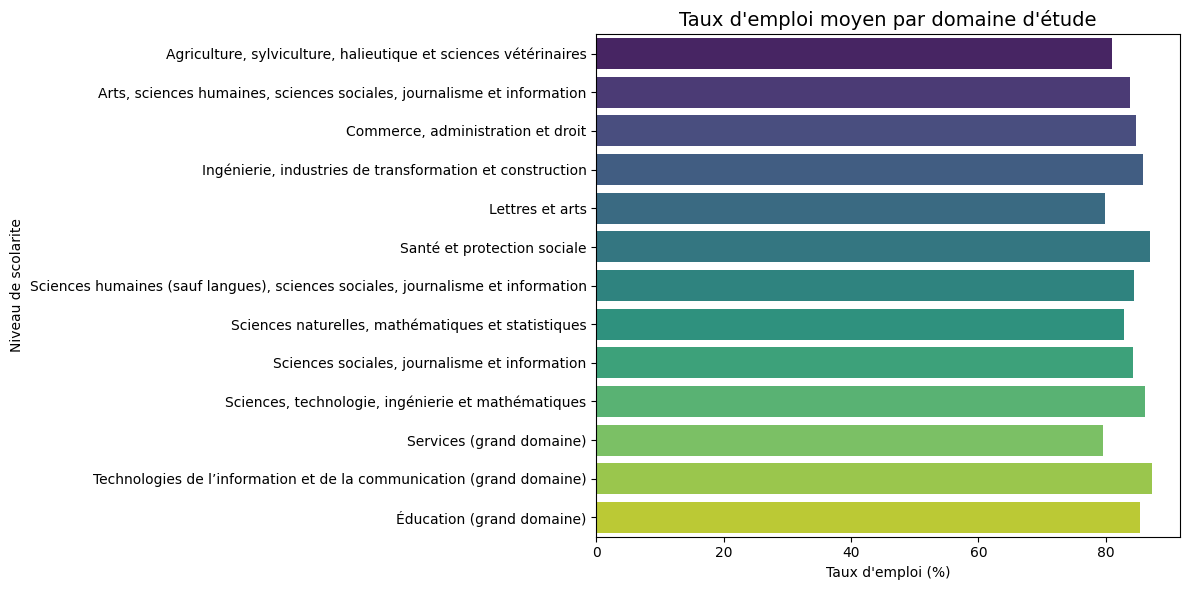

In [ ]:

emploi_par_domaine = (
    tauxChomEmploi.groupby('Domaine etudes')['taux emploi']
    .mean()
    .sort_index()
    .reset_index()
)

# Visualiser les données avec un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(data=emploi_par_domaine,
            x='taux emploi',
            y='Domaine etudes',
            palette='viridis')

plt.title("Taux d'emploi moyen par domaine d'étude", fontsize=14)
plt.xlabel("Taux d'emploi (%)")
plt.ylabel("Niveau de scolarite")
plt.tight_layout()
plt.show()



1.   Domaines avec les taux d'emploi les plus élevés :


*   Technologies de l’information et de la communication (grand domaine) suit de près, ce qui reflète la forte demande dans ce secteur.
*   Éducation (grand domaine) a le taux d'emploi le plus élevé parmi les domaines représentés.



2.   Domaines avec des taux d'emploi modérés :


*   
Les domaines comme services, sciences, technologie, ingénierie et mathématiques affichent des taux d'emploi compétitifs.
3.  
Domaines avec les taux d'emploi les plus faibles :


*   Les secteurs tels que agriculture, sylviculture, halieutique et sciences vétérinaires et arts, sciences humaines, sciences sociales, journalisme et information ont des taux d'emploi inférieurs comparés aux autres.








##**Visualisation de distribution de taux de chomage selon les pays**

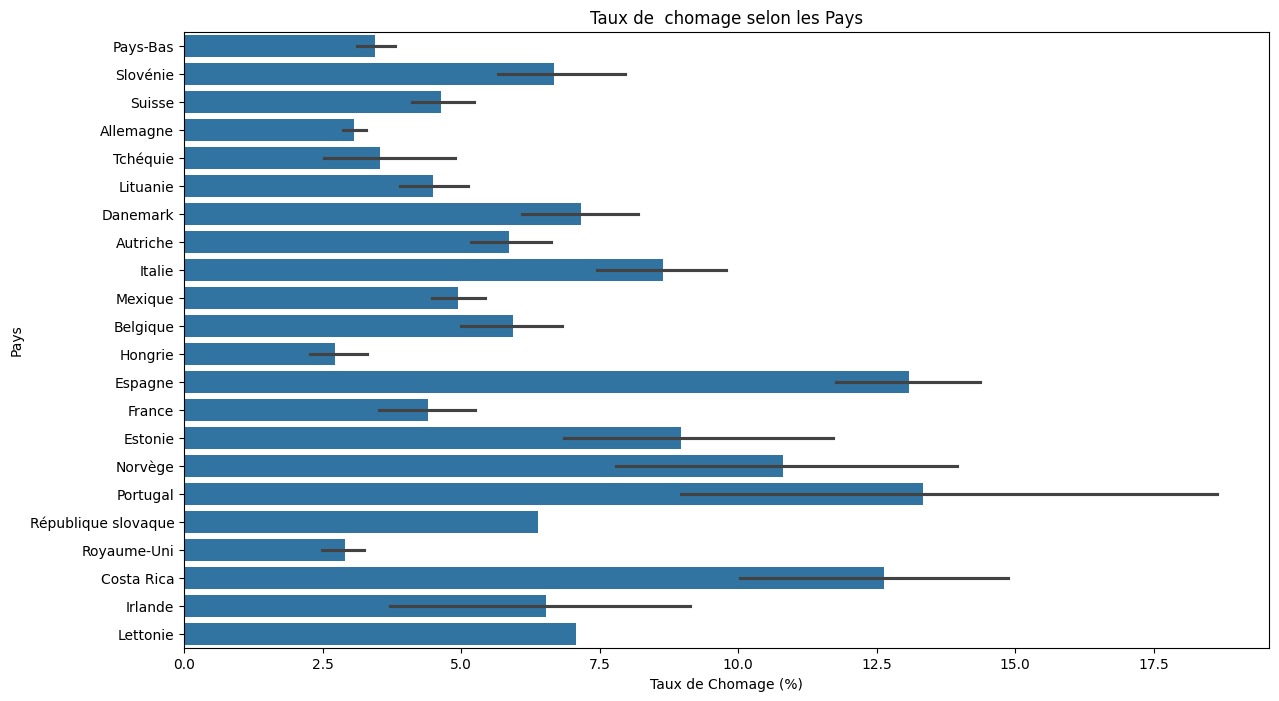

In [ ]:
# Tracer un graphique en barres horizontal pour le taux d'emploi
plt.figure(figsize=(14, 8))
sns.barplot(x='Taux de Chomage', y='Pays', data=tauxChomEmploi)
plt.title('Taux de  chomage selon les Pays')
plt.xlabel('Taux de Chomage (%)')
plt.ylabel('Pays')
plt.show()



1.   Pays avec les taux de chômage les plus bas :


*   Les Pays-Bas, la Suisse, l’Allemagne, et le Royaume-Uni affichent des taux de chômage particulièrement faibles, souvent autour de 2 à 4 %.



2.  Pays avec les taux de chômage les plus élevés :


*   
Des pays comme l’Espagne, le Portugal, et la Lettonie présentent des taux de chômage élevés, parfois supérieurs à 10 %. Cela peut refléter des défis structurels ou économiques dans ces régions.
3.  
Pays intermédiaires :



*   La France, l’Italie, et la Belgique ont des taux de chômage modérés, oscillant autour de 7 à 9 %, ce qui reste significatif mais moins extrême que dans certains pays du sud de l’Europe






##**Visualisation des corrélation entre les variables de cette dataset par la matrice de corrélation**

                         Pays     Genre       Age  Niveau de scolarite  \
Pays                 1.000000 -0.015369  0.021557             0.091023   
Genre               -0.015369  1.000000  0.049411            -0.033581   
Age                  0.021557  0.049411  1.000000             0.028315   
Niveau de scolarite  0.091023 -0.033581  0.028315             1.000000   
Domaine etudes       0.007575  0.002327 -0.030151            -0.031600   
taux emploi          0.023379  0.313438  0.004154             0.267133   
Taux de Chomage     -0.080158 -0.053161 -0.247325            -0.167483   

                     Domaine etudes  taux emploi  Taux de Chomage  
Pays                       0.007575     0.023379        -0.080158  
Genre                      0.002327     0.313438        -0.053161  
Age                       -0.030151     0.004154        -0.247325  
Niveau de scolarite       -0.031600     0.267133        -0.167483  
Domaine etudes             1.000000     0.033864        -0.071727  

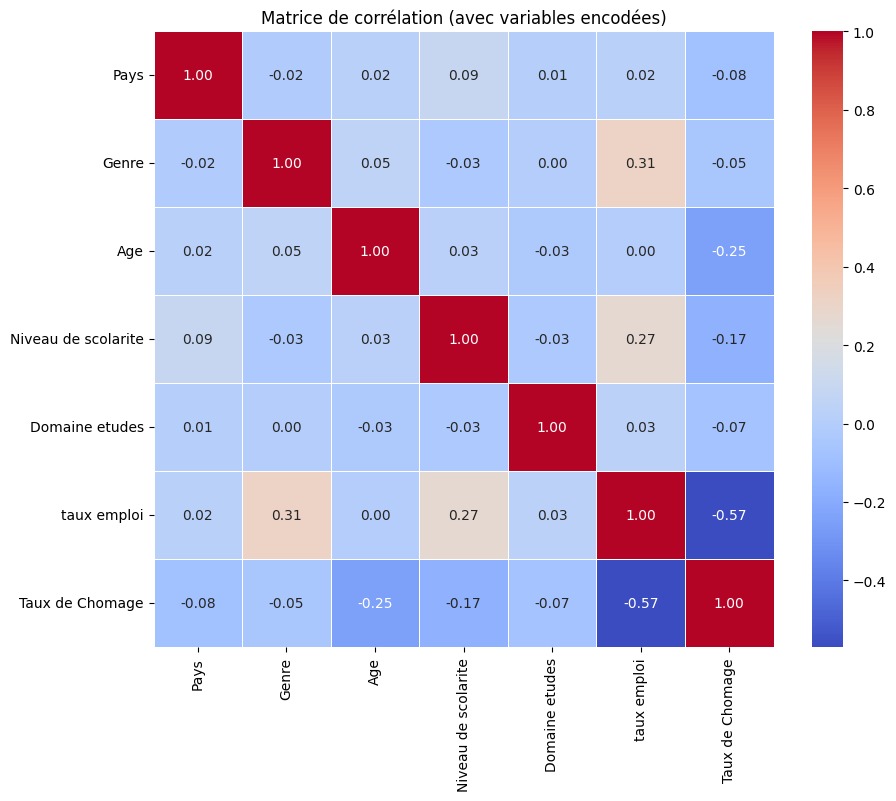

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Encodage des variables catégoriques
df_encoded = tauxChomEmploi.copy()
for column in ['Pays', 'Genre', 'Age', 'Niveau de scolarite', 'Domaine etudes']:
    df_encoded[column] = df_encoded[column].astype('category').cat.codes

# Calcul de la matrice de corrélation
correlation_matrix = df_encoded.corr()

# Affichage de la matrice de corrélation
print(correlation_matrix)

# Visualisation avec heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélation (avec variables encodées)')
plt.show()


1. Corrélation entre taux emploi et Taux de Chomage :

-0.57 (corrélation négative modérée à forte). Plus le taux d'emploi est élevé, plus le taux de chômage tend à être faible (relation intuitive).
Corrélation entre Genre et taux emploi :
2. Corrélation entre Age et Taux de Chomage :
-0.25 (corrélation négative faible). Les personnes plus âgées pourraient avoir un taux de chômage légèrement plus faible.
3. Corrélation entre Niveau de scolarite et taux emploi :

0.27 (corrélation positive faible à modérée). Un niveau d'études plus élevé est associé à un taux d'emploi plus important.
4. Absence de corrélation forte pour certaines variables :

Les corrélations entre Domaine etudes et d'autres variables sont très faibles (autour de 0), ce qui suggère que cette variable pourrait ne pas avoir de relation linéaire directe avec celles analysées ici.

**5-3-la dataset de diffRevenue :**

In [ ]:
diffRevenue = pd.read_csv('/content/drive/MyDrive/diffRe2021.csv')
# description de data
diffRevenue.head()


,Pays,Groupe age,Niveau etude,Proportion des revenus des femmes par rapport aux hommes (%)
0,Danemark,De 45 à 54 ans,Deuxième cycle du secondaire ou post-secondair...,78.976540
1,Canada,De 25 à 34 ans,Deuxième cycle du secondaire ou post-secondair...,73.081802
2,Lettonie,De 55 à 64 ans,"Niveau master, doctorat ou équivalent",82.032822
3,Suisse,De 55 à 64 ans,Enseignement post-secondaire non tertiaire,80.070908
4,Autriche,De 55 à 64 ans,Filière générale du deuxième cycle du secondai...,107.294113


In [ ]:
# Obtenir des informations sur la structure du dataset
diffRevenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 4 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Pays                                                          1470 non-null   object 
 1   Groupe age                                                    1470 non-null   object 
 2   Niveau etude                                                  1470 non-null   object 
 3   Proportion des revenus des femmes par rapport aux hommes (%)  1470 non-null   float64
dtypes: float64(1), object(3)
memory usage: 46.1+ KB


In [ ]:
diffRevenue.describe()

,Proportion des revenus des femmes par rapport aux hommes (%)
count,1470.000000
mean,79.528683
std,7.477461
min,51.759571
25%,75.493963
50%,80.070908
75%,83.090586
max,118.847076


<ipython-input-10-85cafe7d6696>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


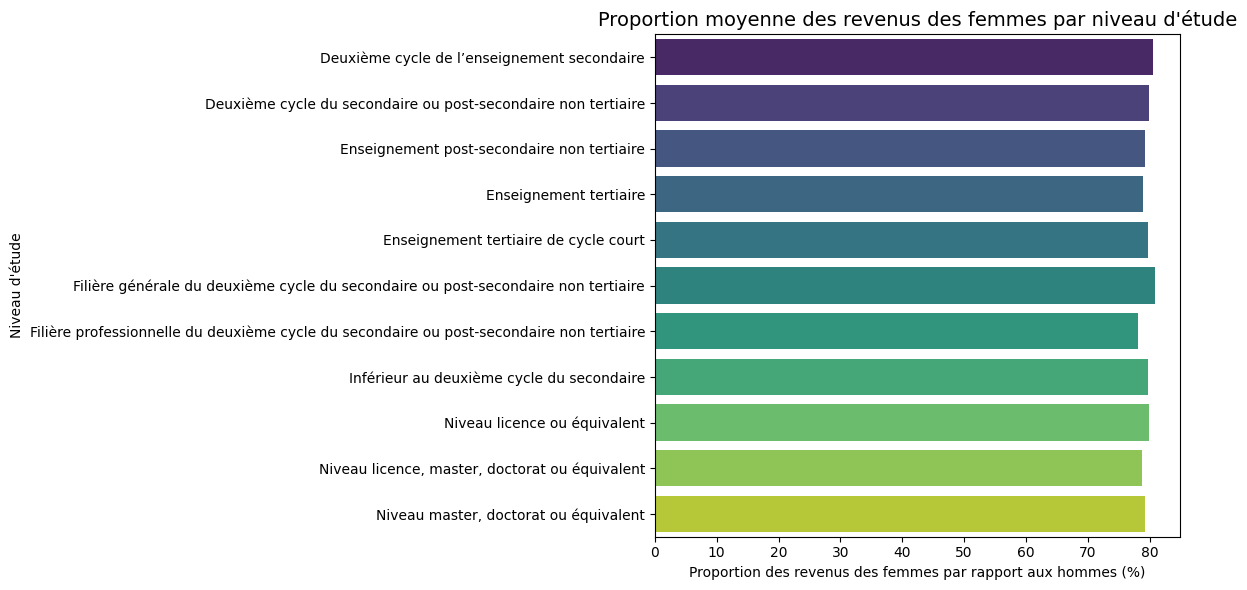

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer la moyenne des proportions par niveau d'étude
revenus_par_niveau = (
    diffRevenue.groupby('Niveau etude')['Proportion des revenus des femmes par rapport aux hommes (%)']
    .mean()
    .sort_index()
    .reset_index()
)

# Visualiser les données avec un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(
    data=revenus_par_niveau,
    x='Proportion des revenus des femmes par rapport aux hommes (%)',
    y='Niveau etude',
    palette='viridis'
)

# Ajouter des détails au graphique
plt.title("Proportion moyenne des revenus des femmes par niveau d'étude", fontsize=14)
plt.xlabel("Proportion des revenus des femmes par rapport aux hommes (%)")
plt.ylabel("Niveau d'étude")
plt.tight_layout()
plt.show()


<ipython-input-13-8d610237246a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


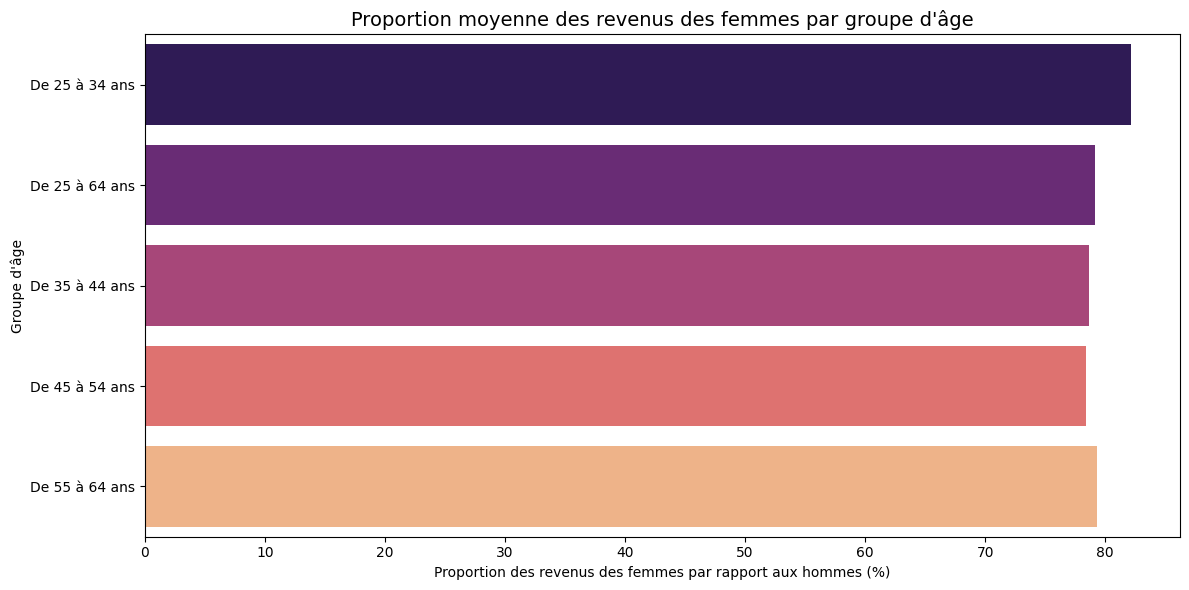

In [ ]:
# Visualisation par "Groupe age"
plot_bar_by_category(
    df=diffRevenue,
    category="Groupe age",
    value="Proportion des revenus des femmes par rapport aux hommes (%)",
    title="Proportion moyenne des revenus des femmes par groupe d'âge",
    xlabel="Proportion des revenus des femmes par rapport aux hommes (%)",
    ylabel="Groupe d'âge",
    palette="magma"
)

<ipython-input-13-8d610237246a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


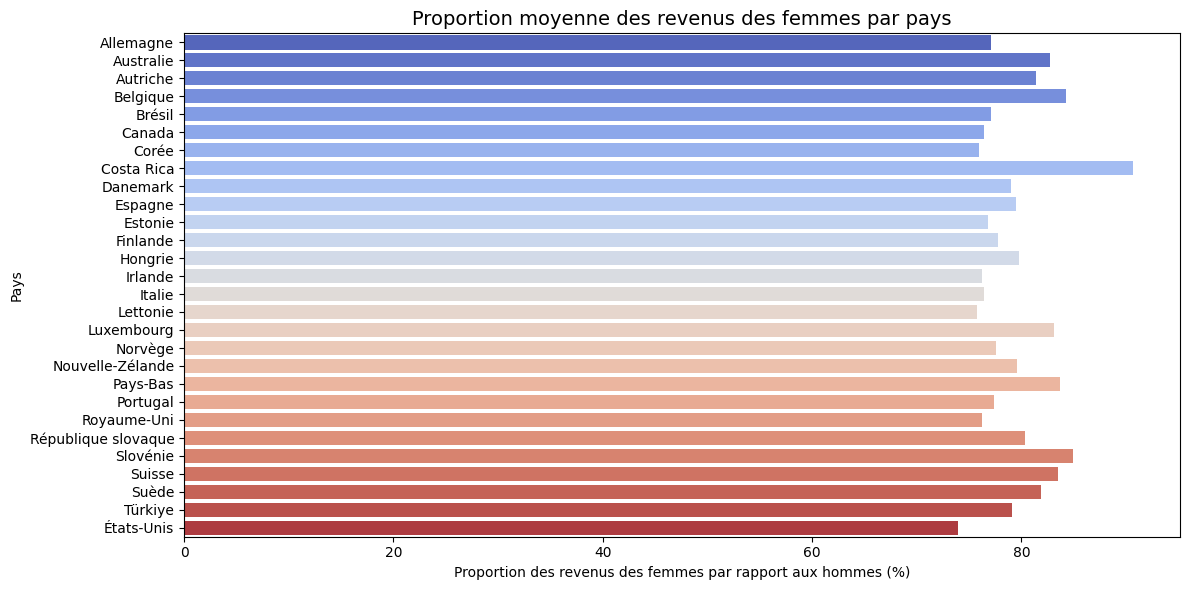

In [ ]:
# Visualisation par "Pays"
plot_bar_by_category(
    df=diffRevenue,
    category="Pays",
    value="Proportion des revenus des femmes par rapport aux hommes (%)",
    title="Proportion moyenne des revenus des femmes par pays",
    xlabel="Proportion des revenus des femmes par rapport aux hommes (%)",
    ylabel="Pays",
    palette="coolwarm"
)



#**3- Analyse de Données :**

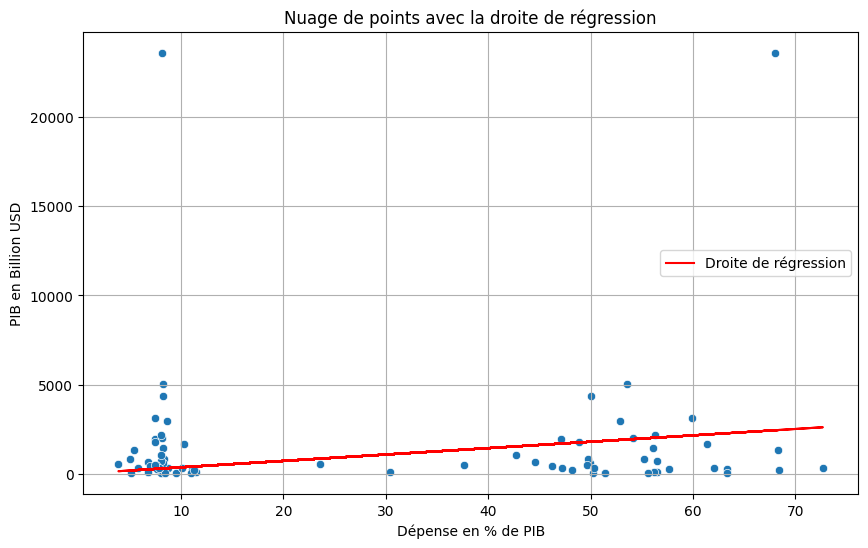

In [ ]:
X = df[['depense']]
y = df['PIB']
model = sm.OLS(y, X).fit()
# Prédire les valeurs de y à partir du modèle
y_pred = model.predict(X)

# Créer le nuage de points avec la droite de régression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='depense', y='PIB', data=df)
plt.plot(df['depense'], y_pred, color='red', label='Droite de régression')

# Ajouter des titres et des labels
plt.title('Nuage de points avec la droite de régression')
plt.xlabel('Dépense en % de PIB')
plt.ylabel('PIB en Billion USD')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

La droite de régression montre une tendance légèrement croissante, indiquant une relation positive entre les dépenses et le PIB.C.est a dire une augmentation des dépenses en % du PIB est associée à une augmentation moyenne du PIB.
- Concentration des points dans des zones spécifiques (elle reflète des groupes de pays ayant des profils économiques similaires) :

   - Zone à faible dépense (0-15 %) et faible PIB : La majorité des pays ont des dépenses en pourcentage du PIB relativement faibles, associées à un PIB également faible. Cela peut indiquer que ces pays partagent des caractéristiques communes, comme des économies émergentes ou de petite taille.
   - Zone avec des valeurs extrêmes (outliers) : Quelques élements se situent loin de cette concentration, avec un PIB très élevé malgré une dépense relativement moyenne. Ces points représentent des économies exceptionnelles qui ne suivent pas la tendance générale.
- Dispersion des points :

   - La dispersion reflète la variabilité dans la relation entre les dépenses et le PIB.
   - Cette dispersion indique que d'autres facteurs influencent le PIB, ce qui limite la capacité des dépenses seules à prédire le PIB.


**Résumé du modèle :**

In [ ]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    PIB   R-squared (uncentered):                   0.112
Model:                            OLS   Adj. R-squared (uncentered):              0.101
Method:                 Least Squares   F-statistic:                              9.494
Date:                Mon, 23 Dec 2024   Prob (F-statistic):                     0.00288
Time:                        23:38:20   Log-Likelihood:                         -736.03
No. Observations:                  76   AIC:                                      1474.
Df Residuals:                      75   BIC:                                      1476.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Intreprétations :**
- R-squared (R²) =  0.112 : Cela indique que 11.2% de la variance de la variable dépendante (PIB) est expliquée par les dépenses . Cela suggère que le modèle ne parvient pas à bien expliquer la variation du PIB en fonction des dépenses, ce qui peut indiquer que d'autres facteurs non pris en compte pourraient être responsables de la variation du PIB.
- depense (coefficient) = 35.8364 : ce qui montre que depense a un effet posotive sur le PIB, dont chaque augmentation d'une unité de dépense en pourcentage du PIB est associée à une augmentation de 35.8364 dans le PIB (en billions USD).

**Tests de régression :** pour évaluer la qualité du modèle de régression

**Test de Durbin-Watson (DW) :** pour mesurer l'autocorrélation des résidus du modèle de régression :

In [ ]:
dw = sm.stats.durbin_watson(model.resid)
print(f'Test de Durbin-Watson: {dw}')

Test de Durbin-Watson: 1.1627120469427652


- DW = 1.162 indique une autocorrélation positive modérée dans les résidus. Cela signifie que les erreurs dans le modèle sont corrélées dans une certaine mesure.Ce qui  pourrait suggérer qu'il existe une relation entre les observations.

**Test de White :** pour vérifier la présence d'hétéroscédasticité(si la variance des résidus est constante à travers les observations )

In [ ]:
X_with_const = sm.add_constant(model.model.exog)

new_model = sm.OLS(model.model.endog, X_with_const).fit()

white_test = het_white(new_model.resid, new_model.model.exog)
labels = ['LM statistic', 'p-value', 'f-statistic', 'f p-value']
print(dict(zip(labels, white_test)))


{'LM statistic': 3.5399213834969983, 'p-value': 0.17033968444896883, 'f-statistic': 1.7831491900729628, 'f p-value': 0.17535175397488675}


- p-value vaut 0.17 > 0.05 suggère que nous n'avons pas de preuves suffisantes pour rejeter l'hypothèse nulle. En d'autres termes, la variance des résidus semble être constante.
- Cela peut indiquer que la relation entre ces deux variables semble stable, peu importe le niveau de PIB.

**Test de normalité de Shapiro-Wilk :** utilisé pour vérifier si les résidus suivent une distribution normale.

In [ ]:
shapiro_test = stats.shapiro(model.resid)
print(f'Test de Shapiro-Wilk: {shapiro_test}')

Test de Shapiro-Wilk: ShapiroResult(statistic=0.47090263225126716, pvalue=4.362107488354104e-15)


-  p-value ≈ 4.36e-15, inférieur a 0.05, ce qui indique que les résidus ne suivent pas une distribution normale.
- Cela peut indiquer que la relation entre les dépenses en pourcentage du PIB et le PIB en billions USD n'est peut-être pas parfaitement linéaire, ou qu'il existe des facteurs non pris en compte dans le modèle qui influencent cette relation.

##**Dans quelle mesure le taux de chômage impacte-t-il le taux d'emploi ?**



##On répond en appliquant la régression linéaire :

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Charger les données
tauxChomEmploi = pd.read_csv('/content/drive/MyDrive/tauxChomEmploi2.csv')
# description de data
tauxChomEmploi.head()


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,taux emploi,Taux de Chomage
0,Pays-Bas,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences, technologie, ingénierie et mathémati...",81.568626,2.347418
1,Slovénie,M,De 35 à 44 ans,"Niveau master, doctorat ou équivalent",Éducation (grand domaine),91.121391,7.145464
2,Suisse,F,De 35 à 44 ans,Niveau licence ou équivalent,Lettres et arts,72.585220,15.116038
3,Allemagne,M,De 45 à 54 ans,"Niveau master, doctorat ou équivalent","Sciences humaines (sauf langues), sciences soc...",92.181023,3.538925
4,Suisse,M,De 25 à 34 ans,"Niveau master, doctorat ou équivalent","Ingénierie, industries de transformation et co...",95.193298,3.940461


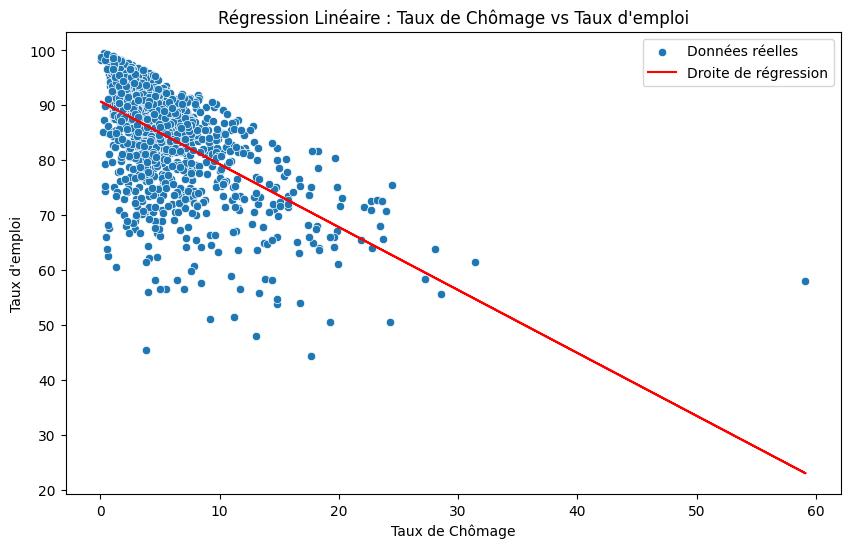

Coefficient de régression (pente) : -1.1459794550043112
Ordonnée à l'origine : 90.7302564292137
Score R^2 : 0.32586443443023394


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



# Sélectionner les variables
X = tauxChomEmploi[['Taux de Chomage']]  # Variable indépendante
y = tauxChomEmploi['taux emploi']       # Variable dépendante

# Créer une instance du modèle de régression linéaire
reg_model = LinearRegression()

# Entraîner le modèle
reg_model.fit(X, y)

# Prédire les valeurs de y basées sur le modèle
y_pred = reg_model.predict(X)

# Tracer le nuage de points et la droite de régression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['Taux de Chomage'], y=y, label='Données réelles')
plt.plot(X['Taux de Chomage'], y_pred, color='red', label='Droite de régression')

# Ajouter des titres et des labels
plt.title('Régression Linéaire : Taux de Chômage vs Taux d\'emploi')
plt.xlabel('Taux de Chômage')
plt.ylabel('Taux d\'emploi')
plt.legend()

# Afficher le graphique
plt.show()

# Afficher les coefficients du modèle
print(f"Coefficient de régression (pente) : {reg_model.coef_[0]}")
print(f"Ordonnée à l'origine : {reg_model.intercept_}")
print(f"Score R^2 : {r2_score(y, y_pred)}")


* Corrélation négative:

La pente de la droite est négative, indiquant qu'il existe une relation inverse entre le taux de chômage et le taux d'emploi. En d'autres termes, plus le taux de chômage est élevé, plus le taux d'emploi est faible.
Alignement des points :

* Les points sont globalement alignés le long de la droite de régression, ce qui suggère que la régression linéaire est un modèle raisonnable pour décrire cette relation. Cependant, il y a une certaine dispersion autour de la droite.

* Le
𝑅
  indique la proportion de la variance dans la variable dépendante (taux d'emploi) expliquée par la variable indépendante (taux de chômage).

* Un
𝑅
carré
  de 0.326 (ou 32.6 %) signifie que seulement environ 32.6 % de la variabilité du taux d'emploi est expliquée par le taux de chômage.
Ce score est relativement faible, ce qui suggère que d'autres facteurs non inclus dans le modèle influencent le taux d'emploi.



##**Comment la dispersion des taux de chômage diffère-t-elle entre les différents niveaux d'études ?**

##On répond en appliquant **ANOVA** :

ANOVA : Impact des niveau d'études sur le taux de chômage
                              sum_sq      df          F        PR(>F)
C(Niveau_de_scolarite)    816.292999     2.0  18.341049  1.439268e-08
Residual                25769.171549  1158.0        NaN           NaN


<ipython-input-6-463cd1027932>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Niveau_de_scolarite', y='Taux_de_Chomage', palette='coolwarm')


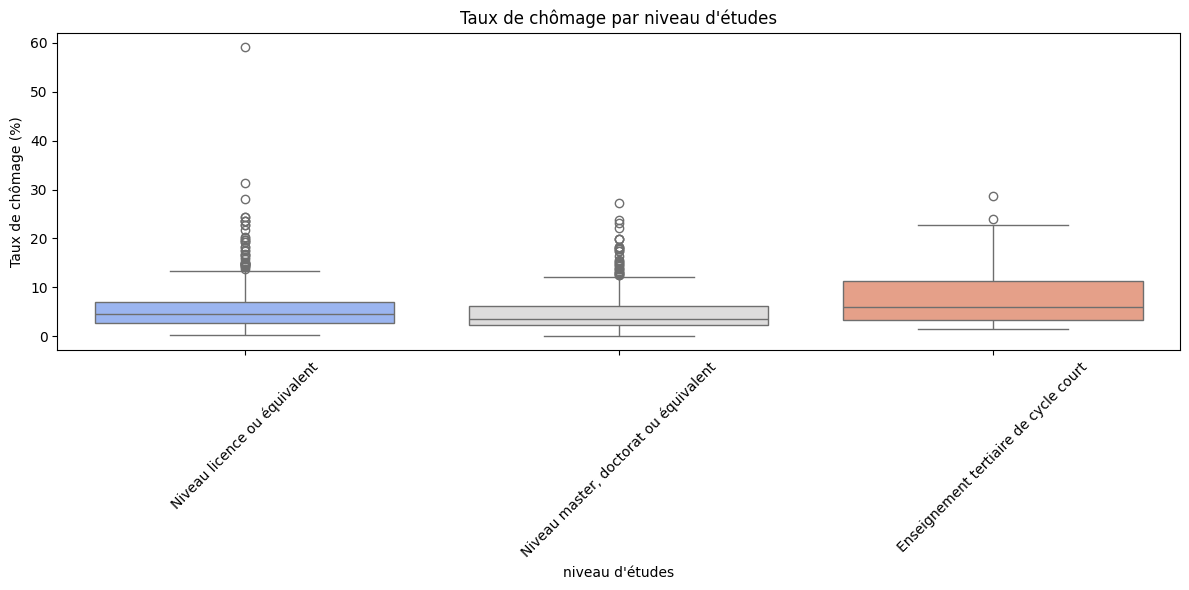

In [ ]:
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns
# Renommer les colonnes pour supprimer les espaces
df = tauxChomEmploi.rename(columns={
    'Taux de Chomage': 'Taux_de_Chomage',
    'Niveau de scolarite': 'Niveau_de_scolarite'
})

# ANOVA après renommage des colonnes
model = ols('Taux_de_Chomage ~ C(Niveau_de_scolarite)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Afficher les résultats
print("ANOVA : Impact des niveau d'études sur le taux de chômage")
print(anova_table)

# Visualisation des données
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Niveau_de_scolarite', y='Taux_de_Chomage', palette='coolwarm')
plt.title("Taux de chômage par niveau d'études")
plt.xlabel("niveau d'études")
plt.ylabel("Taux de chômage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Interpretation :**

* Comparaison entre les domaines :

* Niveau licence ou équivalent : La médiane est relativement basse, mais il y a plusieurs outliers avec des taux de chômage très élevés, dépassant parfois 50 %.
* Niveau master, doctorat ou équivalent : La médiane est légèrement inférieure, et il semble que les taux de chômage soient globalement concentrés autour de valeurs faibles (moins d'outliers).
* Enseignement tertiaire de cycle court : La distribution est similaire à celle du niveau licence, mais il y a moins de valeurs extrêmes.

* sum_sq : La somme des carrés pour le facteur Niveau_de_scolarite est de 816.29, ce qui montre l'importance de ce facteur dans l'explication de la variabilité du taux de chômage.
* df : Les degrés de liberté pour cette variable sont de 2, ce qui signifie qu'il y a trois catégories de niveaux d'études dans votre modèle.
* F : La valeur F de 18.34 indique que la variation entre les groupes (niveaux d'études) est beaucoup plus grande que la variation résiduelle, ce qui confirme une forte relation entre le niveau d'études et le taux de chômage.
* PR(>F) : La valeur p est de 1.44e-08, ce qui est très significatif et signifie que vous pouvez rejeter l'hypothèse nulle (qui suggère qu'il n'y a pas d'effet du niveau d'études sur le taux de chômage).

* Conclusion générale :

Les niveaux supérieurs d'études (comme master ou doctorat) semblent être associés à des taux de chômage plus faibles et moins de dispersion. Les niveaux de cycle court ou équivalents montrent une plus grande variation et des risques plus élevés de chômage dans certains cas.

##**Y a-t-il une forte variabilité du taux d'emploi selon les domaines d'études ?**

##**en appliquant ANOVA on repond :**

ANOVA : Impact des domaines d'études sur le taux d'emploi
                          sum_sq      df         F        PR(>F)
C(Domaine_etudes)    4757.173819    12.0  4.445011  5.343476e-07
Residual           102385.123387  1148.0       NaN           NaN


<ipython-input-11-7b3f07f528a0>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordre_domaine = df.groupby('Domaine_etudes')['taux_emploi'].median().sort_values().index
<ipython-input-11-7b3f07f528a0>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Domaine_etudes', y='taux_emploi', palette='coolwarm')


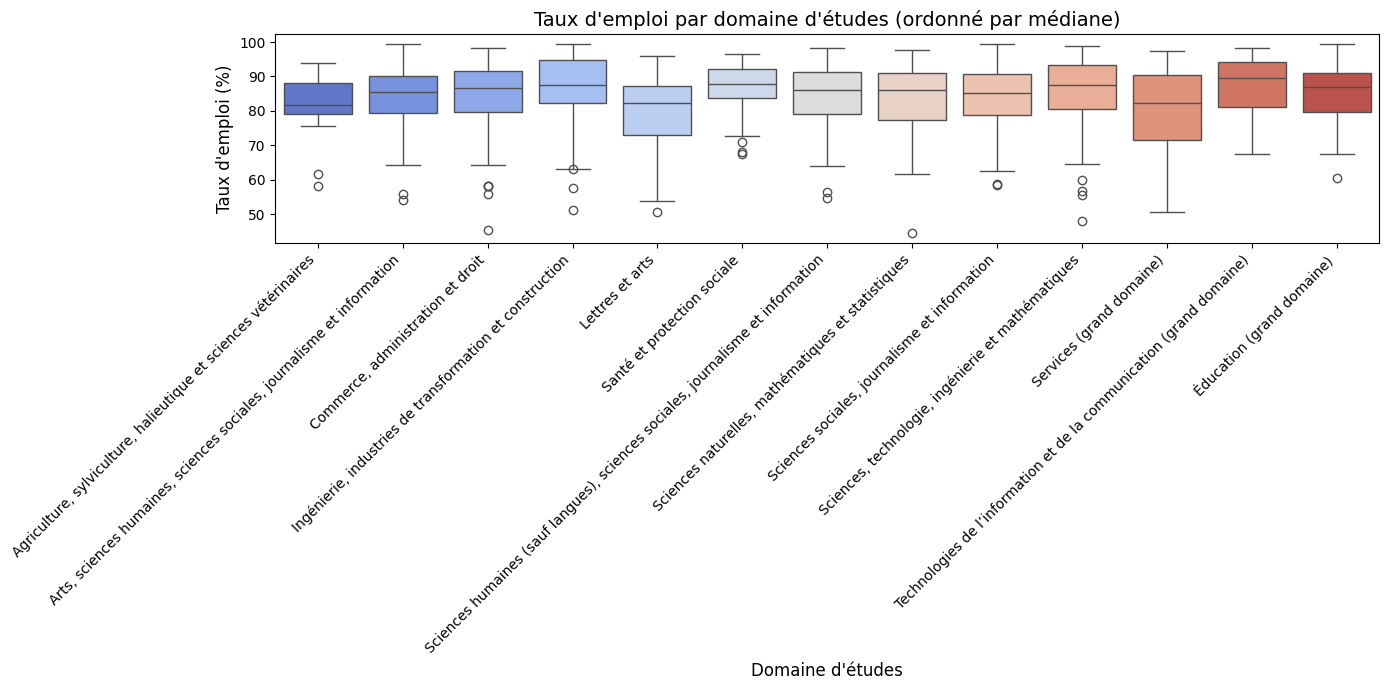

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# Renommer les colonnes pour supprimer les espaces
df = tauxChomEmploi.rename(columns={
    'taux emploi': 'taux_emploi',
    'Domaine etudes': 'Domaine_etudes'
})

# ANOVA après renommage des colonnes
model = ols('taux_emploi ~ C(Domaine_etudes)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Afficher les résultats de l'ANOVA
print("ANOVA : Impact des domaines d'études sur le taux d'emploi")
print(anova_table)

# Ajouter une colonne pour ordonner les domaines d'études par médiane
df['Domaine_etudes'] = df['Domaine_etudes'].astype('category')
ordre_domaine = df.groupby('Domaine_etudes')['taux_emploi'].median().sort_values().index
df['Domaine_etudes'] = df['Domaine_etudes'].cat.reorder_categories(ordre_domaine, ordered=True)

# Visualisation améliorée des données
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='Domaine_etudes', y='taux_emploi', palette='coolwarm')

# Ajouter des titres et ajustements
plt.title("Taux d'emploi par domaine d'études (ordonné par médiane)", fontsize=14)
plt.xlabel("Domaine d'études", fontsize=12)
plt.ylabel("Taux d'emploi (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.tight_layout()

# Afficher le graphique
plt.show()




*   F-statistic (F) : 4.445  Une statistique F élevée indique que les différences entre les groupes sont probablement significatives.
* p-value (PR(>F)) : 5.34×10−75.34×10 −7
   Cette valeur extrêmement faible (< 0.05) indique qu'il y a une différence significative entre les domaines d'études.

* Conclusion générale :
Le graphique montre que les domaines d'études influencent significativement le taux d'emploi, en ligne avec les résultats de l'ANOVA.
Les domaines techniques et liés aux TIC (technologies de l'information) offrent généralement de meilleures opportunités, tandis que les filières artistiques et sociales présentent des défis plus importants pour l'intégration sur le marché du travail.


